In [10]:
from rllab.algos.trpo import TRPO
from rllab.baselines.linear_feature_baseline import LinearFeatureBaseline
from rllab.envs.gym_env import GymEnv
from rllab.envs.normalized_env import normalize
from rllab.policies.gaussian_mlp_policy import GaussianMLPPolicy
from rllab.policies.constant_control_policy import ConstantControlPolicy
import rllab.misc.logger as logger
from rllab.sampler import parallel_sampler
from test import test_const_adv, test_rand_adv, test_learnt_adv, test_rand_step_adv, test_step_adv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import gym
import random
import pickle
import scipy
import argparse

### Default Parameters

In [2]:
env_name = None                     #Name of adversarial environment
path_length = 1000                  #Maximum episode length
layer_size = tuple([100,100,100])   #Layer definition
ifRender = False                    #Should we render?
afterRender = 100                   #After how many to animate
n_exps = 1                          #Number of training instances to run
n_itr = 25                          #Number of iterations of the alternating optimization
n_pro_itr = 1                       #Number of iterations for the protaginist
n_adv_itr = 1                       #Number of interations for the adversary
batch_size = 4000                   #Number of training samples for each iteration
save_every = 100                    #Save checkpoint every save_every iterations
n_process = 1                       #Number of parallel threads for sampling environment
adv_fraction = 0.25                 #Fraction of maximum adversarial force to be applied
step_size = 0.01                    #kl step size for TRPO
gae_lambda = 0.97                   #gae_lambda for learner
save_dir = './results'              #folder to save result in

### Variables for Experiment

In [3]:
env_name = 'HalfCheetahAdv-v1'

layer_size = tuple([64,64])
step_size = 0.02
gae_lambda = 0.95
batch_size = 25000

n_itr = 500
save_every = 20
n_process = 4

adv_fraction = 7.0

In [4]:
args = [env_name, path_length, layer_size, ifRender, afterRender, n_exps, n_itr, n_pro_itr, n_adv_itr, 
        batch_size, save_every, n_process, adv_fraction, step_size, gae_lambda, save_dir]

### Adv Policy

In [5]:
filepath = 'results/Cheetah/env-HalfCheetahAdv-v1_Exp1_Itr500_BS25000_Adv0.25_stp0.02_lam0.95_95277.p'

res_D = pickle.load(open(filepath,'rb'))
pretrained_adv_policy = res_D['adv_policy']

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
[2018-01-24 16:40:04,897] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


### Train Loop

In [6]:
## Initializing summaries for the tests ##
const_test_rew_summary = []
rand_test_rew_summary = []
step_test_rew_summary = []
rand_step_test_rew_summary = []
adv_test_rew_summary = []

## Preparing file to save results in ##
save_prefix = 'adv_env-{}_Exp{}_Itr{}_BS{}_Adv{}_stp{}_lam{}_{}'.format(env_name, n_exps, n_itr, batch_size, adv_fraction, step_size, gae_lambda, random.randint(0,1000000))
save_name = save_dir+'/'+save_prefix

## Looping over experiments to carry out ##
for ne in range(n_exps):
    ## Environment definition ##
    ## The second argument in GymEnv defines the relative magnitude of adversary. For testing we set this to 1.0.
    env = normalize(GymEnv(env_name, adv_fraction))
    env_orig = normalize(GymEnv(env_name, 1.0))

    ## Protagonist policy definition ##
    pro_policy = GaussianMLPPolicy(
        env_spec=env.spec,
        hidden_sizes=layer_size,
        is_protagonist=True
    )
    pro_baseline = LinearFeatureBaseline(env_spec=env.spec)

    ## Zero Adversary for the protagonist training ##
    zero_adv_policy = ConstantControlPolicy(
        env_spec=env.spec,
        is_protagonist=False,
        constant_val = 0.0
    )

    ## Adversary policy definition ##
    adv_policy = pretrained_adv_policy
    adv_baseline = LinearFeatureBaseline(env_spec=env.spec)

    ## Initializing the parallel sampler ##
    parallel_sampler.initialize(n_process)

    ## Optimizer for the Protagonist ##
    pro_algo = TRPO(
        env=env,
        pro_policy=pro_policy,
        adv_policy=adv_policy,
        pro_baseline=pro_baseline,
        adv_baseline=adv_baseline,
        batch_size=batch_size,
        max_path_length=path_length,
        n_itr=n_pro_itr,
        discount=0.995,
        gae_lambda=gae_lambda,
        step_size=step_size,
        is_protagonist=True
    )

    ## Setting up summaries for testing for a specific training instance ##
    pro_rews = []
    adv_rews = []
    all_rews = []
    const_testing_rews = []
    const_testing_rews.append(test_const_adv(env_orig, pro_policy, path_length=path_length))
    rand_testing_rews = []
    rand_testing_rews.append(test_rand_adv(env_orig, pro_policy, path_length=path_length))
    step_testing_rews = []
    step_testing_rews.append(test_step_adv(env_orig, pro_policy, path_length=path_length))
    rand_step_testing_rews = []
    rand_step_testing_rews.append(test_rand_step_adv(env_orig, pro_policy, path_length=path_length))
    adv_testing_rews = []
    adv_testing_rews.append(test_learnt_adv(env, pro_policy, adv_policy, path_length=path_length))

    ## Beginning alternating optimization ##
    for ni in range(n_itr):
        logger.log('\n\nExperiment: {} Iteration: {}\n'.format(ne,ni,))
        
        ## Train Protagonist
        pro_algo.train()
        pro_rews += pro_algo.rews; all_rews += pro_algo.rews;
        logger.log('Protag Reward: {}'.format(np.array(pro_algo.rews).mean()))
        
        ## Test the learnt policies
        const_testing_rews.append(test_const_adv(env, pro_policy, path_length=path_length))
        rand_testing_rews.append(test_rand_adv(env, pro_policy, path_length=path_length))
        step_testing_rews.append(test_step_adv(env, pro_policy, path_length=path_length))
        rand_step_testing_rews.append(test_rand_step_adv(env, pro_policy, path_length=path_length))
        adv_testing_rews.append(test_learnt_adv(env, pro_policy, adv_policy, path_length=path_length))

        if ni%afterRender==0 and ifRender==True:
            test_const_adv(env, pro_policy, path_length=path_length, n_traj=1, render=True);

        if ni!=0 and ni%save_every==0:
            ## SAVING CHECKPOINT INFO ##
            pickle.dump({'args': args,
                         'pro_policy': pro_policy,
                         'adv_policy': adv_policy,
                         'zero_test': [const_testing_rews],
                         'rand_test': [rand_testing_rews],
                         'step_test': [step_testing_rews],
                         'rand_step_test': [rand_step_testing_rews],
                         'iter_save': ni,
                         'exp_save': ne,
                         'adv_test': [adv_testing_rews]}, open(save_name+'_'+str(ni)+'.p','wb'))

    ## Shutting down the optimizer ##
    pro_algo.shutdown_worker()

    ## Updating the test summaries over all training instances
    const_test_rew_summary.append(const_testing_rews)
    rand_test_rew_summary.append(rand_testing_rews)
    step_test_rew_summary.append(step_testing_rews)
    rand_step_test_rew_summary.append(rand_step_testing_rews)
    adv_test_rew_summary.append(adv_testing_rews)

2018-01-24 16:40:06.961014 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-24 16:40:06,969] Making new env: HalfCheetahAdv-v1


2018-01-24 16:40:07.243852 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-24 16:40:07,245] Making new env: HalfCheetahAdv-v1


2018-01-24 16:40:07.498686 EST | Populating workers...
2018-01-24 16:40:07.504578 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-24 16:40:07.504675 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-24 16:40:07.504677 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-24 16:40:07.504676 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-24 16:40:07,507] Making new env: HalfCheetahAdv-v1
[2018-01-24 16:40:07,509] Making new env: HalfCheetahAdv-v1
[2018-01-24 16:40:07,510] Making new env: HalfCheetahAdv-v1
[2018-01-24 16:40:07,509] Making new env: HalfCheetahAdv-v1


2018-01-24 16:40:07.825362 EST | Populated
2018-01-24 16:40:21.211435 EST | 

Experiment: 0 Iteration: 0

2018-01-24 16:40:21.212413 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-24 16:40:25.333952 EST | fitting baseline...
2018-01-24 16:40:25.361154 EST | fitted



Total time elapsed: 00:00:04


=: Compiling function f_loss
done in 0.291 seconds
=: Compiling function constraint
done in 0.141 seconds
2018-01-24 16:40:26.149943 EST | computing loss before
2018-01-24 16:40:26.330100 EST | performing update
2018-01-24 16:40:26.333965 EST | computing descent direction
=: Compiling function f_grad
done in 0.662 seconds
=: Compiling function f_Hx_plain
done in 1.649 seconds
2018-01-24 16:40:34.643396 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 1.024 seconds
2018-01-24 16:40:35.902540 EST | backtrack iters: 0
2018-01-24 16:40:35.905530 EST | computing loss after
2018-01-24 16:40:35.908280 EST | optimization finished
2018-01-24 16:40:36.359556 EST | Protag Reward: -1159.3485606634179
2018-01-24 16:40:51.671371 EST | 

Experiment: 0 Iteration: 1

2018-01-24 16:40:51.673088 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


2018-01-24 16:40:55.483579 EST | fitting baseline...
2018-01-24 16:40:55.517889 EST | fitted
2018-01-24 16:40:55.978923 EST | computing loss before
2018-01-24 16:40:56.176714 EST | performing update
2018-01-24 16:40:56.179901 EST | computing descent direction
2018-01-24 16:41:02.796997 EST | descent direction computed
2018-01-24 16:41:03.013668 EST | backtrack iters: 0
2018-01-24 16:41:03.015028 EST | computing loss after
2018-01-24 16:41:03.016167 EST | optimization finished
2018-01-24 16:41:03.492390 EST | Protag Reward: -1198.3111499523927
2018-01-24 16:41:18.159815 EST | 

Experiment: 0 Iteration: 2

2018-01-24 16:41:18.161026 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 16:41:26.911144 EST | fitting baseline...
2018-01-24 16:41:26.931211 EST | fitted
2018-01-24 16:41:27.593412 EST | computing loss before
2018-01-24 16:41:28.164534 EST | performing update
2018-01-24 16:41:28.169207 EST | computing descent direction
2018-01-24 16:41:37.825838 EST | descent direction computed
2018-01-24 16:41:38.250553 EST | backtrack iters: 0
2018-01-24 16:41:38.253001 EST | computing loss after
2018-01-24 16:41:38.255025 EST | optimization finished
2018-01-24 16:41:38.764303 EST | Protag Reward: -1173.272750330752
2018-01-24 16:42:01.345938 EST | 

Experiment: 0 Iteration: 3

2018-01-24 16:42:01.347026 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 16:42:13.807832 EST | fitting baseline...
2018-01-24 16:42:13.954994 EST | fitted
2018-01-24 16:42:14.585992 EST | computing loss before
2018-01-24 16:42:14.930037 EST | performing update
2018-01-24 16:42:14.931585 EST | computing descent direction
2018-01-24 16:42:28.090269 EST | descent direction computed
2018-01-24 16:42:28.474796 EST | backtrack iters: 0
2018-01-24 16:42:28.476044 EST | computing loss after
2018-01-24 16:42:28.477039 EST | optimization finished
2018-01-24 16:42:29.277402 EST | Protag Reward: -1222.2369132463605
2018-01-24 16:42:53.184219 EST | 

Experiment: 0 Iteration: 4

2018-01-24 16:42:53.189496 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 16:43:02.677430 EST | fitting baseline...
2018-01-24 16:43:02.721893 EST | fitted
2018-01-24 16:43:04.157878 EST | computing loss before
2018-01-24 16:43:04.972735 EST | performing update
2018-01-24 16:43:04.978332 EST | computing descent direction
2018-01-24 16:43:18.878521 EST | descent direction computed
2018-01-24 16:43:19.381783 EST | backtrack iters: 0
2018-01-24 16:43:19.385445 EST | computing loss after
2018-01-24 16:43:19.388069 EST | optimization finished
2018-01-24 16:43:20.170569 EST | Protag Reward: -1139.4455358127882
2018-01-24 16:43:55.358741 EST | 

Experiment: 0 Iteration: 5

2018-01-24 16:43:55.364514 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 16:44:08.573409 EST | fitting baseline...
2018-01-24 16:44:08.701791 EST | fitted
2018-01-24 16:44:09.575497 EST | computing loss before
2018-01-24 16:44:10.001522 EST | performing update
2018-01-24 16:44:10.005205 EST | computing descent direction
2018-01-24 16:44:21.962836 EST | descent direction computed
2018-01-24 16:44:22.320542 EST | backtrack iters: 0
2018-01-24 16:44:22.326038 EST | computing loss after
2018-01-24 16:44:22.327924 EST | optimization finished
2018-01-24 16:44:23.024512 EST | Protag Reward: -1120.595179515791
2018-01-24 16:44:52.326658 EST | 

Experiment: 0 Iteration: 6

2018-01-24 16:44:52.331907 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 16:45:05.386718 EST | fitting baseline...
2018-01-24 16:45:05.414647 EST | fitted
2018-01-24 16:45:06.871515 EST | computing loss before
2018-01-24 16:45:07.494078 EST | performing update
2018-01-24 16:45:07.497985 EST | computing descent direction
2018-01-24 16:45:20.328902 EST | descent direction computed
2018-01-24 16:45:20.654338 EST | backtrack iters: 0
2018-01-24 16:45:20.655969 EST | computing loss after
2018-01-24 16:45:20.660108 EST | optimization finished
2018-01-24 16:45:21.357462 EST | Protag Reward: -1133.918207514913
2018-01-24 16:45:55.728340 EST | 

Experiment: 0 Iteration: 7

2018-01-24 16:45:55.735373 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 16:46:07.896482 EST | fitting baseline...
2018-01-24 16:46:07.941993 EST | fitted
2018-01-24 16:46:08.545408 EST | computing loss before
2018-01-24 16:46:08.909778 EST | performing update
2018-01-24 16:46:08.911508 EST | computing descent direction
2018-01-24 16:46:23.096729 EST | descent direction computed
2018-01-24 16:46:23.997141 EST | backtrack iters: 1
2018-01-24 16:46:23.998586 EST | computing loss after
2018-01-24 16:46:24.000034 EST | optimization finished
2018-01-24 16:46:24.829379 EST | Protag Reward: -1057.5528266979036
2018-01-24 16:46:46.830120 EST | 

Experiment: 0 Iteration: 8

2018-01-24 16:46:46.832220 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 16:46:56.331662 EST | fitting baseline...
2018-01-24 16:46:56.413196 EST | fitted
2018-01-24 16:46:57.350360 EST | computing loss before
2018-01-24 16:46:57.725396 EST | performing update
2018-01-24 16:46:57.726993 EST | computing descent direction
2018-01-24 16:47:05.614517 EST | descent direction computed
2018-01-24 16:47:06.089837 EST | backtrack iters: 0
2018-01-24 16:47:06.092091 EST | computing loss after
2018-01-24 16:47:06.093936 EST | optimization finished
2018-01-24 16:47:06.907062 EST | Protag Reward: -1100.0376495631965
2018-01-24 16:47:29.432534 EST | 

Experiment: 0 Iteration: 9

2018-01-24 16:47:29.433773 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-24 16:47:39.012238 EST | fitting baseline...



Total time elapsed: 00:00:09


2018-01-24 16:47:39.093708 EST | fitted
2018-01-24 16:47:39.792837 EST | computing loss before
2018-01-24 16:47:40.197375 EST | performing update
2018-01-24 16:47:40.198500 EST | computing descent direction
2018-01-24 16:47:51.205069 EST | descent direction computed
2018-01-24 16:47:51.683219 EST | backtrack iters: 0
2018-01-24 16:47:51.687254 EST | computing loss after
2018-01-24 16:47:51.688787 EST | optimization finished
2018-01-24 16:47:52.556038 EST | Protag Reward: -1036.772031499568
2018-01-24 16:48:10.974339 EST | 

Experiment: 0 Iteration: 10

2018-01-24 16:48:10.977025 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 16:48:21.773291 EST | fitting baseline...
2018-01-24 16:48:21.813431 EST | fitted
2018-01-24 16:48:22.713644 EST | computing loss before
2018-01-24 16:48:23.068213 EST | performing update
2018-01-24 16:48:23.073831 EST | computing descent direction
2018-01-24 16:48:34.033317 EST | descent direction computed
2018-01-24 16:48:34.807594 EST | backtrack iters: 1
2018-01-24 16:48:34.810757 EST | computing loss after
2018-01-24 16:48:34.812066 EST | optimization finished
2018-01-24 16:48:35.633659 EST | Protag Reward: -967.0301767234512
2018-01-24 16:49:02.792919 EST | 

Experiment: 0 Iteration: 11

2018-01-24 16:49:02.794475 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 16:49:12.443396 EST | fitting baseline...
2018-01-24 16:49:12.529175 EST | fitted
2018-01-24 16:49:13.274011 EST | computing loss before
2018-01-24 16:49:13.624031 EST | performing update
2018-01-24 16:49:13.626042 EST | computing descent direction
2018-01-24 16:49:23.336041 EST | descent direction computed
2018-01-24 16:49:23.840691 EST | backtrack iters: 0
2018-01-24 16:49:23.842583 EST | computing loss after
2018-01-24 16:49:23.850524 EST | optimization finished
2018-01-24 16:49:24.851316 EST | Protag Reward: -1021.7795905040758
2018-01-24 16:49:45.138840 EST | 

Experiment: 0 Iteration: 12

2018-01-24 16:49:45.142522 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 16:49:54.712927 EST | fitting baseline...
2018-01-24 16:49:54.802525 EST | fitted
2018-01-24 16:49:55.912510 EST | computing loss before
2018-01-24 16:49:56.287663 EST | performing update
2018-01-24 16:49:56.289670 EST | computing descent direction
2018-01-24 16:50:10.746913 EST | descent direction computed
2018-01-24 16:50:11.767880 EST | backtrack iters: 1
2018-01-24 16:50:11.777543 EST | computing loss after
2018-01-24 16:50:11.784017 EST | optimization finished
2018-01-24 16:50:12.717483 EST | Protag Reward: -979.5741320221183
2018-01-24 16:50:31.428177 EST | 

Experiment: 0 Iteration: 13

2018-01-24 16:50:31.429980 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 16:50:47.329192 EST | fitting baseline...
2018-01-24 16:50:47.377478 EST | fitted
2018-01-24 16:50:48.669691 EST | computing loss before
2018-01-24 16:50:49.434678 EST | performing update
2018-01-24 16:50:49.443942 EST | computing descent direction
2018-01-24 16:51:01.854905 EST | descent direction computed
2018-01-24 16:51:02.511975 EST | backtrack iters: 1
2018-01-24 16:51:02.513564 EST | computing loss after
2018-01-24 16:51:02.514949 EST | optimization finished
2018-01-24 16:51:03.266371 EST | Protag Reward: -935.2516752330669
2018-01-24 16:51:22.733464 EST | 

Experiment: 0 Iteration: 14

2018-01-24 16:51:22.735435 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 16:51:36.126954 EST | fitting baseline...
2018-01-24 16:51:36.164786 EST | fitted
2018-01-24 16:51:37.101815 EST | computing loss before
2018-01-24 16:51:37.503765 EST | performing update
2018-01-24 16:51:37.530221 EST | computing descent direction
2018-01-24 16:51:46.641697 EST | descent direction computed
2018-01-24 16:51:47.227178 EST | backtrack iters: 1
2018-01-24 16:51:47.228351 EST | computing loss after
2018-01-24 16:51:47.229730 EST | optimization finished
2018-01-24 16:51:47.905926 EST | Protag Reward: -946.3138410737384
2018-01-24 16:52:07.986936 EST | 

Experiment: 0 Iteration: 15

2018-01-24 16:52:07.995561 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 16:52:20.909440 EST | fitting baseline...
2018-01-24 16:52:20.968106 EST | fitted
2018-01-24 16:52:21.846850 EST | computing loss before
2018-01-24 16:52:22.178050 EST | performing update
2018-01-24 16:52:22.184077 EST | computing descent direction
2018-01-24 16:52:33.046894 EST | descent direction computed
2018-01-24 16:52:33.745779 EST | backtrack iters: 1
2018-01-24 16:52:33.751050 EST | computing loss after
2018-01-24 16:52:33.756134 EST | optimization finished
2018-01-24 16:52:34.482671 EST | Protag Reward: -918.8670910615316
2018-01-24 16:52:58.295080 EST | 

Experiment: 0 Iteration: 16

2018-01-24 16:52:58.300135 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 16:53:11.041991 EST | fitting baseline...
2018-01-24 16:53:11.115126 EST | fitted
2018-01-24 16:53:12.401208 EST | computing loss before
2018-01-24 16:53:12.876142 EST | performing update
2018-01-24 16:53:12.877459 EST | computing descent direction
2018-01-24 16:53:25.224139 EST | descent direction computed
2018-01-24 16:53:25.674750 EST | backtrack iters: 0
2018-01-24 16:53:25.676218 EST | computing loss after
2018-01-24 16:53:25.677512 EST | optimization finished
2018-01-24 16:53:26.433208 EST | Protag Reward: -886.739055596738
2018-01-24 16:53:44.633523 EST | 

Experiment: 0 Iteration: 17

2018-01-24 16:53:44.635607 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 16:53:58.707829 EST | fitting baseline...
2018-01-24 16:53:58.825949 EST | fitted
2018-01-24 16:54:00.091445 EST | computing loss before
2018-01-24 16:54:00.614341 EST | performing update
2018-01-24 16:54:00.621479 EST | computing descent direction
2018-01-24 16:54:10.696019 EST | descent direction computed
2018-01-24 16:54:11.087492 EST | backtrack iters: 0
2018-01-24 16:54:11.091380 EST | computing loss after
2018-01-24 16:54:11.094296 EST | optimization finished
2018-01-24 16:54:11.786498 EST | Protag Reward: -870.7774045347916
2018-01-24 16:54:31.561043 EST | 

Experiment: 0 Iteration: 18

2018-01-24 16:54:31.564654 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 16:54:44.032584 EST | fitting baseline...
2018-01-24 16:54:44.130106 EST | fitted
2018-01-24 16:54:45.028721 EST | computing loss before
2018-01-24 16:54:45.437828 EST | performing update
2018-01-24 16:54:45.439511 EST | computing descent direction
2018-01-24 16:54:53.341554 EST | descent direction computed
2018-01-24 16:54:53.613631 EST | backtrack iters: 0
2018-01-24 16:54:53.617874 EST | computing loss after
2018-01-24 16:54:53.620455 EST | optimization finished
2018-01-24 16:54:54.175169 EST | Protag Reward: -843.9830227658658
2018-01-24 16:55:16.497854 EST | 

Experiment: 0 Iteration: 19

2018-01-24 16:55:16.500166 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 16:55:27.201494 EST | fitting baseline...
2018-01-24 16:55:27.265439 EST | fitted
2018-01-24 16:55:27.989177 EST | computing loss before
2018-01-24 16:55:28.374784 EST | performing update
2018-01-24 16:55:28.376465 EST | computing descent direction
2018-01-24 16:55:38.551096 EST | descent direction computed
2018-01-24 16:55:39.450493 EST | backtrack iters: 1
2018-01-24 16:55:39.452449 EST | computing loss after
2018-01-24 16:55:39.454250 EST | optimization finished
2018-01-24 16:55:40.239804 EST | Protag Reward: -840.9611335091083
2018-01-24 16:55:59.906256 EST | 

Experiment: 0 Iteration: 20

2018-01-24 16:55:59.910201 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 16:56:10.768758 EST | fitting baseline...
2018-01-24 16:56:10.849775 EST | fitted
2018-01-24 16:56:11.853568 EST | computing loss before
2018-01-24 16:56:12.305112 EST | performing update
2018-01-24 16:56:12.309224 EST | computing descent direction
2018-01-24 16:56:23.583908 EST | descent direction computed
2018-01-24 16:56:24.512707 EST | backtrack iters: 1
2018-01-24 16:56:24.521771 EST | computing loss after
2018-01-24 16:56:24.523535 EST | optimization finished
2018-01-24 16:56:25.384747 EST | Protag Reward: -830.7926133717147
2018-01-24 16:56:45.319889 EST | 

Experiment: 0 Iteration: 21

2018-01-24 16:56:45.321511 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 16:56:58.489704 EST | fitting baseline...
2018-01-24 16:56:58.578663 EST | fitted
2018-01-24 16:56:59.482997 EST | computing loss before
2018-01-24 16:56:59.970141 EST | performing update
2018-01-24 16:56:59.976080 EST | computing descent direction
2018-01-24 16:57:09.390261 EST | descent direction computed
2018-01-24 16:57:10.013942 EST | backtrack iters: 1
2018-01-24 16:57:10.015099 EST | computing loss after
2018-01-24 16:57:10.016045 EST | optimization finished
2018-01-24 16:57:10.614215 EST | Protag Reward: -800.0655669098834
2018-01-24 16:57:34.309181 EST | 

Experiment: 0 Iteration: 22

2018-01-24 16:57:34.313110 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 16:57:47.164948 EST | fitting baseline...
2018-01-24 16:57:47.211397 EST | fitted
2018-01-24 16:57:48.030869 EST | computing loss before
2018-01-24 16:57:48.359017 EST | performing update
2018-01-24 16:57:48.360675 EST | computing descent direction
2018-01-24 16:57:56.382626 EST | descent direction computed
2018-01-24 16:57:56.993904 EST | backtrack iters: 1
2018-01-24 16:57:56.995671 EST | computing loss after
2018-01-24 16:57:56.997406 EST | optimization finished
2018-01-24 16:57:57.653979 EST | Protag Reward: -804.1306618812939
2018-01-24 16:58:20.640641 EST | 

Experiment: 0 Iteration: 23

2018-01-24 16:58:20.642345 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 16:58:31.139248 EST | fitting baseline...
2018-01-24 16:58:31.179306 EST | fitted
2018-01-24 16:58:32.004183 EST | computing loss before
2018-01-24 16:58:32.435991 EST | performing update
2018-01-24 16:58:32.437589 EST | computing descent direction
2018-01-24 16:58:42.071867 EST | descent direction computed
2018-01-24 16:58:43.073380 EST | backtrack iters: 1
2018-01-24 16:58:43.075613 EST | computing loss after
2018-01-24 16:58:43.078125 EST | optimization finished
2018-01-24 16:58:44.076988 EST | Protag Reward: -777.4753710504311
2018-01-24 16:59:04.456170 EST | 

Experiment: 0 Iteration: 24

2018-01-24 16:59:04.458774 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-24 16:59:15.782270 EST | fitting baseline...



Total time elapsed: 00:00:11


2018-01-24 16:59:15.920714 EST | fitted
2018-01-24 16:59:16.954688 EST | computing loss before
2018-01-24 16:59:17.369799 EST | performing update
2018-01-24 16:59:17.375029 EST | computing descent direction
2018-01-24 16:59:28.741330 EST | descent direction computed
2018-01-24 16:59:29.523037 EST | backtrack iters: 1
2018-01-24 16:59:29.527629 EST | computing loss after
2018-01-24 16:59:29.530195 EST | optimization finished
2018-01-24 16:59:30.272041 EST | Protag Reward: -765.5061369625012
2018-01-24 16:59:51.068723 EST | 

Experiment: 0 Iteration: 25

2018-01-24 16:59:51.079922 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:00:04.282570 EST | fitting baseline...
2018-01-24 17:00:04.326847 EST | fitted
2018-01-24 17:00:05.228410 EST | computing loss before
2018-01-24 17:00:05.698497 EST | performing update
2018-01-24 17:00:05.705632 EST | computing descent direction
2018-01-24 17:00:14.451353 EST | descent direction computed
2018-01-24 17:00:14.789227 EST | backtrack iters: 0
2018-01-24 17:00:14.790512 EST | computing loss after
2018-01-24 17:00:14.791502 EST | optimization finished
2018-01-24 17:00:15.446126 EST | Protag Reward: -763.7532933373317
2018-01-24 17:00:35.278799 EST | 

Experiment: 0 Iteration: 26

2018-01-24 17:00:35.280718 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:00:47.320510 EST | fitting baseline...
2018-01-24 17:00:47.443487 EST | fitted
2018-01-24 17:00:48.375434 EST | computing loss before
2018-01-24 17:00:48.782769 EST | performing update
2018-01-24 17:00:48.794025 EST | computing descent direction
2018-01-24 17:00:56.797112 EST | descent direction computed
2018-01-24 17:00:57.387236 EST | backtrack iters: 1
2018-01-24 17:00:57.388539 EST | computing loss after
2018-01-24 17:00:57.389576 EST | optimization finished
2018-01-24 17:00:57.970246 EST | Protag Reward: -736.7045854142224
2018-01-24 17:01:20.906853 EST | 

Experiment: 0 Iteration: 27

2018-01-24 17:01:20.909228 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 17:01:30.633714 EST | fitting baseline...
2018-01-24 17:01:30.722673 EST | fitted
2018-01-24 17:01:31.590834 EST | computing loss before
2018-01-24 17:01:31.968570 EST | performing update
2018-01-24 17:01:31.973624 EST | computing descent direction
2018-01-24 17:01:39.874269 EST | descent direction computed
2018-01-24 17:01:40.534008 EST | backtrack iters: 1
2018-01-24 17:01:40.535345 EST | computing loss after
2018-01-24 17:01:40.536791 EST | optimization finished
2018-01-24 17:01:41.257998 EST | Protag Reward: -738.9501383796822
2018-01-24 17:02:04.569837 EST | 

Experiment: 0 Iteration: 28

2018-01-24 17:02:04.571616 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 17:02:15.059123 EST | fitting baseline...
2018-01-24 17:02:15.122863 EST | fitted
2018-01-24 17:02:16.208923 EST | computing loss before
2018-01-24 17:02:16.541728 EST | performing update
2018-01-24 17:02:16.547068 EST | computing descent direction
2018-01-24 17:02:27.237143 EST | descent direction computed
2018-01-24 17:02:28.137362 EST | backtrack iters: 1
2018-01-24 17:02:28.140790 EST | computing loss after
2018-01-24 17:02:28.143634 EST | optimization finished
2018-01-24 17:02:29.078637 EST | Protag Reward: -722.8547097312621
2018-01-24 17:02:52.940643 EST | 

Experiment: 0 Iteration: 29

2018-01-24 17:02:52.943002 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:03:04.346735 EST | fitting baseline...
2018-01-24 17:03:04.389496 EST | fitted
2018-01-24 17:03:05.372368 EST | computing loss before
2018-01-24 17:03:05.833303 EST | performing update
2018-01-24 17:03:05.835439 EST | computing descent direction
2018-01-24 17:03:17.968412 EST | descent direction computed
2018-01-24 17:03:18.932530 EST | backtrack iters: 1
2018-01-24 17:03:18.934396 EST | computing loss after
2018-01-24 17:03:18.935971 EST | optimization finished
2018-01-24 17:03:19.679891 EST | Protag Reward: -713.6426727285772
2018-01-24 17:03:41.065154 EST | 

Experiment: 0 Iteration: 30

2018-01-24 17:03:41.070414 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:03:55.749129 EST | fitting baseline...
2018-01-24 17:03:55.786659 EST | fitted
2018-01-24 17:03:56.810622 EST | computing loss before
2018-01-24 17:03:57.300271 EST | performing update
2018-01-24 17:03:57.304695 EST | computing descent direction
2018-01-24 17:04:07.445123 EST | descent direction computed
2018-01-24 17:04:08.043268 EST | backtrack iters: 1
2018-01-24 17:04:08.044433 EST | computing loss after
2018-01-24 17:04:08.045440 EST | optimization finished
2018-01-24 17:04:08.604826 EST | Protag Reward: -726.2288580484274
2018-01-24 17:04:31.350840 EST | 

Experiment: 0 Iteration: 31

2018-01-24 17:04:31.359635 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:04:45.105715 EST | fitting baseline...
2018-01-24 17:04:45.184309 EST | fitted
2018-01-24 17:04:46.098077 EST | computing loss before
2018-01-24 17:04:46.499749 EST | performing update
2018-01-24 17:04:46.503930 EST | computing descent direction
2018-01-24 17:04:55.676492 EST | descent direction computed
2018-01-24 17:04:56.482735 EST | backtrack iters: 1
2018-01-24 17:04:56.487798 EST | computing loss after
2018-01-24 17:04:56.489473 EST | optimization finished
2018-01-24 17:04:57.246901 EST | Protag Reward: -707.0341868013139
2018-01-24 17:05:25.544446 EST | 

Experiment: 0 Iteration: 32

2018-01-24 17:05:25.552371 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:05:38.798007 EST | fitting baseline...
2018-01-24 17:05:38.842400 EST | fitted
2018-01-24 17:05:39.671160 EST | computing loss before
2018-01-24 17:05:40.013818 EST | performing update
2018-01-24 17:05:40.015265 EST | computing descent direction
2018-01-24 17:05:47.956045 EST | descent direction computed
2018-01-24 17:05:48.633606 EST | backtrack iters: 1
2018-01-24 17:05:48.635077 EST | computing loss after
2018-01-24 17:05:48.636209 EST | optimization finished
2018-01-24 17:05:49.186514 EST | Protag Reward: -704.5089209032004
2018-01-24 17:06:12.383234 EST | 

Experiment: 0 Iteration: 33

2018-01-24 17:06:12.385058 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 17:06:23.066112 EST | fitting baseline...
2018-01-24 17:06:23.158361 EST | fitted
2018-01-24 17:06:24.030200 EST | computing loss before
2018-01-24 17:06:24.419006 EST | performing update
2018-01-24 17:06:24.421564 EST | computing descent direction
2018-01-24 17:06:35.195091 EST | descent direction computed
2018-01-24 17:06:36.055084 EST | backtrack iters: 1
2018-01-24 17:06:36.057300 EST | computing loss after
2018-01-24 17:06:36.062164 EST | optimization finished
2018-01-24 17:06:36.871282 EST | Protag Reward: -681.7116007074247
2018-01-24 17:06:58.515578 EST | 

Experiment: 0 Iteration: 34

2018-01-24 17:06:58.517760 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:07:11.625834 EST | fitting baseline...
2018-01-24 17:07:11.720052 EST | fitted
2018-01-24 17:07:12.596916 EST | computing loss before
2018-01-24 17:07:12.950247 EST | performing update
2018-01-24 17:07:12.959717 EST | computing descent direction
2018-01-24 17:07:24.641652 EST | descent direction computed
2018-01-24 17:07:25.347180 EST | backtrack iters: 1
2018-01-24 17:07:25.348692 EST | computing loss after
2018-01-24 17:07:25.350497 EST | optimization finished
2018-01-24 17:07:26.104052 EST | Protag Reward: -692.8860037261417
2018-01-24 17:07:48.902523 EST | 

Experiment: 0 Iteration: 35

2018-01-24 17:07:48.907350 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:08:01.064276 EST | fitting baseline...
2018-01-24 17:08:01.176980 EST | fitted
2018-01-24 17:08:02.054496 EST | computing loss before
2018-01-24 17:08:02.409344 EST | performing update
2018-01-24 17:08:02.410617 EST | computing descent direction
2018-01-24 17:08:10.166198 EST | descent direction computed
2018-01-24 17:08:10.861774 EST | backtrack iters: 1
2018-01-24 17:08:10.863263 EST | computing loss after
2018-01-24 17:08:10.864663 EST | optimization finished
2018-01-24 17:08:11.490744 EST | Protag Reward: -668.3520715169676
2018-01-24 17:08:34.021625 EST | 

Experiment: 0 Iteration: 36

2018-01-24 17:08:34.023654 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 17:08:44.570143 EST | fitting baseline...
2018-01-24 17:08:44.637439 EST | fitted
2018-01-24 17:08:45.515385 EST | computing loss before
2018-01-24 17:08:45.862740 EST | performing update
2018-01-24 17:08:45.863732 EST | computing descent direction
2018-01-24 17:08:53.099308 EST | descent direction computed
2018-01-24 17:08:53.673803 EST | backtrack iters: 1
2018-01-24 17:08:53.674890 EST | computing loss after
2018-01-24 17:08:53.675928 EST | optimization finished
2018-01-24 17:08:54.216878 EST | Protag Reward: -635.5958525359438
2018-01-24 17:09:15.821903 EST | 

Experiment: 0 Iteration: 37

2018-01-24 17:09:15.823792 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:09:27.391864 EST | fitting baseline...
2018-01-24 17:09:27.444010 EST | fitted
2018-01-24 17:09:28.123345 EST | computing loss before
2018-01-24 17:09:28.466615 EST | performing update
2018-01-24 17:09:28.468422 EST | computing descent direction
2018-01-24 17:09:35.765948 EST | descent direction computed
2018-01-24 17:09:36.390713 EST | backtrack iters: 1
2018-01-24 17:09:36.391805 EST | computing loss after
2018-01-24 17:09:36.392797 EST | optimization finished
2018-01-24 17:09:36.934251 EST | Protag Reward: -656.5874374432344
2018-01-24 17:09:59.471497 EST | 

Experiment: 0 Iteration: 38

2018-01-24 17:09:59.473412 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:10:12.445565 EST | fitting baseline...
2018-01-24 17:10:12.517199 EST | fitted
2018-01-24 17:10:13.311784 EST | computing loss before
2018-01-24 17:10:13.644813 EST | performing update
2018-01-24 17:10:13.646158 EST | computing descent direction
2018-01-24 17:10:24.506181 EST | descent direction computed
2018-01-24 17:10:25.452631 EST | backtrack iters: 1
2018-01-24 17:10:25.456973 EST | computing loss after
2018-01-24 17:10:25.463227 EST | optimization finished
2018-01-24 17:10:26.403875 EST | Protag Reward: -620.7033277059737
2018-01-24 17:10:55.797317 EST | 

Experiment: 0 Iteration: 39

2018-01-24 17:10:55.798842 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 17:11:05.339754 EST | fitting baseline...
2018-01-24 17:11:05.429243 EST | fitted
2018-01-24 17:11:06.223357 EST | computing loss before
2018-01-24 17:11:06.531613 EST | performing update
2018-01-24 17:11:06.533444 EST | computing descent direction
2018-01-24 17:11:16.108244 EST | descent direction computed
2018-01-24 17:11:16.794816 EST | backtrack iters: 1
2018-01-24 17:11:16.796093 EST | computing loss after
2018-01-24 17:11:16.797285 EST | optimization finished
2018-01-24 17:11:17.435769 EST | Protag Reward: -604.1566570985158
2018-01-24 17:11:41.345279 EST | 

Experiment: 0 Iteration: 40

2018-01-24 17:11:41.351604 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:11:54.690283 EST | fitting baseline...
2018-01-24 17:11:54.817426 EST | fitted
2018-01-24 17:11:55.797653 EST | computing loss before
2018-01-24 17:11:56.168593 EST | performing update
2018-01-24 17:11:56.183256 EST | computing descent direction
2018-01-24 17:12:05.862945 EST | descent direction computed
2018-01-24 17:12:06.480744 EST | backtrack iters: 1
2018-01-24 17:12:06.483068 EST | computing loss after
2018-01-24 17:12:06.488244 EST | optimization finished
2018-01-24 17:12:07.234348 EST | Protag Reward: -620.1374833229851
2018-01-24 17:12:35.089781 EST | 

Experiment: 0 Iteration: 41

2018-01-24 17:12:35.092105 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:12:47.754764 EST | fitting baseline...
2018-01-24 17:12:47.876178 EST | fitted
2018-01-24 17:12:48.785164 EST | computing loss before
2018-01-24 17:12:49.169314 EST | performing update
2018-01-24 17:12:49.171604 EST | computing descent direction
2018-01-24 17:12:57.768954 EST | descent direction computed
2018-01-24 17:12:58.552228 EST | backtrack iters: 1
2018-01-24 17:12:58.554105 EST | computing loss after
2018-01-24 17:12:58.557074 EST | optimization finished
2018-01-24 17:12:59.276462 EST | Protag Reward: -584.3063568152811
2018-01-24 17:13:21.876743 EST | 

Experiment: 0 Iteration: 42

2018-01-24 17:13:21.878657 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:13:33.255452 EST | fitting baseline...
2018-01-24 17:13:33.299407 EST | fitted
2018-01-24 17:13:34.267627 EST | computing loss before
2018-01-24 17:13:34.721600 EST | performing update
2018-01-24 17:13:34.728541 EST | computing descent direction
2018-01-24 17:13:44.017345 EST | descent direction computed
2018-01-24 17:13:44.651439 EST | backtrack iters: 1
2018-01-24 17:13:44.652906 EST | computing loss after
2018-01-24 17:13:44.657845 EST | optimization finished
2018-01-24 17:13:45.246789 EST | Protag Reward: -563.568181925296
2018-01-24 17:14:11.017812 EST | 

Experiment: 0 Iteration: 43

2018-01-24 17:14:11.019907 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:14:24.027223 EST | fitting baseline...
2018-01-24 17:14:24.074695 EST | fitted
2018-01-24 17:14:25.076351 EST | computing loss before
2018-01-24 17:14:25.503228 EST | performing update
2018-01-24 17:14:25.505820 EST | computing descent direction
2018-01-24 17:14:33.800329 EST | descent direction computed
2018-01-24 17:14:34.481533 EST | backtrack iters: 1
2018-01-24 17:14:34.484032 EST | computing loss after
2018-01-24 17:14:34.486394 EST | optimization finished
2018-01-24 17:14:35.350261 EST | Protag Reward: -556.8272907953705
2018-01-24 17:15:06.018581 EST | 

Experiment: 0 Iteration: 44

2018-01-24 17:15:06.021457 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:15:17.007923 EST | fitting baseline...
2018-01-24 17:15:17.056892 EST | fitted
2018-01-24 17:15:18.009484 EST | computing loss before
2018-01-24 17:15:18.461598 EST | performing update
2018-01-24 17:15:18.464187 EST | computing descent direction
2018-01-24 17:15:28.560092 EST | descent direction computed
2018-01-24 17:15:29.219073 EST | backtrack iters: 1
2018-01-24 17:15:29.221044 EST | computing loss after
2018-01-24 17:15:29.223610 EST | optimization finished
2018-01-24 17:15:30.027761 EST | Protag Reward: -540.6041641411165
2018-01-24 17:15:51.777245 EST | 

Experiment: 0 Iteration: 45

2018-01-24 17:15:51.778956 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:16:04.108855 EST | fitting baseline...
2018-01-24 17:16:04.191132 EST | fitted
2018-01-24 17:16:05.135574 EST | computing loss before
2018-01-24 17:16:05.515892 EST | performing update
2018-01-24 17:16:05.517559 EST | computing descent direction
2018-01-24 17:16:16.969245 EST | descent direction computed
2018-01-24 17:16:17.720088 EST | backtrack iters: 1
2018-01-24 17:16:17.721850 EST | computing loss after
2018-01-24 17:16:17.723361 EST | optimization finished
2018-01-24 17:16:18.506999 EST | Protag Reward: -514.5733385097594
2018-01-24 17:16:44.514847 EST | 

Experiment: 0 Iteration: 46

2018-01-24 17:16:44.517181 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:16:56.528111 EST | fitting baseline...
2018-01-24 17:16:56.588108 EST | fitted
2018-01-24 17:16:57.619836 EST | computing loss before
2018-01-24 17:16:58.027836 EST | performing update
2018-01-24 17:16:58.029901 EST | computing descent direction
2018-01-24 17:17:08.728476 EST | descent direction computed
2018-01-24 17:17:09.525340 EST | backtrack iters: 1
2018-01-24 17:17:09.527250 EST | computing loss after
2018-01-24 17:17:09.529423 EST | optimization finished
2018-01-24 17:17:10.222062 EST | Protag Reward: -474.8560150789098
2018-01-24 17:17:34.247587 EST | 

Experiment: 0 Iteration: 47

2018-01-24 17:17:34.251573 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:17:47.248986 EST | fitting baseline...
2018-01-24 17:17:47.352759 EST | fitted
2018-01-24 17:17:48.309315 EST | computing loss before
2018-01-24 17:17:48.773786 EST | performing update
2018-01-24 17:17:48.776614 EST | computing descent direction
2018-01-24 17:18:02.055894 EST | descent direction computed
2018-01-24 17:18:02.995756 EST | backtrack iters: 1
2018-01-24 17:18:03.003389 EST | computing loss after
2018-01-24 17:18:03.005458 EST | optimization finished
2018-01-24 17:18:03.844848 EST | Protag Reward: -472.2894917926962
2018-01-24 17:18:28.184762 EST | 

Experiment: 0 Iteration: 48

2018-01-24 17:18:28.186988 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 17:18:43.092779 EST | fitting baseline...
2018-01-24 17:18:43.187248 EST | fitted
2018-01-24 17:18:43.847825 EST | computing loss before
2018-01-24 17:18:44.151371 EST | performing update
2018-01-24 17:18:44.152898 EST | computing descent direction
2018-01-24 17:18:55.843699 EST | descent direction computed
2018-01-24 17:18:56.658542 EST | backtrack iters: 1
2018-01-24 17:18:56.659939 EST | computing loss after
2018-01-24 17:18:56.660989 EST | optimization finished
2018-01-24 17:18:57.369637 EST | Protag Reward: -457.4781393347056
2018-01-24 17:19:25.538775 EST | 

Experiment: 0 Iteration: 49

2018-01-24 17:19:25.543998 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 17:19:40.821477 EST | fitting baseline...
2018-01-24 17:19:40.863500 EST | fitted
2018-01-24 17:19:41.732466 EST | computing loss before
2018-01-24 17:19:42.064930 EST | performing update
2018-01-24 17:19:42.066507 EST | computing descent direction
2018-01-24 17:19:52.865750 EST | descent direction computed
2018-01-24 17:19:53.780141 EST | backtrack iters: 1
2018-01-24 17:19:53.783712 EST | computing loss after
2018-01-24 17:19:53.787652 EST | optimization finished
2018-01-24 17:19:54.709351 EST | Protag Reward: -438.7258470207529
2018-01-24 17:20:17.321364 EST | 

Experiment: 0 Iteration: 50

2018-01-24 17:20:17.331627 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:20:31.197495 EST | fitting baseline...
2018-01-24 17:20:31.326223 EST | fitted
2018-01-24 17:20:32.197332 EST | computing loss before
2018-01-24 17:20:32.495737 EST | performing update
2018-01-24 17:20:32.497682 EST | computing descent direction
2018-01-24 17:20:43.404251 EST | descent direction computed
2018-01-24 17:20:44.145289 EST | backtrack iters: 1
2018-01-24 17:20:44.148994 EST | computing loss after
2018-01-24 17:20:44.151697 EST | optimization finished
2018-01-24 17:20:44.786130 EST | Protag Reward: -405.52793233260115
2018-01-24 17:21:10.671657 EST | 

Experiment: 0 Iteration: 51

2018-01-24 17:21:10.673617 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:21:24.069460 EST | fitting baseline...
2018-01-24 17:21:24.093725 EST | fitted
2018-01-24 17:21:24.977300 EST | computing loss before
2018-01-24 17:21:25.343943 EST | performing update
2018-01-24 17:21:25.351625 EST | computing descent direction
2018-01-24 17:21:35.356043 EST | descent direction computed
2018-01-24 17:21:36.038547 EST | backtrack iters: 1
2018-01-24 17:21:36.040233 EST | computing loss after
2018-01-24 17:21:36.041476 EST | optimization finished
2018-01-24 17:21:36.687317 EST | Protag Reward: -420.9438657691743
2018-01-24 17:21:59.345201 EST | 

Experiment: 0 Iteration: 52

2018-01-24 17:21:59.347244 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:22:12.897932 EST | fitting baseline...
2018-01-24 17:22:12.958044 EST | fitted
2018-01-24 17:22:13.951555 EST | computing loss before
2018-01-24 17:22:14.259108 EST | performing update
2018-01-24 17:22:14.261370 EST | computing descent direction
2018-01-24 17:22:24.978742 EST | descent direction computed
2018-01-24 17:22:25.427632 EST | backtrack iters: 0
2018-01-24 17:22:25.437353 EST | computing loss after
2018-01-24 17:22:25.444692 EST | optimization finished
2018-01-24 17:22:26.242164 EST | Protag Reward: -400.72453928731977
2018-01-24 17:22:51.770500 EST | 

Experiment: 0 Iteration: 53

2018-01-24 17:22:51.771955 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:23:02.607874 EST | fitting baseline...
2018-01-24 17:23:02.706711 EST | fitted
2018-01-24 17:23:03.533950 EST | computing loss before
2018-01-24 17:23:03.996923 EST | performing update
2018-01-24 17:23:04.001036 EST | computing descent direction
2018-01-24 17:23:14.811673 EST | descent direction computed
2018-01-24 17:23:15.582960 EST | backtrack iters: 1
2018-01-24 17:23:15.585491 EST | computing loss after
2018-01-24 17:23:15.590033 EST | optimization finished
2018-01-24 17:23:16.438046 EST | Protag Reward: -382.9182303087383
2018-01-24 17:23:40.218120 EST | 

Experiment: 0 Iteration: 54

2018-01-24 17:23:40.219793 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:23:51.898571 EST | fitting baseline...
2018-01-24 17:23:52.109656 EST | fitted
2018-01-24 17:23:53.336504 EST | computing loss before
2018-01-24 17:23:53.864038 EST | performing update
2018-01-24 17:23:53.866646 EST | computing descent direction
2018-01-24 17:24:07.033335 EST | descent direction computed
2018-01-24 17:24:08.027399 EST | backtrack iters: 1
2018-01-24 17:24:08.029969 EST | computing loss after
2018-01-24 17:24:08.031958 EST | optimization finished
2018-01-24 17:24:08.829764 EST | Protag Reward: -336.3493992975813
2018-01-24 17:24:35.777477 EST | 

Experiment: 0 Iteration: 55

2018-01-24 17:24:35.778832 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 17:24:44.935764 EST | fitting baseline...
2018-01-24 17:24:44.994660 EST | fitted
2018-01-24 17:24:46.074886 EST | computing loss before
2018-01-24 17:24:46.576847 EST | performing update
2018-01-24 17:24:46.579470 EST | computing descent direction
2018-01-24 17:25:00.175058 EST | descent direction computed
2018-01-24 17:25:01.217990 EST | backtrack iters: 1
2018-01-24 17:25:01.219760 EST | computing loss after
2018-01-24 17:25:01.221306 EST | optimization finished
2018-01-24 17:25:02.237922 EST | Protag Reward: -300.7896084418212
2018-01-24 17:25:31.683630 EST | 

Experiment: 0 Iteration: 56

2018-01-24 17:25:31.685817 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:25:43.164943 EST | fitting baseline...
2018-01-24 17:25:43.193778 EST | fitted
2018-01-24 17:25:43.972070 EST | computing loss before
2018-01-24 17:25:44.310882 EST | performing update
2018-01-24 17:25:44.314593 EST | computing descent direction
2018-01-24 17:26:00.686918 EST | descent direction computed
2018-01-24 17:26:01.649755 EST | backtrack iters: 1
2018-01-24 17:26:01.651933 EST | computing loss after
2018-01-24 17:26:01.658204 EST | optimization finished
2018-01-24 17:26:02.446100 EST | Protag Reward: -323.2067062694054
2018-01-24 17:26:27.245942 EST | 

Experiment: 0 Iteration: 57

2018-01-24 17:26:27.250288 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:26:37.896154 EST | fitting baseline...
2018-01-24 17:26:37.924798 EST | fitted
2018-01-24 17:26:38.486732 EST | computing loss before
2018-01-24 17:26:38.780427 EST | performing update
2018-01-24 17:26:38.781781 EST | computing descent direction
2018-01-24 17:26:54.829240 EST | descent direction computed
2018-01-24 17:26:55.881872 EST | backtrack iters: 1
2018-01-24 17:26:55.900389 EST | computing loss after
2018-01-24 17:26:55.902128 EST | optimization finished
2018-01-24 17:26:56.953293 EST | Protag Reward: -283.18791054605737
2018-01-24 17:27:24.251232 EST | 

Experiment: 0 Iteration: 58

2018-01-24 17:27:24.252882 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 17:27:34.717866 EST | fitting baseline...
2018-01-24 17:27:34.751236 EST | fitted
2018-01-24 17:27:35.649753 EST | computing loss before
2018-01-24 17:27:36.006644 EST | performing update
2018-01-24 17:27:36.008728 EST | computing descent direction
2018-01-24 17:27:50.118944 EST | descent direction computed
2018-01-24 17:27:51.084180 EST | backtrack iters: 1
2018-01-24 17:27:51.086059 EST | computing loss after
2018-01-24 17:27:51.088350 EST | optimization finished
2018-01-24 17:27:52.009990 EST | Protag Reward: -245.15323649305333
2018-01-24 17:28:15.491220 EST | 

Experiment: 0 Iteration: 59

2018-01-24 17:28:15.493539 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:28:28.055088 EST | fitting baseline...
2018-01-24 17:28:28.093118 EST | fitted
2018-01-24 17:28:28.850881 EST | computing loss before
2018-01-24 17:28:29.191101 EST | performing update
2018-01-24 17:28:29.193258 EST | computing descent direction
2018-01-24 17:28:43.864463 EST | descent direction computed
2018-01-24 17:28:44.792498 EST | backtrack iters: 1
2018-01-24 17:28:44.794264 EST | computing loss after
2018-01-24 17:28:44.799074 EST | optimization finished
2018-01-24 17:28:45.786107 EST | Protag Reward: -230.33034105798862
2018-01-24 17:29:09.311599 EST | 

Experiment: 0 Iteration: 60

2018-01-24 17:29:09.316973 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 17:29:26.103308 EST | fitting baseline...
2018-01-24 17:29:26.256626 EST | fitted
2018-01-24 17:29:27.504628 EST | computing loss before
2018-01-24 17:29:28.107777 EST | performing update
2018-01-24 17:29:28.114998 EST | computing descent direction
2018-01-24 17:29:44.597672 EST | descent direction computed
2018-01-24 17:29:45.812417 EST | backtrack iters: 1
2018-01-24 17:29:45.815248 EST | computing loss after
2018-01-24 17:29:45.818039 EST | optimization finished
2018-01-24 17:29:46.801601 EST | Protag Reward: -230.3432820612948
2018-01-24 17:30:12.606324 EST | 

Experiment: 0 Iteration: 61

2018-01-24 17:30:12.614418 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:30:25.411644 EST | fitting baseline...
2018-01-24 17:30:25.577250 EST | fitted
2018-01-24 17:30:26.801196 EST | computing loss before
2018-01-24 17:30:27.337098 EST | performing update
2018-01-24 17:30:27.358595 EST | computing descent direction
2018-01-24 17:30:41.513954 EST | descent direction computed
2018-01-24 17:30:42.263542 EST | backtrack iters: 1
2018-01-24 17:30:42.265183 EST | computing loss after
2018-01-24 17:30:42.266975 EST | optimization finished
2018-01-24 17:30:43.035445 EST | Protag Reward: -225.05571849252615
2018-01-24 17:31:02.805577 EST | 

Experiment: 0 Iteration: 62

2018-01-24 17:31:02.807077 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:31:15.600013 EST | fitting baseline...
2018-01-24 17:31:15.640763 EST | fitted
2018-01-24 17:31:17.025539 EST | computing loss before
2018-01-24 17:31:17.571952 EST | performing update
2018-01-24 17:31:17.573936 EST | computing descent direction
2018-01-24 17:31:29.556407 EST | descent direction computed
2018-01-24 17:31:30.274729 EST | backtrack iters: 1
2018-01-24 17:31:30.276387 EST | computing loss after
2018-01-24 17:31:30.277749 EST | optimization finished
2018-01-24 17:31:31.088973 EST | Protag Reward: -180.39708797771638
2018-01-24 17:31:47.737170 EST | 

Experiment: 0 Iteration: 63

2018-01-24 17:31:47.739116 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:31:59.835186 EST | fitting baseline...
2018-01-24 17:31:59.892208 EST | fitted
2018-01-24 17:32:00.988466 EST | computing loss before
2018-01-24 17:32:01.627025 EST | performing update
2018-01-24 17:32:01.630758 EST | computing descent direction
2018-01-24 17:32:12.798016 EST | descent direction computed
2018-01-24 17:32:13.697616 EST | backtrack iters: 1
2018-01-24 17:32:13.703737 EST | computing loss after
2018-01-24 17:32:13.707215 EST | optimization finished
2018-01-24 17:32:14.857621 EST | Protag Reward: -143.31127313219187
2018-01-24 17:32:34.936713 EST | 

Experiment: 0 Iteration: 64

2018-01-24 17:32:34.938244 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 17:32:50.928437 EST | fitting baseline...
2018-01-24 17:32:51.082519 EST | fitted
2018-01-24 17:32:52.278880 EST | computing loss before
2018-01-24 17:32:52.737173 EST | performing update
2018-01-24 17:32:52.746921 EST | computing descent direction
2018-01-24 17:33:05.175745 EST | descent direction computed
2018-01-24 17:33:06.121581 EST | backtrack iters: 1
2018-01-24 17:33:06.122899 EST | computing loss after
2018-01-24 17:33:06.126199 EST | optimization finished
2018-01-24 17:33:07.079271 EST | Protag Reward: -141.58190212217633
2018-01-24 17:33:31.759656 EST | 

Experiment: 0 Iteration: 65

2018-01-24 17:33:31.764285 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 17:33:46.271255 EST | fitting baseline...
2018-01-24 17:33:46.346549 EST | fitted
2018-01-24 17:33:47.225100 EST | computing loss before
2018-01-24 17:33:47.757942 EST | performing update
2018-01-24 17:33:47.759661 EST | computing descent direction
2018-01-24 17:33:57.851963 EST | descent direction computed
2018-01-24 17:33:58.443197 EST | backtrack iters: 1
2018-01-24 17:33:58.444234 EST | computing loss after
2018-01-24 17:33:58.446524 EST | optimization finished
2018-01-24 17:33:58.955849 EST | Protag Reward: -142.34099938101969
2018-01-24 17:34:17.363993 EST | 

Experiment: 0 Iteration: 66

2018-01-24 17:34:17.366041 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:16


2018-01-24 17:34:36.394110 EST | fitting baseline...
2018-01-24 17:34:36.502577 EST | fitted
2018-01-24 17:34:37.695361 EST | computing loss before
2018-01-24 17:34:38.177680 EST | performing update
2018-01-24 17:34:38.183573 EST | computing descent direction
2018-01-24 17:34:54.615286 EST | descent direction computed
2018-01-24 17:34:55.518586 EST | backtrack iters: 1
2018-01-24 17:34:55.523138 EST | computing loss after
2018-01-24 17:34:55.529001 EST | optimization finished
2018-01-24 17:34:56.306583 EST | Protag Reward: -128.57762755854228
2018-01-24 17:35:20.037863 EST | 

Experiment: 0 Iteration: 67

2018-01-24 17:35:20.040320 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


2018-01-24 17:35:36.395213 EST | fitting baseline...
2018-01-24 17:35:36.439552 EST | fitted
2018-01-24 17:35:37.652673 EST | computing loss before
2018-01-24 17:35:38.293558 EST | performing update
2018-01-24 17:35:38.296956 EST | computing descent direction
2018-01-24 17:35:52.555188 EST | descent direction computed
2018-01-24 17:35:53.554758 EST | backtrack iters: 1
2018-01-24 17:35:53.560166 EST | computing loss after
2018-01-24 17:35:53.566972 EST | optimization finished
2018-01-24 17:35:54.657474 EST | Protag Reward: -90.10584338156583
2018-01-24 17:36:22.868548 EST | 

Experiment: 0 Iteration: 68

2018-01-24 17:36:22.871077 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


2018-01-24 17:36:38.853959 EST | fitting baseline...
2018-01-24 17:36:38.902607 EST | fitted
2018-01-24 17:36:39.869311 EST | computing loss before
2018-01-24 17:36:40.335651 EST | performing update
2018-01-24 17:36:40.337861 EST | computing descent direction
2018-01-24 17:36:51.962564 EST | descent direction computed
2018-01-24 17:36:52.685586 EST | backtrack iters: 1
2018-01-24 17:36:52.686833 EST | computing loss after
2018-01-24 17:36:52.687694 EST | optimization finished
2018-01-24 17:36:53.216254 EST | Protag Reward: -94.64205596606364
2018-01-24 17:37:11.230419 EST | 

Experiment: 0 Iteration: 69

2018-01-24 17:37:11.231985 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:37:23.270602 EST | fitting baseline...
2018-01-24 17:37:23.320923 EST | fitted
2018-01-24 17:37:24.247660 EST | computing loss before
2018-01-24 17:37:24.722462 EST | performing update
2018-01-24 17:37:24.727434 EST | computing descent direction
2018-01-24 17:37:34.726227 EST | descent direction computed
2018-01-24 17:37:35.241209 EST | backtrack iters: 1
2018-01-24 17:37:35.242608 EST | computing loss after
2018-01-24 17:37:35.243763 EST | optimization finished
2018-01-24 17:37:35.759050 EST | Protag Reward: -84.86185224602843
2018-01-24 17:38:03.252715 EST | 

Experiment: 0 Iteration: 70

2018-01-24 17:38:03.256598 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 17:38:19.329404 EST | fitting baseline...
2018-01-24 17:38:19.376485 EST | fitted
2018-01-24 17:38:20.513782 EST | computing loss before
2018-01-24 17:38:20.900423 EST | performing update
2018-01-24 17:38:20.905057 EST | computing descent direction
2018-01-24 17:38:32.388162 EST | descent direction computed
2018-01-24 17:38:33.275541 EST | backtrack iters: 1
2018-01-24 17:38:33.278497 EST | computing loss after
2018-01-24 17:38:33.281893 EST | optimization finished
2018-01-24 17:38:34.245386 EST | Protag Reward: -48.60864396085545
2018-01-24 17:39:16.177325 EST | 

Experiment: 0 Iteration: 71

2018-01-24 17:39:16.179064 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:17


2018-01-24 17:39:34.425215 EST | fitting baseline...
2018-01-24 17:39:34.502032 EST | fitted
2018-01-24 17:39:35.474387 EST | computing loss before
2018-01-24 17:39:35.939522 EST | performing update
2018-01-24 17:39:35.941080 EST | computing descent direction
2018-01-24 17:39:45.421535 EST | descent direction computed
2018-01-24 17:39:46.335505 EST | backtrack iters: 1
2018-01-24 17:39:46.337225 EST | computing loss after
2018-01-24 17:39:46.338843 EST | optimization finished
2018-01-24 17:39:47.107136 EST | Protag Reward: -43.542317368744186
2018-01-24 17:40:06.384552 EST | 

Experiment: 0 Iteration: 72

2018-01-24 17:40:06.386040 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:40:18.503794 EST | fitting baseline...
2018-01-24 17:40:18.570763 EST | fitted
2018-01-24 17:40:19.612700 EST | computing loss before
2018-01-24 17:40:20.036228 EST | performing update
2018-01-24 17:40:20.038317 EST | computing descent direction
2018-01-24 17:40:28.222762 EST | descent direction computed
2018-01-24 17:40:28.863979 EST | backtrack iters: 1
2018-01-24 17:40:28.865342 EST | computing loss after
2018-01-24 17:40:28.866587 EST | optimization finished
2018-01-24 17:40:29.466304 EST | Protag Reward: 7.18378718466406
2018-01-24 17:40:51.707081 EST | 

Experiment: 0 Iteration: 73

2018-01-24 17:40:51.708528 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 17:41:02.544810 EST | fitting baseline...
2018-01-24 17:41:02.580749 EST | fitted
2018-01-24 17:41:03.490344 EST | computing loss before
2018-01-24 17:41:03.943136 EST | performing update
2018-01-24 17:41:03.944648 EST | computing descent direction
2018-01-24 17:41:11.733103 EST | descent direction computed
2018-01-24 17:41:12.411186 EST | backtrack iters: 1
2018-01-24 17:41:12.412590 EST | computing loss after
2018-01-24 17:41:12.413845 EST | optimization finished
2018-01-24 17:41:13.136424 EST | Protag Reward: -29.250535371342146
2018-01-24 17:41:32.020651 EST | 

Experiment: 0 Iteration: 74

2018-01-24 17:41:32.022786 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:41:43.884156 EST | fitting baseline...
2018-01-24 17:41:44.034294 EST | fitted
2018-01-24 17:41:44.891705 EST | computing loss before
2018-01-24 17:41:45.199219 EST | performing update
2018-01-24 17:41:45.203813 EST | computing descent direction
2018-01-24 17:41:55.547231 EST | descent direction computed
2018-01-24 17:41:56.221630 EST | backtrack iters: 1
2018-01-24 17:41:56.223055 EST | computing loss after
2018-01-24 17:41:56.224187 EST | optimization finished
2018-01-24 17:41:56.886505 EST | Protag Reward: 17.187580232652685
2018-01-24 17:42:25.395320 EST | 

Experiment: 0 Iteration: 75

2018-01-24 17:42:25.403593 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:42:37.422175 EST | fitting baseline...
2018-01-24 17:42:37.480845 EST | fitted
2018-01-24 17:42:38.337580 EST | computing loss before
2018-01-24 17:42:38.858206 EST | performing update
2018-01-24 17:42:38.860994 EST | computing descent direction
2018-01-24 17:42:46.139578 EST | descent direction computed
2018-01-24 17:42:46.825724 EST | backtrack iters: 1
2018-01-24 17:42:46.827147 EST | computing loss after
2018-01-24 17:42:46.828609 EST | optimization finished
2018-01-24 17:42:47.446494 EST | Protag Reward: -32.947721651521405
2018-01-24 17:43:04.741689 EST | 

Experiment: 0 Iteration: 76

2018-01-24 17:43:04.743816 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:43:16.377489 EST | fitting baseline...
2018-01-24 17:43:16.475911 EST | fitted
2018-01-24 17:43:17.407561 EST | computing loss before
2018-01-24 17:43:17.897447 EST | performing update
2018-01-24 17:43:17.899584 EST | computing descent direction
2018-01-24 17:43:26.280726 EST | descent direction computed
2018-01-24 17:43:26.897299 EST | backtrack iters: 1
2018-01-24 17:43:26.898395 EST | computing loss after
2018-01-24 17:43:26.899652 EST | optimization finished
2018-01-24 17:43:27.489777 EST | Protag Reward: 12.87042042683228
2018-01-24 17:43:47.848786 EST | 

Experiment: 0 Iteration: 77

2018-01-24 17:43:47.854380 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


2018-01-24 17:44:04.310309 EST | fitting baseline...
2018-01-24 17:44:04.451854 EST | fitted
2018-01-24 17:44:05.472839 EST | computing loss before
2018-01-24 17:44:05.832122 EST | performing update
2018-01-24 17:44:05.833782 EST | computing descent direction
2018-01-24 17:44:17.436659 EST | descent direction computed
2018-01-24 17:44:18.165518 EST | backtrack iters: 1
2018-01-24 17:44:18.167209 EST | computing loss after
2018-01-24 17:44:18.168625 EST | optimization finished
2018-01-24 17:44:19.129510 EST | Protag Reward: 73.46535570100738
2018-01-24 17:44:39.613739 EST | 

Experiment: 0 Iteration: 78

2018-01-24 17:44:39.615788 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:17


2018-01-24 17:44:57.950037 EST | fitting baseline...
2018-01-24 17:44:58.007074 EST | fitted
2018-01-24 17:44:58.969681 EST | computing loss before
2018-01-24 17:44:59.447812 EST | performing update
2018-01-24 17:44:59.451245 EST | computing descent direction
2018-01-24 17:45:09.444664 EST | descent direction computed
2018-01-24 17:45:10.330673 EST | backtrack iters: 1
2018-01-24 17:45:10.333485 EST | computing loss after
2018-01-24 17:45:10.336989 EST | optimization finished
2018-01-24 17:45:11.186657 EST | Protag Reward: 34.67735860330037
2018-01-24 17:45:38.849597 EST | 

Experiment: 0 Iteration: 79

2018-01-24 17:45:38.869001 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 17:45:54.246626 EST | fitting baseline...
2018-01-24 17:45:54.334233 EST | fitted
2018-01-24 17:45:55.343609 EST | computing loss before
2018-01-24 17:45:55.799699 EST | performing update
2018-01-24 17:45:55.802991 EST | computing descent direction
2018-01-24 17:46:06.790971 EST | descent direction computed
2018-01-24 17:46:07.361814 EST | backtrack iters: 1
2018-01-24 17:46:07.363239 EST | computing loss after
2018-01-24 17:46:07.364255 EST | optimization finished
2018-01-24 17:46:08.703179 EST | Protag Reward: 47.31134741099405
2018-01-24 17:46:39.494678 EST | 

Experiment: 0 Iteration: 80

2018-01-24 17:46:39.498459 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:46:52.974049 EST | fitting baseline...
2018-01-24 17:46:53.010244 EST | fitted
2018-01-24 17:46:53.812415 EST | computing loss before
2018-01-24 17:46:54.209686 EST | performing update
2018-01-24 17:46:54.214065 EST | computing descent direction
2018-01-24 17:47:03.912327 EST | descent direction computed
2018-01-24 17:47:04.502810 EST | backtrack iters: 1
2018-01-24 17:47:04.504222 EST | computing loss after
2018-01-24 17:47:04.505480 EST | optimization finished
2018-01-24 17:47:05.102745 EST | Protag Reward: 84.41411869280923
2018-01-24 17:47:30.288415 EST | 

Experiment: 0 Iteration: 81

2018-01-24 17:47:30.295858 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 17:47:44.791648 EST | fitting baseline...
2018-01-24 17:47:44.888319 EST | fitted
2018-01-24 17:47:46.118659 EST | computing loss before
2018-01-24 17:47:46.528930 EST | performing update
2018-01-24 17:47:46.530295 EST | computing descent direction
2018-01-24 17:47:55.063841 EST | descent direction computed
2018-01-24 17:47:55.618512 EST | backtrack iters: 1
2018-01-24 17:47:55.620076 EST | computing loss after
2018-01-24 17:47:55.623336 EST | optimization finished
2018-01-24 17:47:56.177348 EST | Protag Reward: 97.72974168330734
2018-01-24 17:48:14.640177 EST | 

Experiment: 0 Iteration: 82

2018-01-24 17:48:14.642195 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:48:27.056953 EST | fitting baseline...
2018-01-24 17:48:27.105297 EST | fitted
2018-01-24 17:48:27.823229 EST | computing loss before
2018-01-24 17:48:28.197228 EST | performing update
2018-01-24 17:48:28.198861 EST | computing descent direction
2018-01-24 17:48:36.494420 EST | descent direction computed
2018-01-24 17:48:36.798778 EST | backtrack iters: 0
2018-01-24 17:48:36.800093 EST | computing loss after
2018-01-24 17:48:36.801247 EST | optimization finished
2018-01-24 17:48:37.353187 EST | Protag Reward: 100.26716828073964
2018-01-24 17:48:54.549807 EST | 

Experiment: 0 Iteration: 83

2018-01-24 17:48:54.555550 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:49:05.693962 EST | fitting baseline...
2018-01-24 17:49:05.731639 EST | fitted
2018-01-24 17:49:06.600015 EST | computing loss before
2018-01-24 17:49:06.997023 EST | performing update
2018-01-24 17:49:06.998641 EST | computing descent direction
2018-01-24 17:49:15.333767 EST | descent direction computed
2018-01-24 17:49:16.008629 EST | backtrack iters: 1
2018-01-24 17:49:16.010516 EST | computing loss after
2018-01-24 17:49:16.012146 EST | optimization finished
2018-01-24 17:49:16.829690 EST | Protag Reward: 97.31840248255779
2018-01-24 17:49:37.130371 EST | 

Experiment: 0 Iteration: 84

2018-01-24 17:49:37.135613 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:49:47.865409 EST | fitting baseline...
2018-01-24 17:49:47.893569 EST | fitted
2018-01-24 17:49:48.535971 EST | computing loss before
2018-01-24 17:49:48.856181 EST | performing update
2018-01-24 17:49:48.857654 EST | computing descent direction
2018-01-24 17:49:57.940765 EST | descent direction computed
2018-01-24 17:49:58.602656 EST | backtrack iters: 1
2018-01-24 17:49:58.608598 EST | computing loss after
2018-01-24 17:49:58.614194 EST | optimization finished
2018-01-24 17:49:59.286371 EST | Protag Reward: 100.83771684609897
2018-01-24 17:50:17.455938 EST | 

Experiment: 0 Iteration: 85

2018-01-24 17:50:17.457480 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 17:50:26.362112 EST | fitting baseline...
2018-01-24 17:50:26.426452 EST | fitted
2018-01-24 17:50:27.197788 EST | computing loss before
2018-01-24 17:50:27.537088 EST | performing update
2018-01-24 17:50:27.539217 EST | computing descent direction
2018-01-24 17:50:36.420603 EST | descent direction computed
2018-01-24 17:50:37.231065 EST | backtrack iters: 1
2018-01-24 17:50:37.237393 EST | computing loss after
2018-01-24 17:50:37.242295 EST | optimization finished
2018-01-24 17:50:37.971254 EST | Protag Reward: 100.46912654516746
2018-01-24 17:50:58.123354 EST | 

Experiment: 0 Iteration: 86

2018-01-24 17:50:58.125098 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 17:51:07.260688 EST | fitting baseline...
2018-01-24 17:51:07.324209 EST | fitted
2018-01-24 17:51:08.100578 EST | computing loss before
2018-01-24 17:51:08.508282 EST | performing update
2018-01-24 17:51:08.510222 EST | computing descent direction
2018-01-24 17:51:18.773219 EST | descent direction computed
2018-01-24 17:51:19.648451 EST | backtrack iters: 1
2018-01-24 17:51:19.650627 EST | computing loss after
2018-01-24 17:51:19.652321 EST | optimization finished
2018-01-24 17:51:20.644474 EST | Protag Reward: 97.73797275801174
2018-01-24 17:51:38.062960 EST | 

Experiment: 0 Iteration: 87

2018-01-24 17:51:38.064184 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 17:51:47.364742 EST | fitting baseline...
2018-01-24 17:51:47.434255 EST | fitted
2018-01-24 17:51:48.261888 EST | computing loss before
2018-01-24 17:51:48.626139 EST | performing update
2018-01-24 17:51:48.628161 EST | computing descent direction
2018-01-24 17:52:02.000597 EST | descent direction computed
2018-01-24 17:52:02.933297 EST | backtrack iters: 1
2018-01-24 17:52:02.934980 EST | computing loss after
2018-01-24 17:52:02.936194 EST | optimization finished
2018-01-24 17:52:03.877616 EST | Protag Reward: 117.51478196043902
2018-01-24 17:52:23.682316 EST | 

Experiment: 0 Iteration: 88

2018-01-24 17:52:23.684126 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:52:35.505405 EST | fitting baseline...
2018-01-24 17:52:35.680195 EST | fitted
2018-01-24 17:52:36.959387 EST | computing loss before
2018-01-24 17:52:37.548830 EST | performing update
2018-01-24 17:52:37.558165 EST | computing descent direction
2018-01-24 17:52:54.231788 EST | descent direction computed
2018-01-24 17:52:55.496064 EST | backtrack iters: 1
2018-01-24 17:52:55.499683 EST | computing loss after
2018-01-24 17:52:55.503397 EST | optimization finished
2018-01-24 17:52:56.522216 EST | Protag Reward: 177.22758757786224
2018-01-24 17:53:16.471986 EST | 

Experiment: 0 Iteration: 89

2018-01-24 17:53:16.477426 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 17:53:32.047695 EST | fitting baseline...
2018-01-24 17:53:32.178802 EST | fitted
2018-01-24 17:53:33.394369 EST | computing loss before
2018-01-24 17:53:34.025846 EST | performing update
2018-01-24 17:53:34.031845 EST | computing descent direction
2018-01-24 17:53:45.259642 EST | descent direction computed
2018-01-24 17:53:46.108271 EST | backtrack iters: 1
2018-01-24 17:53:46.112523 EST | computing loss after
2018-01-24 17:53:46.114042 EST | optimization finished
2018-01-24 17:53:46.842004 EST | Protag Reward: 124.63416051575868
2018-01-24 17:54:11.793238 EST | 

Experiment: 0 Iteration: 90

2018-01-24 17:54:11.796648 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


2018-01-24 17:54:29.500173 EST | fitting baseline...
2018-01-24 17:54:29.676985 EST | fitted
2018-01-24 17:54:31.511211 EST | computing loss before
2018-01-24 17:54:31.942919 EST | performing update
2018-01-24 17:54:31.944907 EST | computing descent direction
2018-01-24 17:54:50.199143 EST | descent direction computed
2018-01-24 17:54:51.074261 EST | backtrack iters: 1
2018-01-24 17:54:51.078267 EST | computing loss after
2018-01-24 17:54:51.079755 EST | optimization finished
2018-01-24 17:54:52.404475 EST | Protag Reward: 156.47347978098884
2018-01-24 17:55:23.026908 EST | 

Experiment: 0 Iteration: 91

2018-01-24 17:55:23.028704 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 17:55:37.627608 EST | fitting baseline...
2018-01-24 17:55:37.738883 EST | fitted
2018-01-24 17:55:38.812232 EST | computing loss before
2018-01-24 17:55:39.322718 EST | performing update
2018-01-24 17:55:39.324275 EST | computing descent direction
2018-01-24 17:55:53.490162 EST | descent direction computed
2018-01-24 17:55:54.547521 EST | backtrack iters: 1
2018-01-24 17:55:54.549459 EST | computing loss after
2018-01-24 17:55:54.552193 EST | optimization finished
2018-01-24 17:55:55.298566 EST | Protag Reward: 157.85862900679317
2018-01-24 17:56:19.686355 EST | 

Experiment: 0 Iteration: 92

2018-01-24 17:56:19.688844 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 17:56:33.727938 EST | fitting baseline...
2018-01-24 17:56:33.827794 EST | fitted
2018-01-24 17:56:34.873542 EST | computing loss before
2018-01-24 17:56:35.358529 EST | performing update
2018-01-24 17:56:35.360304 EST | computing descent direction
2018-01-24 17:56:47.274922 EST | descent direction computed
2018-01-24 17:56:48.102731 EST | backtrack iters: 1
2018-01-24 17:56:48.119708 EST | computing loss after
2018-01-24 17:56:48.126757 EST | optimization finished
2018-01-24 17:56:49.035300 EST | Protag Reward: 184.99597388356045
2018-01-24 17:57:09.693527 EST | 

Experiment: 0 Iteration: 93

2018-01-24 17:57:09.704119 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 17:57:24.736906 EST | fitting baseline...
2018-01-24 17:57:24.803750 EST | fitted
2018-01-24 17:57:25.743321 EST | computing loss before
2018-01-24 17:57:26.237321 EST | performing update
2018-01-24 17:57:26.239655 EST | computing descent direction
2018-01-24 17:57:39.199625 EST | descent direction computed
2018-01-24 17:57:40.293051 EST | backtrack iters: 1
2018-01-24 17:57:40.295192 EST | computing loss after
2018-01-24 17:57:40.297489 EST | optimization finished
2018-01-24 17:57:41.253814 EST | Protag Reward: 176.39794345800527
2018-01-24 17:58:09.584991 EST | 

Experiment: 0 Iteration: 94

2018-01-24 17:58:09.587807 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 17:58:25.305399 EST | fitting baseline...
2018-01-24 17:58:25.410646 EST | fitted
2018-01-24 17:58:26.437983 EST | computing loss before
2018-01-24 17:58:26.968992 EST | performing update
2018-01-24 17:58:26.973063 EST | computing descent direction
2018-01-24 17:58:39.028331 EST | descent direction computed
2018-01-24 17:58:39.994226 EST | backtrack iters: 1
2018-01-24 17:58:39.996891 EST | computing loss after
2018-01-24 17:58:40.001329 EST | optimization finished
2018-01-24 17:58:40.864047 EST | Protag Reward: 180.9957603132425
2018-01-24 17:59:13.238113 EST | 

Experiment: 0 Iteration: 95

2018-01-24 17:59:13.239400 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:59:25.582709 EST | fitting baseline...
2018-01-24 17:59:25.749466 EST | fitted
2018-01-24 17:59:26.842381 EST | computing loss before
2018-01-24 17:59:27.348399 EST | performing update
2018-01-24 17:59:27.355743 EST | computing descent direction
2018-01-24 17:59:38.736673 EST | descent direction computed
2018-01-24 17:59:39.514972 EST | backtrack iters: 1
2018-01-24 17:59:39.519345 EST | computing loss after
2018-01-24 17:59:39.523481 EST | optimization finished
2018-01-24 17:59:40.337472 EST | Protag Reward: 203.0110660268934
2018-01-24 17:59:57.772794 EST | 

Experiment: 0 Iteration: 96

2018-01-24 17:59:57.774372 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:00:09.281774 EST | fitting baseline...
2018-01-24 18:00:09.406301 EST | fitted
2018-01-24 18:00:10.625523 EST | computing loss before
2018-01-24 18:00:11.142089 EST | performing update
2018-01-24 18:00:11.144037 EST | computing descent direction
2018-01-24 18:00:23.184189 EST | descent direction computed
2018-01-24 18:00:24.370614 EST | backtrack iters: 1
2018-01-24 18:00:24.377681 EST | computing loss after
2018-01-24 18:00:24.382324 EST | optimization finished
2018-01-24 18:00:25.418699 EST | Protag Reward: 188.09630433978174
2018-01-24 18:00:46.350681 EST | 

Experiment: 0 Iteration: 97

2018-01-24 18:00:46.352046 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:00:56.791706 EST | fitting baseline...
2018-01-24 18:00:56.870851 EST | fitted
2018-01-24 18:00:57.979742 EST | computing loss before
2018-01-24 18:00:58.442118 EST | performing update
2018-01-24 18:00:58.443942 EST | computing descent direction
2018-01-24 18:01:11.302548 EST | descent direction computed
2018-01-24 18:01:12.256412 EST | backtrack iters: 1
2018-01-24 18:01:12.265409 EST | computing loss after
2018-01-24 18:01:12.276770 EST | optimization finished
2018-01-24 18:01:13.212772 EST | Protag Reward: 191.10831156797494
2018-01-24 18:01:47.937080 EST | 

Experiment: 0 Iteration: 98

2018-01-24 18:01:47.944678 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:17


2018-01-24 18:02:07.504708 EST | fitting baseline...
2018-01-24 18:02:07.544797 EST | fitted
2018-01-24 18:02:08.416373 EST | computing loss before
2018-01-24 18:02:08.800704 EST | performing update
2018-01-24 18:02:08.801886 EST | computing descent direction
2018-01-24 18:02:20.304212 EST | descent direction computed
2018-01-24 18:02:20.999101 EST | backtrack iters: 1
2018-01-24 18:02:21.002743 EST | computing loss after
2018-01-24 18:02:21.006237 EST | optimization finished
2018-01-24 18:02:21.674863 EST | Protag Reward: 201.6379364095761
2018-01-24 18:02:53.306830 EST | 

Experiment: 0 Iteration: 99

2018-01-24 18:02:53.308798 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 18:03:06.340179 EST | fitting baseline...
2018-01-24 18:03:06.408847 EST | fitted
2018-01-24 18:03:07.294867 EST | computing loss before
2018-01-24 18:03:07.750643 EST | performing update
2018-01-24 18:03:07.755915 EST | computing descent direction
2018-01-24 18:03:20.798108 EST | descent direction computed
2018-01-24 18:03:22.000622 EST | backtrack iters: 1
2018-01-24 18:03:22.006084 EST | computing loss after
2018-01-24 18:03:22.010167 EST | optimization finished
2018-01-24 18:03:23.044459 EST | Protag Reward: 237.63048765644444
2018-01-24 18:03:53.514698 EST | 

Experiment: 0 Iteration: 100

2018-01-24 18:03:53.516569 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 18:04:06.357166 EST | fitting baseline...
2018-01-24 18:04:06.430064 EST | fitted
2018-01-24 18:04:07.347065 EST | computing loss before
2018-01-24 18:04:07.717274 EST | performing update
2018-01-24 18:04:07.719321 EST | computing descent direction
2018-01-24 18:04:17.673994 EST | descent direction computed
2018-01-24 18:04:18.423161 EST | backtrack iters: 1
2018-01-24 18:04:18.425014 EST | computing loss after
2018-01-24 18:04:18.426628 EST | optimization finished
2018-01-24 18:04:19.125385 EST | Protag Reward: 230.48444089444575
2018-01-24 18:04:42.076563 EST | 

Experiment: 0 Iteration: 101

2018-01-24 18:04:42.078614 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:04:50.975132 EST | fitting baseline...
2018-01-24 18:04:51.014761 EST | fitted
2018-01-24 18:04:52.078560 EST | computing loss before
2018-01-24 18:04:52.512869 EST | performing update
2018-01-24 18:04:52.525177 EST | computing descent direction
2018-01-24 18:05:02.473961 EST | descent direction computed
2018-01-24 18:05:03.173691 EST | backtrack iters: 1
2018-01-24 18:05:03.175287 EST | computing loss after
2018-01-24 18:05:03.176890 EST | optimization finished
2018-01-24 18:05:03.978654 EST | Protag Reward: 235.80854713635998
2018-01-24 18:05:25.466169 EST | 

Experiment: 0 Iteration: 102

2018-01-24 18:05:25.467375 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:05:33.077472 EST | fitting baseline...
2018-01-24 18:05:33.111676 EST | fitted
2018-01-24 18:05:33.866446 EST | computing loss before
2018-01-24 18:05:34.236247 EST | performing update
2018-01-24 18:05:34.238370 EST | computing descent direction
2018-01-24 18:05:46.418788 EST | descent direction computed
2018-01-24 18:05:47.324485 EST | backtrack iters: 1
2018-01-24 18:05:47.326097 EST | computing loss after
2018-01-24 18:05:47.327792 EST | optimization finished
2018-01-24 18:05:48.173574 EST | Protag Reward: 248.04924603659637
2018-01-24 18:06:10.989346 EST | 

Experiment: 0 Iteration: 103

2018-01-24 18:06:10.991611 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:06:21.625883 EST | fitting baseline...
2018-01-24 18:06:21.676710 EST | fitted
2018-01-24 18:06:22.350622 EST | computing loss before
2018-01-24 18:06:22.746159 EST | performing update
2018-01-24 18:06:22.747780 EST | computing descent direction
2018-01-24 18:06:41.906805 EST | descent direction computed
2018-01-24 18:06:43.058152 EST | backtrack iters: 1
2018-01-24 18:06:43.063642 EST | computing loss after
2018-01-24 18:06:43.072308 EST | optimization finished
2018-01-24 18:06:44.184806 EST | Protag Reward: 270.2949044286084
2018-01-24 18:07:16.878499 EST | 

Experiment: 0 Iteration: 104

2018-01-24 18:07:16.879975 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:07:26.202702 EST | fitting baseline...
2018-01-24 18:07:26.234283 EST | fitted
2018-01-24 18:07:26.866270 EST | computing loss before
2018-01-24 18:07:27.188298 EST | performing update
2018-01-24 18:07:27.189647 EST | computing descent direction
2018-01-24 18:07:47.160922 EST | descent direction computed
2018-01-24 18:07:47.929284 EST | backtrack iters: 1
2018-01-24 18:07:47.931230 EST | computing loss after
2018-01-24 18:07:47.932969 EST | optimization finished
2018-01-24 18:07:48.709522 EST | Protag Reward: 285.46528867552536
2018-01-24 18:08:12.520091 EST | 

Experiment: 0 Iteration: 105

2018-01-24 18:08:12.521693 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 18:08:23.539024 EST | fitting baseline...
2018-01-24 18:08:23.581675 EST | fitted
2018-01-24 18:08:24.551022 EST | computing loss before
2018-01-24 18:08:24.921899 EST | performing update
2018-01-24 18:08:24.923977 EST | computing descent direction
2018-01-24 18:08:41.099203 EST | descent direction computed
2018-01-24 18:08:42.105491 EST | backtrack iters: 1
2018-01-24 18:08:42.108439 EST | computing loss after
2018-01-24 18:08:42.111678 EST | optimization finished
2018-01-24 18:08:43.012857 EST | Protag Reward: 282.55619566070834
2018-01-24 18:09:04.685270 EST | 

Experiment: 0 Iteration: 106

2018-01-24 18:09:04.687105 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 18:09:18.532963 EST | fitting baseline...
2018-01-24 18:09:18.669672 EST | fitted
2018-01-24 18:09:19.665409 EST | computing loss before
2018-01-24 18:09:20.282127 EST | performing update
2018-01-24 18:09:20.286068 EST | computing descent direction
2018-01-24 18:09:36.807304 EST | descent direction computed
2018-01-24 18:09:37.794004 EST | backtrack iters: 1
2018-01-24 18:09:37.795847 EST | computing loss after
2018-01-24 18:09:37.800350 EST | optimization finished
2018-01-24 18:09:38.832402 EST | Protag Reward: 300.9573538056269
2018-01-24 18:10:05.788293 EST | 

Experiment: 0 Iteration: 107

2018-01-24 18:10:05.789768 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 18:10:18.445529 EST | fitting baseline...
2018-01-24 18:10:18.485645 EST | fitted
2018-01-24 18:10:19.532171 EST | computing loss before
2018-01-24 18:10:20.087911 EST | performing update
2018-01-24 18:10:20.095342 EST | computing descent direction
2018-01-24 18:10:35.824949 EST | descent direction computed
2018-01-24 18:10:36.818718 EST | backtrack iters: 1
2018-01-24 18:10:36.820640 EST | computing loss after
2018-01-24 18:10:36.822124 EST | optimization finished
2018-01-24 18:10:37.753412 EST | Protag Reward: 303.8726369201713
2018-01-24 18:10:56.931621 EST | 

Experiment: 0 Iteration: 108

2018-01-24 18:10:56.933420 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 18:11:10.102775 EST | fitting baseline...
2018-01-24 18:11:10.152804 EST | fitted
2018-01-24 18:11:11.294487 EST | computing loss before
2018-01-24 18:11:11.813649 EST | performing update
2018-01-24 18:11:11.815671 EST | computing descent direction
2018-01-24 18:11:24.842120 EST | descent direction computed
2018-01-24 18:11:25.695316 EST | backtrack iters: 1
2018-01-24 18:11:25.699001 EST | computing loss after
2018-01-24 18:11:25.703860 EST | optimization finished
2018-01-24 18:11:26.393434 EST | Protag Reward: 323.4912124635943
2018-01-24 18:11:45.983259 EST | 

Experiment: 0 Iteration: 109

2018-01-24 18:11:45.985302 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 18:11:57.371982 EST | fitting baseline...
2018-01-24 18:11:57.428585 EST | fitted
2018-01-24 18:11:58.417182 EST | computing loss before
2018-01-24 18:11:58.877766 EST | performing update
2018-01-24 18:11:58.883019 EST | computing descent direction
2018-01-24 18:12:11.078777 EST | descent direction computed
2018-01-24 18:12:12.000574 EST | backtrack iters: 1
2018-01-24 18:12:12.002189 EST | computing loss after
2018-01-24 18:12:12.004867 EST | optimization finished
2018-01-24 18:12:12.694072 EST | Protag Reward: 324.65932715009257
2018-01-24 18:12:32.826498 EST | 

Experiment: 0 Iteration: 110

2018-01-24 18:12:32.828144 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 18:12:47.817810 EST | fitting baseline...
2018-01-24 18:12:47.861426 EST | fitted
2018-01-24 18:12:49.063516 EST | computing loss before
2018-01-24 18:12:49.568111 EST | performing update
2018-01-24 18:12:49.570838 EST | computing descent direction
2018-01-24 18:13:05.225351 EST | descent direction computed
2018-01-24 18:13:06.137867 EST | backtrack iters: 1
2018-01-24 18:13:06.141794 EST | computing loss after
2018-01-24 18:13:06.149003 EST | optimization finished
2018-01-24 18:13:06.892226 EST | Protag Reward: 341.438765450532
2018-01-24 18:13:27.424095 EST | 

Experiment: 0 Iteration: 111

2018-01-24 18:13:27.425162 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:13:37.203219 EST | fitting baseline...
2018-01-24 18:13:37.260322 EST | fitted
2018-01-24 18:13:38.510773 EST | computing loss before
2018-01-24 18:13:39.083126 EST | performing update
2018-01-24 18:13:39.085162 EST | computing descent direction
2018-01-24 18:13:52.288088 EST | descent direction computed
2018-01-24 18:13:53.001373 EST | backtrack iters: 1
2018-01-24 18:13:53.022515 EST | computing loss after
2018-01-24 18:13:53.026506 EST | optimization finished
2018-01-24 18:13:53.830317 EST | Protag Reward: 358.9246224514903
2018-01-24 18:14:22.782410 EST | 

Experiment: 0 Iteration: 112

2018-01-24 18:14:22.784434 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 18:14:36.639613 EST | fitting baseline...
2018-01-24 18:14:36.740307 EST | fitted
2018-01-24 18:14:37.831791 EST | computing loss before
2018-01-24 18:14:38.841272 EST | performing update
2018-01-24 18:14:38.845419 EST | computing descent direction
2018-01-24 18:14:53.898491 EST | descent direction computed
2018-01-24 18:14:54.229469 EST | backtrack iters: 0
2018-01-24 18:14:54.230469 EST | computing loss after
2018-01-24 18:14:54.231244 EST | optimization finished
2018-01-24 18:14:55.000236 EST | Protag Reward: 342.5990155108555
2018-01-24 18:15:22.358208 EST | 

Experiment: 0 Iteration: 113

2018-01-24 18:15:22.359787 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:16


2018-01-24 18:15:40.703762 EST | fitting baseline...
2018-01-24 18:15:40.830136 EST | fitted
2018-01-24 18:15:41.838944 EST | computing loss before
2018-01-24 18:15:42.357280 EST | performing update
2018-01-24 18:15:42.363667 EST | computing descent direction
2018-01-24 18:15:54.481615 EST | descent direction computed
2018-01-24 18:15:55.256783 EST | backtrack iters: 1
2018-01-24 18:15:55.260603 EST | computing loss after
2018-01-24 18:15:55.262099 EST | optimization finished
2018-01-24 18:15:55.927771 EST | Protag Reward: 371.00904150028873
2018-01-24 18:16:23.220096 EST | 

Experiment: 0 Iteration: 114

2018-01-24 18:16:23.222153 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 18:16:37.495081 EST | fitting baseline...
2018-01-24 18:16:37.537617 EST | fitted
2018-01-24 18:16:38.609014 EST | computing loss before
2018-01-24 18:16:39.076771 EST | performing update
2018-01-24 18:16:39.079930 EST | computing descent direction
2018-01-24 18:16:53.617328 EST | descent direction computed
2018-01-24 18:16:54.636087 EST | backtrack iters: 1
2018-01-24 18:16:54.638309 EST | computing loss after
2018-01-24 18:16:54.640106 EST | optimization finished
2018-01-24 18:16:55.568071 EST | Protag Reward: 367.6297736207897
2018-01-24 18:17:19.058109 EST | 

Experiment: 0 Iteration: 115

2018-01-24 18:17:19.059853 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 18:17:32.704520 EST | fitting baseline...
2018-01-24 18:17:32.746341 EST | fitted
2018-01-24 18:17:33.820175 EST | computing loss before
2018-01-24 18:17:34.260280 EST | performing update
2018-01-24 18:17:34.262536 EST | computing descent direction
2018-01-24 18:17:45.050890 EST | descent direction computed
2018-01-24 18:17:46.023229 EST | backtrack iters: 1
2018-01-24 18:17:46.034665 EST | computing loss after
2018-01-24 18:17:46.038957 EST | optimization finished
2018-01-24 18:17:46.772346 EST | Protag Reward: 391.57870286665354
2018-01-24 18:18:14.213645 EST | 

Experiment: 0 Iteration: 116

2018-01-24 18:18:14.215276 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 18:18:27.641809 EST | fitting baseline...
2018-01-24 18:18:27.729996 EST | fitted
2018-01-24 18:18:28.809455 EST | computing loss before
2018-01-24 18:18:29.354968 EST | performing update
2018-01-24 18:18:29.365893 EST | computing descent direction
2018-01-24 18:18:42.577033 EST | descent direction computed
2018-01-24 18:18:43.090104 EST | backtrack iters: 0
2018-01-24 18:18:43.092502 EST | computing loss after
2018-01-24 18:18:43.095748 EST | optimization finished
2018-01-24 18:18:44.052579 EST | Protag Reward: 396.6225730137141
2018-01-24 18:19:13.866811 EST | 

Experiment: 0 Iteration: 117

2018-01-24 18:19:13.868061 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:19:23.174561 EST | fitting baseline...
2018-01-24 18:19:23.214218 EST | fitted
2018-01-24 18:19:24.060305 EST | computing loss before
2018-01-24 18:19:24.520348 EST | performing update
2018-01-24 18:19:24.522657 EST | computing descent direction
2018-01-24 18:19:37.190605 EST | descent direction computed
2018-01-24 18:19:38.204730 EST | backtrack iters: 1
2018-01-24 18:19:38.206819 EST | computing loss after
2018-01-24 18:19:38.208318 EST | optimization finished
2018-01-24 18:19:39.429628 EST | Protag Reward: 399.35414960459894
2018-01-24 18:20:05.310390 EST | 

Experiment: 0 Iteration: 118

2018-01-24 18:20:05.311803 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:20:12.929148 EST | fitting baseline...
2018-01-24 18:20:12.963091 EST | fitted
2018-01-24 18:20:13.515458 EST | computing loss before
2018-01-24 18:20:13.910706 EST | performing update
2018-01-24 18:20:13.912122 EST | computing descent direction
2018-01-24 18:20:30.682303 EST | descent direction computed
2018-01-24 18:20:31.870674 EST | backtrack iters: 1
2018-01-24 18:20:31.873004 EST | computing loss after
2018-01-24 18:20:31.875153 EST | optimization finished
2018-01-24 18:20:32.806380 EST | Protag Reward: 416.33166743222324
2018-01-24 18:21:01.896388 EST | 

Experiment: 0 Iteration: 119

2018-01-24 18:21:01.901085 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:21:09.170374 EST | fitting baseline...
2018-01-24 18:21:09.209397 EST | fitted
2018-01-24 18:21:10.210944 EST | computing loss before
2018-01-24 18:21:10.536161 EST | performing update
2018-01-24 18:21:10.537482 EST | computing descent direction
2018-01-24 18:21:27.592686 EST | descent direction computed
2018-01-24 18:21:28.440839 EST | backtrack iters: 1
2018-01-24 18:21:28.442410 EST | computing loss after
2018-01-24 18:21:28.443861 EST | optimization finished
2018-01-24 18:21:29.328963 EST | Protag Reward: 437.4827160329972
2018-01-24 18:21:53.958168 EST | 

Experiment: 0 Iteration: 120

2018-01-24 18:21:53.959367 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:22:03.357481 EST | fitting baseline...
2018-01-24 18:22:03.392024 EST | fitted
2018-01-24 18:22:04.305093 EST | computing loss before
2018-01-24 18:22:04.766597 EST | performing update
2018-01-24 18:22:04.772482 EST | computing descent direction
2018-01-24 18:22:21.574842 EST | descent direction computed
2018-01-24 18:22:22.878704 EST | backtrack iters: 1
2018-01-24 18:22:22.880642 EST | computing loss after
2018-01-24 18:22:22.882614 EST | optimization finished
2018-01-24 18:22:23.994009 EST | Protag Reward: 430.6250587954305
2018-01-24 18:22:48.601023 EST | 

Experiment: 0 Iteration: 121

2018-01-24 18:22:48.602257 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 18:23:00.985204 EST | fitting baseline...
2018-01-24 18:23:01.043970 EST | fitted
2018-01-24 18:23:02.029936 EST | computing loss before
2018-01-24 18:23:02.509110 EST | performing update
2018-01-24 18:23:02.511239 EST | computing descent direction
2018-01-24 18:23:19.968722 EST | descent direction computed
2018-01-24 18:23:21.091058 EST | backtrack iters: 1
2018-01-24 18:23:21.093241 EST | computing loss after
2018-01-24 18:23:21.095982 EST | optimization finished
2018-01-24 18:23:22.111988 EST | Protag Reward: 412.0339790192778
2018-01-24 18:23:48.397000 EST | 

Experiment: 0 Iteration: 122

2018-01-24 18:23:48.400971 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 18:24:03.341547 EST | fitting baseline...
2018-01-24 18:24:03.386299 EST | fitted
2018-01-24 18:24:04.180333 EST | computing loss before
2018-01-24 18:24:04.699302 EST | performing update
2018-01-24 18:24:04.701500 EST | computing descent direction
2018-01-24 18:24:18.631208 EST | descent direction computed
2018-01-24 18:24:19.501953 EST | backtrack iters: 1
2018-01-24 18:24:19.503309 EST | computing loss after
2018-01-24 18:24:19.504426 EST | optimization finished
2018-01-24 18:24:20.385893 EST | Protag Reward: 450.8737971054352
2018-01-24 18:24:43.407392 EST | 

Experiment: 0 Iteration: 123

2018-01-24 18:24:43.412000 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 18:24:58.497523 EST | fitting baseline...
2018-01-24 18:24:58.551933 EST | fitted
2018-01-24 18:24:59.476428 EST | computing loss before
2018-01-24 18:24:59.842132 EST | performing update
2018-01-24 18:24:59.847923 EST | computing descent direction
2018-01-24 18:25:15.891409 EST | descent direction computed
2018-01-24 18:25:16.812261 EST | backtrack iters: 1
2018-01-24 18:25:16.813659 EST | computing loss after
2018-01-24 18:25:16.815143 EST | optimization finished
2018-01-24 18:25:17.570896 EST | Protag Reward: 458.85471908009964
2018-01-24 18:26:00.203828 EST | 

Experiment: 0 Iteration: 124

2018-01-24 18:26:00.206197 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:16


2018-01-24 18:26:18.233780 EST | fitting baseline...
2018-01-24 18:26:18.368782 EST | fitted
2018-01-24 18:26:19.371819 EST | computing loss before
2018-01-24 18:26:19.902115 EST | performing update
2018-01-24 18:26:19.904985 EST | computing descent direction
2018-01-24 18:26:37.162618 EST | descent direction computed
2018-01-24 18:26:38.006871 EST | backtrack iters: 1
2018-01-24 18:26:38.009546 EST | computing loss after
2018-01-24 18:26:38.011686 EST | optimization finished
2018-01-24 18:26:38.791108 EST | Protag Reward: 475.7483514982792
2018-01-24 18:27:19.874965 EST | 

Experiment: 0 Iteration: 125

2018-01-24 18:27:19.881327 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 18:27:35.758047 EST | fitting baseline...
2018-01-24 18:27:35.875432 EST | fitted
2018-01-24 18:27:37.011140 EST | computing loss before
2018-01-24 18:27:37.435151 EST | performing update
2018-01-24 18:27:37.439943 EST | computing descent direction
2018-01-24 18:27:50.964984 EST | descent direction computed
2018-01-24 18:27:52.185822 EST | backtrack iters: 1
2018-01-24 18:27:52.188063 EST | computing loss after
2018-01-24 18:27:52.189782 EST | optimization finished
2018-01-24 18:27:53.162318 EST | Protag Reward: 484.3795642897129
2018-01-24 18:28:23.094326 EST | 

Experiment: 0 Iteration: 126

2018-01-24 18:28:23.097856 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 18:28:35.713732 EST | fitting baseline...
2018-01-24 18:28:35.811695 EST | fitted
2018-01-24 18:28:37.074259 EST | computing loss before
2018-01-24 18:28:37.521437 EST | performing update
2018-01-24 18:28:37.523069 EST | computing descent direction
2018-01-24 18:28:50.468925 EST | descent direction computed
2018-01-24 18:28:51.226587 EST | backtrack iters: 1
2018-01-24 18:28:51.228745 EST | computing loss after
2018-01-24 18:28:51.230704 EST | optimization finished
2018-01-24 18:28:52.016181 EST | Protag Reward: 477.30406530678084
2018-01-24 18:29:12.891379 EST | 

Experiment: 0 Iteration: 127

2018-01-24 18:29:12.892768 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 18:29:27.127102 EST | fitting baseline...
2018-01-24 18:29:27.292464 EST | fitted
2018-01-24 18:29:28.561949 EST | computing loss before
2018-01-24 18:29:29.151292 EST | performing update
2018-01-24 18:29:29.156161 EST | computing descent direction
2018-01-24 18:29:44.241175 EST | descent direction computed
2018-01-24 18:29:45.241580 EST | backtrack iters: 1
2018-01-24 18:29:45.244431 EST | computing loss after
2018-01-24 18:29:45.252899 EST | optimization finished
2018-01-24 18:29:46.132975 EST | Protag Reward: 486.02896938309493
2018-01-24 18:30:09.599520 EST | 

Experiment: 0 Iteration: 128

2018-01-24 18:30:09.601469 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 18:30:23.486166 EST | fitting baseline...
2018-01-24 18:30:23.555794 EST | fitted
2018-01-24 18:30:24.684528 EST | computing loss before
2018-01-24 18:30:25.187094 EST | performing update
2018-01-24 18:30:25.189209 EST | computing descent direction
2018-01-24 18:30:40.455387 EST | descent direction computed
2018-01-24 18:30:41.355252 EST | backtrack iters: 1
2018-01-24 18:30:41.368622 EST | computing loss after
2018-01-24 18:30:41.379009 EST | optimization finished
2018-01-24 18:30:42.301519 EST | Protag Reward: 499.2842827548662
2018-01-24 18:31:02.575939 EST | 

Experiment: 0 Iteration: 129

2018-01-24 18:31:02.577756 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:31:11.850527 EST | fitting baseline...
2018-01-24 18:31:11.900272 EST | fitted
2018-01-24 18:31:12.820324 EST | computing loss before
2018-01-24 18:31:13.280547 EST | performing update
2018-01-24 18:31:13.287190 EST | computing descent direction
2018-01-24 18:31:23.101187 EST | descent direction computed
2018-01-24 18:31:23.838274 EST | backtrack iters: 1
2018-01-24 18:31:23.839980 EST | computing loss after
2018-01-24 18:31:23.846997 EST | optimization finished
2018-01-24 18:31:24.497544 EST | Protag Reward: 467.3745076346701
2018-01-24 18:31:43.992752 EST | 

Experiment: 0 Iteration: 130

2018-01-24 18:31:43.995255 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:31:52.602304 EST | fitting baseline...
2018-01-24 18:31:52.642614 EST | fitted
2018-01-24 18:31:53.565706 EST | computing loss before
2018-01-24 18:31:53.860568 EST | performing update
2018-01-24 18:31:53.862044 EST | computing descent direction
2018-01-24 18:32:03.953393 EST | descent direction computed
2018-01-24 18:32:04.750893 EST | backtrack iters: 1
2018-01-24 18:32:04.752556 EST | computing loss after
2018-01-24 18:32:04.753939 EST | optimization finished
2018-01-24 18:32:05.428602 EST | Protag Reward: 492.6357644106785
2018-01-24 18:32:23.746238 EST | 

Experiment: 0 Iteration: 131

2018-01-24 18:32:23.748471 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:32:31.319571 EST | fitting baseline...
2018-01-24 18:32:31.436951 EST | fitted
2018-01-24 18:32:32.277728 EST | computing loss before
2018-01-24 18:32:32.638530 EST | performing update
2018-01-24 18:32:32.639768 EST | computing descent direction
2018-01-24 18:32:41.035423 EST | descent direction computed
2018-01-24 18:32:41.744430 EST | backtrack iters: 1
2018-01-24 18:32:41.746339 EST | computing loss after
2018-01-24 18:32:41.748048 EST | optimization finished
2018-01-24 18:32:42.388153 EST | Protag Reward: 517.4903376350672
2018-01-24 18:33:00.365423 EST | 

Experiment: 0 Iteration: 132

2018-01-24 18:33:00.366540 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:33:07.987486 EST | fitting baseline...
2018-01-24 18:33:08.027472 EST | fitted
2018-01-24 18:33:08.839663 EST | computing loss before
2018-01-24 18:33:09.207976 EST | performing update
2018-01-24 18:33:09.209401 EST | computing descent direction
2018-01-24 18:33:18.356760 EST | descent direction computed
2018-01-24 18:33:19.197564 EST | backtrack iters: 1
2018-01-24 18:33:19.199393 EST | computing loss after
2018-01-24 18:33:19.201466 EST | optimization finished
2018-01-24 18:33:20.170799 EST | Protag Reward: 537.5371163030428
2018-01-24 18:33:37.503228 EST | 

Experiment: 0 Iteration: 133

2018-01-24 18:33:37.504410 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:33:45.307521 EST | fitting baseline...
2018-01-24 18:33:45.343311 EST | fitted
2018-01-24 18:33:46.084649 EST | computing loss before
2018-01-24 18:33:46.426538 EST | performing update
2018-01-24 18:33:46.427765 EST | computing descent direction
2018-01-24 18:33:57.952013 EST | descent direction computed
2018-01-24 18:33:58.725465 EST | backtrack iters: 1
2018-01-24 18:33:58.726915 EST | computing loss after
2018-01-24 18:33:58.729329 EST | optimization finished
2018-01-24 18:33:59.580633 EST | Protag Reward: 527.423281975298
2018-01-24 18:34:15.828520 EST | 

Experiment: 0 Iteration: 134

2018-01-24 18:34:15.830131 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:34:24.540674 EST | fitting baseline...
2018-01-24 18:34:24.641030 EST | fitted
2018-01-24 18:34:25.651872 EST | computing loss before
2018-01-24 18:34:26.205410 EST | performing update
2018-01-24 18:34:26.207493 EST | computing descent direction
2018-01-24 18:34:37.842056 EST | descent direction computed
2018-01-24 18:34:38.597459 EST | backtrack iters: 1
2018-01-24 18:34:38.603976 EST | computing loss after
2018-01-24 18:34:38.605236 EST | optimization finished
2018-01-24 18:34:39.439242 EST | Protag Reward: 547.3747008617787
2018-01-24 18:34:53.342396 EST | 

Experiment: 0 Iteration: 135

2018-01-24 18:34:53.343525 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:35:03.342203 EST | fitting baseline...
2018-01-24 18:35:03.414553 EST | fitted
2018-01-24 18:35:04.411434 EST | computing loss before
2018-01-24 18:35:04.903295 EST | performing update
2018-01-24 18:35:04.905621 EST | computing descent direction
2018-01-24 18:35:14.942271 EST | descent direction computed
2018-01-24 18:35:15.751487 EST | backtrack iters: 1
2018-01-24 18:35:15.753059 EST | computing loss after
2018-01-24 18:35:15.754376 EST | optimization finished
2018-01-24 18:35:16.401268 EST | Protag Reward: 499.5212838278775
2018-01-24 18:35:30.604341 EST | 

Experiment: 0 Iteration: 136

2018-01-24 18:35:30.605755 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:35:39.488291 EST | fitting baseline...
2018-01-24 18:35:39.533877 EST | fitted
2018-01-24 18:35:40.549356 EST | computing loss before
2018-01-24 18:35:40.922266 EST | performing update
2018-01-24 18:35:40.928343 EST | computing descent direction
2018-01-24 18:35:51.593323 EST | descent direction computed
2018-01-24 18:35:52.367538 EST | backtrack iters: 1
2018-01-24 18:35:52.371541 EST | computing loss after
2018-01-24 18:35:52.375582 EST | optimization finished
2018-01-24 18:35:53.161744 EST | Protag Reward: 541.2490056178042
2018-01-24 18:36:09.289349 EST | 

Experiment: 0 Iteration: 137

2018-01-24 18:36:09.290990 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:36:17.959596 EST | fitting baseline...
2018-01-24 18:36:18.000366 EST | fitted
2018-01-24 18:36:18.768277 EST | computing loss before
2018-01-24 18:36:19.186677 EST | performing update
2018-01-24 18:36:19.188270 EST | computing descent direction
2018-01-24 18:36:28.694592 EST | descent direction computed
2018-01-24 18:36:29.225764 EST | backtrack iters: 1
2018-01-24 18:36:29.227181 EST | computing loss after
2018-01-24 18:36:29.228360 EST | optimization finished
2018-01-24 18:36:29.949323 EST | Protag Reward: 490.3358886863883
2018-01-24 18:36:51.160763 EST | 

Experiment: 0 Iteration: 138

2018-01-24 18:36:51.165002 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:37:01.496158 EST | fitting baseline...
2018-01-24 18:37:01.529096 EST | fitted
2018-01-24 18:37:02.529493 EST | computing loss before
2018-01-24 18:37:03.416932 EST | performing update
2018-01-24 18:37:03.421513 EST | computing descent direction
2018-01-24 18:37:14.332617 EST | descent direction computed
2018-01-24 18:37:14.694269 EST | backtrack iters: 0
2018-01-24 18:37:14.696100 EST | computing loss after
2018-01-24 18:37:14.697615 EST | optimization finished
2018-01-24 18:37:15.447003 EST | Protag Reward: 553.347949476229
2018-01-24 18:37:31.757606 EST | 

Experiment: 0 Iteration: 139

2018-01-24 18:37:31.759317 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:37:40.031289 EST | fitting baseline...
2018-01-24 18:37:40.090639 EST | fitted
2018-01-24 18:37:40.972057 EST | computing loss before
2018-01-24 18:37:41.393614 EST | performing update
2018-01-24 18:37:41.397615 EST | computing descent direction
2018-01-24 18:37:51.264007 EST | descent direction computed
2018-01-24 18:37:51.959827 EST | backtrack iters: 1
2018-01-24 18:37:51.961303 EST | computing loss after
2018-01-24 18:37:51.962604 EST | optimization finished
2018-01-24 18:37:52.633855 EST | Protag Reward: 557.0259864147966
2018-01-24 18:38:07.408490 EST | 

Experiment: 0 Iteration: 140

2018-01-24 18:38:07.409946 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:38:15.192711 EST | fitting baseline...
2018-01-24 18:38:15.283838 EST | fitted
2018-01-24 18:38:16.127536 EST | computing loss before
2018-01-24 18:38:16.485688 EST | performing update
2018-01-24 18:38:16.487578 EST | computing descent direction
2018-01-24 18:38:26.348268 EST | descent direction computed
2018-01-24 18:38:27.052851 EST | backtrack iters: 1
2018-01-24 18:38:27.056076 EST | computing loss after
2018-01-24 18:38:27.057400 EST | optimization finished
2018-01-24 18:38:27.801048 EST | Protag Reward: 517.3581004444957
2018-01-24 18:38:43.504853 EST | 

Experiment: 0 Iteration: 141

2018-01-24 18:38:43.506327 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:38:51.772195 EST | fitting baseline...
2018-01-24 18:38:51.873565 EST | fitted
2018-01-24 18:38:52.789620 EST | computing loss before
2018-01-24 18:38:53.223411 EST | performing update
2018-01-24 18:38:53.224979 EST | computing descent direction
2018-01-24 18:39:02.347621 EST | descent direction computed
2018-01-24 18:39:03.055371 EST | backtrack iters: 1
2018-01-24 18:39:03.057133 EST | computing loss after
2018-01-24 18:39:03.058695 EST | optimization finished
2018-01-24 18:39:03.749775 EST | Protag Reward: 546.6978327608366
2018-01-24 18:39:20.153367 EST | 

Experiment: 0 Iteration: 142

2018-01-24 18:39:20.155392 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:39:30.387558 EST | fitting baseline...
2018-01-24 18:39:30.415999 EST | fitted
2018-01-24 18:39:31.296132 EST | computing loss before
2018-01-24 18:39:31.875978 EST | performing update
2018-01-24 18:39:31.877643 EST | computing descent direction
2018-01-24 18:39:40.098109 EST | descent direction computed
2018-01-24 18:39:40.881939 EST | backtrack iters: 1
2018-01-24 18:39:40.885167 EST | computing loss after
2018-01-24 18:39:40.887245 EST | optimization finished
2018-01-24 18:39:41.495316 EST | Protag Reward: 578.8031741631654
2018-01-24 18:39:56.340291 EST | 

Experiment: 0 Iteration: 143

2018-01-24 18:39:56.342338 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:40:05.182896 EST | fitting baseline...
2018-01-24 18:40:05.285041 EST | fitted
2018-01-24 18:40:06.167109 EST | computing loss before
2018-01-24 18:40:06.621561 EST | performing update
2018-01-24 18:40:06.626718 EST | computing descent direction
2018-01-24 18:40:15.531274 EST | descent direction computed
2018-01-24 18:40:16.298476 EST | backtrack iters: 1
2018-01-24 18:40:16.299960 EST | computing loss after
2018-01-24 18:40:16.301829 EST | optimization finished
2018-01-24 18:40:16.952505 EST | Protag Reward: 570.0477076479195
2018-01-24 18:40:32.011660 EST | 

Experiment: 0 Iteration: 144

2018-01-24 18:40:32.013274 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:40:41.313140 EST | fitting baseline...
2018-01-24 18:40:41.364862 EST | fitted
2018-01-24 18:40:42.344523 EST | computing loss before
2018-01-24 18:40:42.706562 EST | performing update
2018-01-24 18:40:42.707958 EST | computing descent direction
2018-01-24 18:40:50.914212 EST | descent direction computed
2018-01-24 18:40:51.645507 EST | backtrack iters: 1
2018-01-24 18:40:51.651230 EST | computing loss after
2018-01-24 18:40:51.653228 EST | optimization finished
2018-01-24 18:40:52.386692 EST | Protag Reward: 599.6490803975012
2018-01-24 18:41:09.396794 EST | 

Experiment: 0 Iteration: 145

2018-01-24 18:41:09.398478 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:41:18.266504 EST | fitting baseline...
2018-01-24 18:41:18.314057 EST | fitted
2018-01-24 18:41:19.155720 EST | computing loss before
2018-01-24 18:41:19.566327 EST | performing update
2018-01-24 18:41:19.568080 EST | computing descent direction
2018-01-24 18:41:27.519094 EST | descent direction computed
2018-01-24 18:41:28.276883 EST | backtrack iters: 1
2018-01-24 18:41:28.278105 EST | computing loss after
2018-01-24 18:41:28.279161 EST | optimization finished
2018-01-24 18:41:28.945144 EST | Protag Reward: 591.9036682368542
2018-01-24 18:41:46.287624 EST | 

Experiment: 0 Iteration: 146

2018-01-24 18:41:46.289538 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:41:54.203572 EST | fitting baseline...
2018-01-24 18:41:54.278036 EST | fitted
2018-01-24 18:41:54.968276 EST | computing loss before
2018-01-24 18:41:55.313948 EST | performing update
2018-01-24 18:41:55.315096 EST | computing descent direction
2018-01-24 18:42:04.564418 EST | descent direction computed
2018-01-24 18:42:05.224489 EST | backtrack iters: 1
2018-01-24 18:42:05.225639 EST | computing loss after
2018-01-24 18:42:05.226997 EST | optimization finished
2018-01-24 18:42:05.815314 EST | Protag Reward: 585.6395890424891
2018-01-24 18:42:21.790793 EST | 

Experiment: 0 Iteration: 147

2018-01-24 18:42:21.792494 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:42:29.200147 EST | fitting baseline...
2018-01-24 18:42:29.237373 EST | fitted
2018-01-24 18:42:30.011268 EST | computing loss before
2018-01-24 18:42:30.432887 EST | performing update
2018-01-24 18:42:30.437665 EST | computing descent direction
2018-01-24 18:42:39.297862 EST | descent direction computed
2018-01-24 18:42:40.136224 EST | backtrack iters: 1
2018-01-24 18:42:40.138608 EST | computing loss after
2018-01-24 18:42:40.140306 EST | optimization finished
2018-01-24 18:42:40.906925 EST | Protag Reward: 592.09648326366
2018-01-24 18:42:59.039630 EST | 

Experiment: 0 Iteration: 148

2018-01-24 18:42:59.041166 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:43:06.601150 EST | fitting baseline...
2018-01-24 18:43:06.638265 EST | fitted
2018-01-24 18:43:07.420452 EST | computing loss before
2018-01-24 18:43:07.824044 EST | performing update
2018-01-24 18:43:07.825881 EST | computing descent direction
2018-01-24 18:43:16.278293 EST | descent direction computed
2018-01-24 18:43:16.979044 EST | backtrack iters: 1
2018-01-24 18:43:16.982915 EST | computing loss after
2018-01-24 18:43:16.988840 EST | optimization finished
2018-01-24 18:43:17.788661 EST | Protag Reward: 591.6005055635835
2018-01-24 18:43:37.045157 EST | 

Experiment: 0 Iteration: 149

2018-01-24 18:43:37.046575 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:43:44.653511 EST | fitting baseline...
2018-01-24 18:43:44.692525 EST | fitted
2018-01-24 18:43:45.399597 EST | computing loss before
2018-01-24 18:43:45.767369 EST | performing update
2018-01-24 18:43:45.768554 EST | computing descent direction
2018-01-24 18:43:56.287291 EST | descent direction computed
2018-01-24 18:43:57.173653 EST | backtrack iters: 1
2018-01-24 18:43:57.180036 EST | computing loss after
2018-01-24 18:43:57.181928 EST | optimization finished
2018-01-24 18:43:57.916087 EST | Protag Reward: 603.7116437742039
2018-01-24 18:44:13.773701 EST | 

Experiment: 0 Iteration: 150

2018-01-24 18:44:13.774794 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:44:21.381516 EST | fitting baseline...
2018-01-24 18:44:21.488774 EST | fitted
2018-01-24 18:44:22.710664 EST | computing loss before
2018-01-24 18:44:23.192947 EST | performing update
2018-01-24 18:44:23.202537 EST | computing descent direction
2018-01-24 18:44:34.099784 EST | descent direction computed
2018-01-24 18:44:34.922312 EST | backtrack iters: 1
2018-01-24 18:44:34.923707 EST | computing loss after
2018-01-24 18:44:34.924879 EST | optimization finished
2018-01-24 18:44:35.764526 EST | Protag Reward: 621.6547382211866
2018-01-24 18:44:49.515252 EST | 

Experiment: 0 Iteration: 151

2018-01-24 18:44:49.516438 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:44:59.401179 EST | fitting baseline...
2018-01-24 18:44:59.504659 EST | fitted
2018-01-24 18:45:00.709485 EST | computing loss before
2018-01-24 18:45:01.107637 EST | performing update
2018-01-24 18:45:01.111531 EST | computing descent direction
2018-01-24 18:45:11.088546 EST | descent direction computed
2018-01-24 18:45:12.081622 EST | backtrack iters: 1
2018-01-24 18:45:12.084483 EST | computing loss after
2018-01-24 18:45:12.086959 EST | optimization finished
2018-01-24 18:45:12.896076 EST | Protag Reward: 620.5428573750079
2018-01-24 18:45:27.597918 EST | 

Experiment: 0 Iteration: 152

2018-01-24 18:45:27.599183 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:45:38.654794 EST | fitting baseline...
2018-01-24 18:45:38.706525 EST | fitted
2018-01-24 18:45:39.649422 EST | computing loss before
2018-01-24 18:45:40.140725 EST | performing update
2018-01-24 18:45:40.142050 EST | computing descent direction
2018-01-24 18:45:50.363485 EST | descent direction computed
2018-01-24 18:45:51.244444 EST | backtrack iters: 1
2018-01-24 18:45:51.246009 EST | computing loss after
2018-01-24 18:45:51.247325 EST | optimization finished
2018-01-24 18:45:52.054401 EST | Protag Reward: 640.6705922226132
2018-01-24 18:46:05.680099 EST | 

Experiment: 0 Iteration: 153

2018-01-24 18:46:05.681615 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:46:16.130559 EST | fitting baseline...
2018-01-24 18:46:16.181563 EST | fitted
2018-01-24 18:46:17.013769 EST | computing loss before
2018-01-24 18:46:17.425818 EST | performing update
2018-01-24 18:46:17.430006 EST | computing descent direction
2018-01-24 18:46:27.291661 EST | descent direction computed
2018-01-24 18:46:28.062173 EST | backtrack iters: 1
2018-01-24 18:46:28.063658 EST | computing loss after
2018-01-24 18:46:28.064910 EST | optimization finished
2018-01-24 18:46:28.866745 EST | Protag Reward: 625.4408734664039
2018-01-24 18:46:42.746369 EST | 

Experiment: 0 Iteration: 154

2018-01-24 18:46:42.747770 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:46:53.006949 EST | fitting baseline...
2018-01-24 18:46:53.042670 EST | fitted
2018-01-24 18:46:53.875878 EST | computing loss before
2018-01-24 18:46:54.231454 EST | performing update
2018-01-24 18:46:54.233949 EST | computing descent direction
2018-01-24 18:47:04.118860 EST | descent direction computed
2018-01-24 18:47:04.848530 EST | backtrack iters: 1
2018-01-24 18:47:04.852474 EST | computing loss after
2018-01-24 18:47:04.854556 EST | optimization finished
2018-01-24 18:47:05.660526 EST | Protag Reward: 601.7404516316311
2018-01-24 18:47:19.314448 EST | 

Experiment: 0 Iteration: 155

2018-01-24 18:47:19.316166 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:47:29.041894 EST | fitting baseline...
2018-01-24 18:47:29.125544 EST | fitted
2018-01-24 18:47:30.055842 EST | computing loss before
2018-01-24 18:47:30.517001 EST | performing update
2018-01-24 18:47:30.518766 EST | computing descent direction
2018-01-24 18:47:40.183701 EST | descent direction computed
2018-01-24 18:47:40.869888 EST | backtrack iters: 1
2018-01-24 18:47:40.872009 EST | computing loss after
2018-01-24 18:47:40.873892 EST | optimization finished
2018-01-24 18:47:41.572235 EST | Protag Reward: 636.2821363040097
2018-01-24 18:47:57.952293 EST | 

Experiment: 0 Iteration: 156

2018-01-24 18:47:57.953819 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:48:08.102699 EST | fitting baseline...
2018-01-24 18:48:08.161463 EST | fitted
2018-01-24 18:48:09.184580 EST | computing loss before
2018-01-24 18:48:09.620798 EST | performing update
2018-01-24 18:48:09.624141 EST | computing descent direction
2018-01-24 18:48:18.107889 EST | descent direction computed
2018-01-24 18:48:18.821765 EST | backtrack iters: 1
2018-01-24 18:48:18.823005 EST | computing loss after
2018-01-24 18:48:18.823983 EST | optimization finished
2018-01-24 18:48:19.484442 EST | Protag Reward: 641.5532050853436
2018-01-24 18:48:34.756297 EST | 

Experiment: 0 Iteration: 157

2018-01-24 18:48:34.757927 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:48:43.295342 EST | fitting baseline...
2018-01-24 18:48:43.394465 EST | fitted
2018-01-24 18:48:44.329586 EST | computing loss before
2018-01-24 18:48:44.888962 EST | performing update
2018-01-24 18:48:44.890569 EST | computing descent direction
2018-01-24 18:48:54.570287 EST | descent direction computed
2018-01-24 18:48:55.380698 EST | backtrack iters: 1
2018-01-24 18:48:55.382653 EST | computing loss after
2018-01-24 18:48:55.384374 EST | optimization finished
2018-01-24 18:48:56.124609 EST | Protag Reward: 643.5501227448569
2018-01-24 18:49:13.156507 EST | 

Experiment: 0 Iteration: 158

2018-01-24 18:49:13.158167 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 18:49:23.955331 EST | fitting baseline...
2018-01-24 18:49:23.993485 EST | fitted
2018-01-24 18:49:25.037315 EST | computing loss before
2018-01-24 18:49:25.446044 EST | performing update
2018-01-24 18:49:25.449231 EST | computing descent direction
2018-01-24 18:49:33.955128 EST | descent direction computed
2018-01-24 18:49:34.922220 EST | backtrack iters: 1
2018-01-24 18:49:34.924086 EST | computing loss after
2018-01-24 18:49:34.925646 EST | optimization finished
2018-01-24 18:49:35.635306 EST | Protag Reward: 644.7280617016611
2018-01-24 18:49:52.204977 EST | 

Experiment: 0 Iteration: 159

2018-01-24 18:49:52.206529 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:50:02.712343 EST | fitting baseline...
2018-01-24 18:50:02.771667 EST | fitted
2018-01-24 18:50:03.619625 EST | computing loss before
2018-01-24 18:50:04.021808 EST | performing update
2018-01-24 18:50:04.023202 EST | computing descent direction
2018-01-24 18:50:11.766679 EST | descent direction computed
2018-01-24 18:50:12.459022 EST | backtrack iters: 1
2018-01-24 18:50:12.460744 EST | computing loss after
2018-01-24 18:50:12.462216 EST | optimization finished
2018-01-24 18:50:13.206801 EST | Protag Reward: 667.6196491771116
2018-01-24 18:50:28.760786 EST | 

Experiment: 0 Iteration: 160

2018-01-24 18:50:28.762023 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:50:38.646579 EST | fitting baseline...
2018-01-24 18:50:38.732641 EST | fitted
2018-01-24 18:50:39.634420 EST | computing loss before
2018-01-24 18:50:40.029891 EST | performing update
2018-01-24 18:50:40.031751 EST | computing descent direction
2018-01-24 18:50:48.130390 EST | descent direction computed
2018-01-24 18:50:48.449323 EST | backtrack iters: 0
2018-01-24 18:50:48.451322 EST | computing loss after
2018-01-24 18:50:48.453110 EST | optimization finished
2018-01-24 18:50:49.246939 EST | Protag Reward: 653.87786048539
2018-01-24 18:51:05.929710 EST | 

Experiment: 0 Iteration: 161

2018-01-24 18:51:05.931203 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:51:14.570691 EST | fitting baseline...
2018-01-24 18:51:14.608416 EST | fitted
2018-01-24 18:51:15.411653 EST | computing loss before
2018-01-24 18:51:15.808178 EST | performing update
2018-01-24 18:51:15.810125 EST | computing descent direction
2018-01-24 18:51:23.825815 EST | descent direction computed
2018-01-24 18:51:24.413991 EST | backtrack iters: 1
2018-01-24 18:51:24.416048 EST | computing loss after
2018-01-24 18:51:24.421733 EST | optimization finished
2018-01-24 18:51:25.156474 EST | Protag Reward: 631.1834352323624
2018-01-24 18:51:43.174296 EST | 

Experiment: 0 Iteration: 162

2018-01-24 18:51:43.176025 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:51:51.293978 EST | fitting baseline...
2018-01-24 18:51:51.345478 EST | fitted
2018-01-24 18:51:52.134582 EST | computing loss before
2018-01-24 18:51:52.506938 EST | performing update
2018-01-24 18:51:52.508676 EST | computing descent direction
2018-01-24 18:52:01.107238 EST | descent direction computed
2018-01-24 18:52:01.805077 EST | backtrack iters: 1
2018-01-24 18:52:01.806734 EST | computing loss after
2018-01-24 18:52:01.809707 EST | optimization finished
2018-01-24 18:52:02.472050 EST | Protag Reward: 663.579483062502
2018-01-24 18:52:21.116956 EST | 

Experiment: 0 Iteration: 163

2018-01-24 18:52:21.118087 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:52:29.450719 EST | fitting baseline...
2018-01-24 18:52:29.489785 EST | fitted
2018-01-24 18:52:30.202068 EST | computing loss before
2018-01-24 18:52:30.535836 EST | performing update
2018-01-24 18:52:30.537649 EST | computing descent direction
2018-01-24 18:52:39.253341 EST | descent direction computed
2018-01-24 18:52:39.793752 EST | backtrack iters: 0
2018-01-24 18:52:39.797544 EST | computing loss after
2018-01-24 18:52:39.801364 EST | optimization finished
2018-01-24 18:52:40.660428 EST | Protag Reward: 657.3130096299718
2018-01-24 18:52:57.403890 EST | 

Experiment: 0 Iteration: 164

2018-01-24 18:52:57.405157 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:53:06.393053 EST | fitting baseline...
2018-01-24 18:53:06.430278 EST | fitted
2018-01-24 18:53:07.255631 EST | computing loss before
2018-01-24 18:53:07.641825 EST | performing update
2018-01-24 18:53:07.644284 EST | computing descent direction
2018-01-24 18:53:18.570578 EST | descent direction computed
2018-01-24 18:53:19.010656 EST | backtrack iters: 0
2018-01-24 18:53:19.011980 EST | computing loss after
2018-01-24 18:53:19.013157 EST | optimization finished
2018-01-24 18:53:19.808612 EST | Protag Reward: 679.6042709334049
2018-01-24 18:53:35.396722 EST | 

Experiment: 0 Iteration: 165

2018-01-24 18:53:35.397825 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:53:43.205306 EST | fitting baseline...
2018-01-24 18:53:43.248688 EST | fitted
2018-01-24 18:53:44.255540 EST | computing loss before
2018-01-24 18:53:44.689245 EST | performing update
2018-01-24 18:53:44.691143 EST | computing descent direction
2018-01-24 18:53:56.098336 EST | descent direction computed
2018-01-24 18:53:56.818083 EST | backtrack iters: 1
2018-01-24 18:53:56.819722 EST | computing loss after
2018-01-24 18:53:56.821216 EST | optimization finished
2018-01-24 18:53:57.568098 EST | Protag Reward: 686.2526693744165
2018-01-24 18:54:12.605010 EST | 

Experiment: 0 Iteration: 166

2018-01-24 18:54:12.606196 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:54:21.720768 EST | fitting baseline...
2018-01-24 18:54:21.763738 EST | fitted
2018-01-24 18:54:22.906946 EST | computing loss before
2018-01-24 18:54:23.360968 EST | performing update
2018-01-24 18:54:23.363032 EST | computing descent direction
2018-01-24 18:54:34.209668 EST | descent direction computed
2018-01-24 18:54:35.121184 EST | backtrack iters: 1
2018-01-24 18:54:35.122749 EST | computing loss after
2018-01-24 18:54:35.124062 EST | optimization finished
2018-01-24 18:54:35.938796 EST | Protag Reward: 674.3869582947589
2018-01-24 18:54:50.255161 EST | 

Experiment: 0 Iteration: 167

2018-01-24 18:54:50.256422 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 18:55:01.441627 EST | fitting baseline...
2018-01-24 18:55:01.559417 EST | fitted
2018-01-24 18:55:02.497859 EST | computing loss before
2018-01-24 18:55:02.909720 EST | performing update
2018-01-24 18:55:02.912718 EST | computing descent direction
2018-01-24 18:55:12.902644 EST | descent direction computed
2018-01-24 18:55:13.654693 EST | backtrack iters: 1
2018-01-24 18:55:13.655769 EST | computing loss after
2018-01-24 18:55:13.656690 EST | optimization finished
2018-01-24 18:55:14.316288 EST | Protag Reward: 681.3056403080052
2018-01-24 18:55:28.078027 EST | 

Experiment: 0 Iteration: 168

2018-01-24 18:55:28.079520 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:55:38.100955 EST | fitting baseline...
2018-01-24 18:55:38.173992 EST | fitted
2018-01-24 18:55:39.122839 EST | computing loss before
2018-01-24 18:55:39.631167 EST | performing update
2018-01-24 18:55:39.633765 EST | computing descent direction
2018-01-24 18:55:48.686919 EST | descent direction computed
2018-01-24 18:55:49.346464 EST | backtrack iters: 1
2018-01-24 18:55:49.347933 EST | computing loss after
2018-01-24 18:55:49.349169 EST | optimization finished
2018-01-24 18:55:49.910857 EST | Protag Reward: 695.5986479367829
2018-01-24 18:56:04.565137 EST | 

Experiment: 0 Iteration: 169

2018-01-24 18:56:04.566547 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:56:14.354192 EST | fitting baseline...
2018-01-24 18:56:14.423406 EST | fitted
2018-01-24 18:56:15.177302 EST | computing loss before
2018-01-24 18:56:15.586832 EST | performing update
2018-01-24 18:56:15.588413 EST | computing descent direction
2018-01-24 18:56:24.667147 EST | descent direction computed
2018-01-24 18:56:25.463016 EST | backtrack iters: 1
2018-01-24 18:56:25.467586 EST | computing loss after
2018-01-24 18:56:25.469909 EST | optimization finished
2018-01-24 18:56:26.078906 EST | Protag Reward: 688.3491853710045
2018-01-24 18:56:40.584592 EST | 

Experiment: 0 Iteration: 170

2018-01-24 18:56:40.586674 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:56:49.980881 EST | fitting baseline...
2018-01-24 18:56:50.089975 EST | fitted
2018-01-24 18:56:50.983760 EST | computing loss before
2018-01-24 18:56:51.408620 EST | performing update
2018-01-24 18:56:51.414425 EST | computing descent direction
2018-01-24 18:57:01.302702 EST | descent direction computed
2018-01-24 18:57:02.065625 EST | backtrack iters: 1
2018-01-24 18:57:02.066952 EST | computing loss after
2018-01-24 18:57:02.068234 EST | optimization finished
2018-01-24 18:57:02.761820 EST | Protag Reward: 693.8050373895167
2018-01-24 18:57:17.868149 EST | 

Experiment: 0 Iteration: 171

2018-01-24 18:57:17.869533 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:57:26.760820 EST | fitting baseline...
2018-01-24 18:57:26.816013 EST | fitted
2018-01-24 18:57:27.676521 EST | computing loss before
2018-01-24 18:57:28.093705 EST | performing update
2018-01-24 18:57:28.095346 EST | computing descent direction
2018-01-24 18:57:38.279533 EST | descent direction computed
2018-01-24 18:57:39.095672 EST | backtrack iters: 1
2018-01-24 18:57:39.097473 EST | computing loss after
2018-01-24 18:57:39.103717 EST | optimization finished
2018-01-24 18:57:39.858252 EST | Protag Reward: 702.577322790555
2018-01-24 18:57:55.111481 EST | 

Experiment: 0 Iteration: 172

2018-01-24 18:57:55.113738 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:58:04.389477 EST | fitting baseline...
2018-01-24 18:58:04.468224 EST | fitted
2018-01-24 18:58:05.427859 EST | computing loss before
2018-01-24 18:58:05.869522 EST | performing update
2018-01-24 18:58:05.873342 EST | computing descent direction
2018-01-24 18:58:14.774697 EST | descent direction computed
2018-01-24 18:58:15.509146 EST | backtrack iters: 1
2018-01-24 18:58:15.510696 EST | computing loss after
2018-01-24 18:58:15.512070 EST | optimization finished
2018-01-24 18:58:16.162224 EST | Protag Reward: 702.7245115576483
2018-01-24 18:58:31.566592 EST | 

Experiment: 0 Iteration: 173

2018-01-24 18:58:31.568081 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:58:40.717440 EST | fitting baseline...
2018-01-24 18:58:40.761118 EST | fitted
2018-01-24 18:58:41.773213 EST | computing loss before
2018-01-24 18:58:42.195581 EST | performing update
2018-01-24 18:58:42.199558 EST | computing descent direction
2018-01-24 18:58:51.466532 EST | descent direction computed
2018-01-24 18:58:52.249562 EST | backtrack iters: 1
2018-01-24 18:58:52.255222 EST | computing loss after
2018-01-24 18:58:52.256726 EST | optimization finished
2018-01-24 18:58:52.980215 EST | Protag Reward: 701.9191269034051
2018-01-24 18:59:08.361996 EST | 

Experiment: 0 Iteration: 174

2018-01-24 18:59:08.363585 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:59:17.174694 EST | fitting baseline...
2018-01-24 18:59:17.205333 EST | fitted
2018-01-24 18:59:18.189723 EST | computing loss before
2018-01-24 18:59:18.576309 EST | performing update
2018-01-24 18:59:18.582324 EST | computing descent direction
2018-01-24 18:59:27.740568 EST | descent direction computed
2018-01-24 18:59:28.448241 EST | backtrack iters: 1
2018-01-24 18:59:28.449730 EST | computing loss after
2018-01-24 18:59:28.451012 EST | optimization finished
2018-01-24 18:59:29.158906 EST | Protag Reward: 706.4293212236502
2018-01-24 18:59:45.407584 EST | 

Experiment: 0 Iteration: 175

2018-01-24 18:59:45.409884 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:59:54.145187 EST | fitting baseline...
2018-01-24 18:59:54.235861 EST | fitted
2018-01-24 18:59:55.026012 EST | computing loss before
2018-01-24 18:59:55.347322 EST | performing update
2018-01-24 18:59:55.355361 EST | computing descent direction
2018-01-24 19:00:05.202709 EST | descent direction computed
2018-01-24 19:00:05.642926 EST | backtrack iters: 0
2018-01-24 19:00:05.644471 EST | computing loss after
2018-01-24 19:00:05.645801 EST | optimization finished
2018-01-24 19:00:06.417803 EST | Protag Reward: 705.857243528218
2018-01-24 19:00:22.055804 EST | 

Experiment: 0 Iteration: 176

2018-01-24 19:00:22.057807 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:00:30.657568 EST | fitting baseline...
2018-01-24 19:00:30.696066 EST | fitted
2018-01-24 19:00:31.616949 EST | computing loss before
2018-01-24 19:00:32.061527 EST | performing update
2018-01-24 19:00:32.065300 EST | computing descent direction
2018-01-24 19:00:41.780542 EST | descent direction computed
2018-01-24 19:00:42.529391 EST | backtrack iters: 1
2018-01-24 19:00:42.531085 EST | computing loss after
2018-01-24 19:00:42.532520 EST | optimization finished
2018-01-24 19:00:43.291072 EST | Protag Reward: 706.1088786564435
2018-01-24 19:00:58.307537 EST | 

Experiment: 0 Iteration: 177

2018-01-24 19:00:58.308740 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:01:06.824390 EST | fitting baseline...
2018-01-24 19:01:06.930626 EST | fitted
2018-01-24 19:01:07.874326 EST | computing loss before
2018-01-24 19:01:08.303157 EST | performing update
2018-01-24 19:01:08.304524 EST | computing descent direction
2018-01-24 19:01:17.717267 EST | descent direction computed
2018-01-24 19:01:18.472160 EST | backtrack iters: 1
2018-01-24 19:01:18.473783 EST | computing loss after
2018-01-24 19:01:18.475244 EST | optimization finished
2018-01-24 19:01:19.310041 EST | Protag Reward: 709.9205843019257
2018-01-24 19:01:35.176782 EST | 

Experiment: 0 Iteration: 178

2018-01-24 19:01:35.178565 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:01:45.172958 EST | fitting baseline...
2018-01-24 19:01:45.226337 EST | fitted
2018-01-24 19:01:46.150971 EST | computing loss before
2018-01-24 19:01:46.506148 EST | performing update
2018-01-24 19:01:46.507468 EST | computing descent direction
2018-01-24 19:01:55.579317 EST | descent direction computed
2018-01-24 19:01:56.279571 EST | backtrack iters: 1
2018-01-24 19:01:56.283797 EST | computing loss after
2018-01-24 19:01:56.287571 EST | optimization finished
2018-01-24 19:01:56.940075 EST | Protag Reward: 713.9054117443322
2018-01-24 19:02:12.991548 EST | 

Experiment: 0 Iteration: 179

2018-01-24 19:02:12.999043 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:02:22.415097 EST | fitting baseline...
2018-01-24 19:02:22.461724 EST | fitted
2018-01-24 19:02:23.545445 EST | computing loss before
2018-01-24 19:02:23.978500 EST | performing update
2018-01-24 19:02:23.983379 EST | computing descent direction
2018-01-24 19:02:32.457760 EST | descent direction computed
2018-01-24 19:02:33.201618 EST | backtrack iters: 1
2018-01-24 19:02:33.203091 EST | computing loss after
2018-01-24 19:02:33.204441 EST | optimization finished
2018-01-24 19:02:33.898152 EST | Protag Reward: 708.033467028827
2018-01-24 19:02:48.696576 EST | 

Experiment: 0 Iteration: 180

2018-01-24 19:02:48.697922 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:02:58.182006 EST | fitting baseline...
2018-01-24 19:02:58.270066 EST | fitted
2018-01-24 19:02:59.302224 EST | computing loss before
2018-01-24 19:02:59.793005 EST | performing update
2018-01-24 19:02:59.794596 EST | computing descent direction
2018-01-24 19:03:09.400922 EST | descent direction computed
2018-01-24 19:03:09.720271 EST | backtrack iters: 0
2018-01-24 19:03:09.722914 EST | computing loss after
2018-01-24 19:03:09.724620 EST | optimization finished
2018-01-24 19:03:10.495898 EST | Protag Reward: 705.4696837592293
2018-01-24 19:03:25.667215 EST | 

Experiment: 0 Iteration: 181

2018-01-24 19:03:25.670498 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:03:35.540314 EST | fitting baseline...
2018-01-24 19:03:35.656897 EST | fitted
2018-01-24 19:03:36.510354 EST | computing loss before
2018-01-24 19:03:36.940673 EST | performing update
2018-01-24 19:03:36.945509 EST | computing descent direction
2018-01-24 19:03:46.338019 EST | descent direction computed
2018-01-24 19:03:46.995105 EST | backtrack iters: 1
2018-01-24 19:03:46.996374 EST | computing loss after
2018-01-24 19:03:46.997652 EST | optimization finished
2018-01-24 19:03:47.684620 EST | Protag Reward: 715.8387432261162
2018-01-24 19:04:03.432127 EST | 

Experiment: 0 Iteration: 182

2018-01-24 19:04:03.434183 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:04:12.783010 EST | fitting baseline...
2018-01-24 19:04:12.919983 EST | fitted
2018-01-24 19:04:13.923849 EST | computing loss before
2018-01-24 19:04:14.413445 EST | performing update
2018-01-24 19:04:14.416987 EST | computing descent direction
2018-01-24 19:04:24.007332 EST | descent direction computed
2018-01-24 19:04:24.708656 EST | backtrack iters: 1
2018-01-24 19:04:24.712856 EST | computing loss after
2018-01-24 19:04:24.714963 EST | optimization finished
2018-01-24 19:04:25.434007 EST | Protag Reward: 724.7442882996335
2018-01-24 19:04:40.242236 EST | 

Experiment: 0 Iteration: 183

2018-01-24 19:04:40.243602 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:04:49.046853 EST | fitting baseline...
2018-01-24 19:04:49.145044 EST | fitted
2018-01-24 19:04:49.979633 EST | computing loss before
2018-01-24 19:04:50.374171 EST | performing update
2018-01-24 19:04:50.378382 EST | computing descent direction
2018-01-24 19:04:59.553847 EST | descent direction computed
2018-01-24 19:05:00.235653 EST | backtrack iters: 1
2018-01-24 19:05:00.238820 EST | computing loss after
2018-01-24 19:05:00.240563 EST | optimization finished
2018-01-24 19:05:00.981732 EST | Protag Reward: 719.9953675148461
2018-01-24 19:05:17.362068 EST | 

Experiment: 0 Iteration: 184

2018-01-24 19:05:17.364075 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:05:26.496746 EST | fitting baseline...
2018-01-24 19:05:26.561843 EST | fitted
2018-01-24 19:05:27.567064 EST | computing loss before
2018-01-24 19:05:28.031735 EST | performing update
2018-01-24 19:05:28.039656 EST | computing descent direction
2018-01-24 19:05:37.520619 EST | descent direction computed
2018-01-24 19:05:38.130127 EST | backtrack iters: 1
2018-01-24 19:05:38.134934 EST | computing loss after
2018-01-24 19:05:38.138950 EST | optimization finished
2018-01-24 19:05:38.900613 EST | Protag Reward: 724.7246336358166
2018-01-24 19:05:56.264056 EST | 

Experiment: 0 Iteration: 185

2018-01-24 19:05:56.265157 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:06:04.327234 EST | fitting baseline...
2018-01-24 19:06:04.399359 EST | fitted
2018-01-24 19:06:05.291526 EST | computing loss before
2018-01-24 19:06:05.703301 EST | performing update
2018-01-24 19:06:05.704914 EST | computing descent direction
2018-01-24 19:06:14.543814 EST | descent direction computed
2018-01-24 19:06:15.225440 EST | backtrack iters: 1
2018-01-24 19:06:15.227119 EST | computing loss after
2018-01-24 19:06:15.228517 EST | optimization finished
2018-01-24 19:06:16.030003 EST | Protag Reward: 727.0937733292421
2018-01-24 19:06:32.284275 EST | 

Experiment: 0 Iteration: 186

2018-01-24 19:06:32.285978 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:06:41.223686 EST | fitting baseline...
2018-01-24 19:06:41.255884 EST | fitted
2018-01-24 19:06:42.123643 EST | computing loss before
2018-01-24 19:06:42.628166 EST | performing update
2018-01-24 19:06:42.629710 EST | computing descent direction
2018-01-24 19:06:51.208760 EST | descent direction computed
2018-01-24 19:06:51.836516 EST | backtrack iters: 1
2018-01-24 19:06:51.837988 EST | computing loss after
2018-01-24 19:06:51.839270 EST | optimization finished
2018-01-24 19:06:52.546023 EST | Protag Reward: 737.5543991140369
2018-01-24 19:07:09.698896 EST | 

Experiment: 0 Iteration: 187

2018-01-24 19:07:09.700358 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:07:19.224329 EST | fitting baseline...
2018-01-24 19:07:19.277618 EST | fitted
2018-01-24 19:07:20.299080 EST | computing loss before
2018-01-24 19:07:20.721074 EST | performing update
2018-01-24 19:07:20.722996 EST | computing descent direction
2018-01-24 19:07:29.822181 EST | descent direction computed
2018-01-24 19:07:30.159348 EST | backtrack iters: 0
2018-01-24 19:07:30.160918 EST | computing loss after
2018-01-24 19:07:30.162258 EST | optimization finished
2018-01-24 19:07:30.851578 EST | Protag Reward: 735.3118860915337
2018-01-24 19:07:46.277763 EST | 

Experiment: 0 Iteration: 188

2018-01-24 19:07:46.279216 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:07:55.650991 EST | fitting baseline...
2018-01-24 19:07:55.694018 EST | fitted
2018-01-24 19:07:56.743193 EST | computing loss before
2018-01-24 19:07:57.268964 EST | performing update
2018-01-24 19:07:57.271048 EST | computing descent direction
2018-01-24 19:08:06.470453 EST | descent direction computed
2018-01-24 19:08:06.810537 EST | backtrack iters: 0
2018-01-24 19:08:06.814544 EST | computing loss after
2018-01-24 19:08:06.816011 EST | optimization finished
2018-01-24 19:08:07.497704 EST | Protag Reward: 724.0798591784627
2018-01-24 19:08:22.899215 EST | 

Experiment: 0 Iteration: 189

2018-01-24 19:08:22.900333 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:08:31.318106 EST | fitting baseline...
2018-01-24 19:08:31.376999 EST | fitted
2018-01-24 19:08:32.372164 EST | computing loss before
2018-01-24 19:08:32.900153 EST | performing update
2018-01-24 19:08:32.901806 EST | computing descent direction
2018-01-24 19:08:42.957810 EST | descent direction computed
2018-01-24 19:08:43.783841 EST | backtrack iters: 1
2018-01-24 19:08:43.785036 EST | computing loss after
2018-01-24 19:08:43.786124 EST | optimization finished
2018-01-24 19:08:44.438073 EST | Protag Reward: 728.3835223274431
2018-01-24 19:09:00.195607 EST | 

Experiment: 0 Iteration: 190

2018-01-24 19:09:00.197214 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:09:08.976235 EST | fitting baseline...
2018-01-24 19:09:09.049416 EST | fitted
2018-01-24 19:09:10.026328 EST | computing loss before
2018-01-24 19:09:10.488390 EST | performing update
2018-01-24 19:09:10.489937 EST | computing descent direction
2018-01-24 19:09:19.105851 EST | descent direction computed
2018-01-24 19:09:19.530268 EST | backtrack iters: 0
2018-01-24 19:09:19.535270 EST | computing loss after
2018-01-24 19:09:19.540066 EST | optimization finished
2018-01-24 19:09:20.165420 EST | Protag Reward: 745.7474067886924
2018-01-24 19:09:36.259568 EST | 

Experiment: 0 Iteration: 191

2018-01-24 19:09:36.260940 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:09:44.857968 EST | fitting baseline...
2018-01-24 19:09:44.948873 EST | fitted
2018-01-24 19:09:45.866487 EST | computing loss before
2018-01-24 19:09:46.211043 EST | performing update
2018-01-24 19:09:46.215533 EST | computing descent direction
2018-01-24 19:09:56.027152 EST | descent direction computed
2018-01-24 19:09:56.489910 EST | backtrack iters: 0
2018-01-24 19:09:56.492008 EST | computing loss after
2018-01-24 19:09:56.493921 EST | optimization finished
2018-01-24 19:09:57.242055 EST | Protag Reward: 744.8687277789843
2018-01-24 19:10:12.756439 EST | 

Experiment: 0 Iteration: 192

2018-01-24 19:10:12.758058 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:10:22.276191 EST | fitting baseline...
2018-01-24 19:10:22.331530 EST | fitted
2018-01-24 19:10:23.329608 EST | computing loss before
2018-01-24 19:10:23.648734 EST | performing update
2018-01-24 19:10:23.653394 EST | computing descent direction
2018-01-24 19:10:32.618733 EST | descent direction computed
2018-01-24 19:10:33.280133 EST | backtrack iters: 1
2018-01-24 19:10:33.287335 EST | computing loss after
2018-01-24 19:10:33.292561 EST | optimization finished
2018-01-24 19:10:34.081970 EST | Protag Reward: 731.8870594895668
2018-01-24 19:10:51.863940 EST | 

Experiment: 0 Iteration: 193

2018-01-24 19:10:51.865514 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:11:00.591145 EST | fitting baseline...
2018-01-24 19:11:00.625066 EST | fitted
2018-01-24 19:11:01.598670 EST | computing loss before
2018-01-24 19:11:02.061152 EST | performing update
2018-01-24 19:11:02.065149 EST | computing descent direction
2018-01-24 19:11:11.006337 EST | descent direction computed
2018-01-24 19:11:11.357709 EST | backtrack iters: 0
2018-01-24 19:11:11.358860 EST | computing loss after
2018-01-24 19:11:11.359963 EST | optimization finished
2018-01-24 19:11:12.120541 EST | Protag Reward: 752.7141541349243
2018-01-24 19:11:26.439994 EST | 

Experiment: 0 Iteration: 194

2018-01-24 19:11:26.441331 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:11:35.406455 EST | fitting baseline...
2018-01-24 19:11:35.446852 EST | fitted
2018-01-24 19:11:36.562897 EST | computing loss before
2018-01-24 19:11:37.057199 EST | performing update
2018-01-24 19:11:37.061934 EST | computing descent direction
2018-01-24 19:11:47.034616 EST | descent direction computed
2018-01-24 19:11:47.801490 EST | backtrack iters: 1
2018-01-24 19:11:47.803101 EST | computing loss after
2018-01-24 19:11:47.804529 EST | optimization finished
2018-01-24 19:11:48.528052 EST | Protag Reward: 741.8017819893099
2018-01-24 19:12:04.070022 EST | 

Experiment: 0 Iteration: 195

2018-01-24 19:12:04.072112 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:12:11.710177 EST | fitting baseline...
2018-01-24 19:12:11.763769 EST | fitted
2018-01-24 19:12:12.661321 EST | computing loss before
2018-01-24 19:12:13.029383 EST | performing update
2018-01-24 19:12:13.031475 EST | computing descent direction
2018-01-24 19:12:23.599183 EST | descent direction computed
2018-01-24 19:12:24.291647 EST | backtrack iters: 1
2018-01-24 19:12:24.295277 EST | computing loss after
2018-01-24 19:12:24.297179 EST | optimization finished
2018-01-24 19:12:25.019773 EST | Protag Reward: 740.0788977894218
2018-01-24 19:12:40.947960 EST | 

Experiment: 0 Iteration: 196

2018-01-24 19:12:40.949164 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:12:48.706303 EST | fitting baseline...
2018-01-24 19:12:48.749492 EST | fitted
2018-01-24 19:12:49.709308 EST | computing loss before
2018-01-24 19:12:50.104527 EST | performing update
2018-01-24 19:12:50.111169 EST | computing descent direction
2018-01-24 19:12:59.813677 EST | descent direction computed
2018-01-24 19:13:00.214225 EST | backtrack iters: 0
2018-01-24 19:13:00.220068 EST | computing loss after
2018-01-24 19:13:00.221828 EST | optimization finished
2018-01-24 19:13:00.926017 EST | Protag Reward: 728.2774181586561
2018-01-24 19:13:18.288875 EST | 

Experiment: 0 Iteration: 197

2018-01-24 19:13:18.290466 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:13:27.992514 EST | fitting baseline...
2018-01-24 19:13:28.053655 EST | fitted
2018-01-24 19:13:29.011952 EST | computing loss before
2018-01-24 19:13:29.494982 EST | performing update
2018-01-24 19:13:29.496824 EST | computing descent direction
2018-01-24 19:13:39.025045 EST | descent direction computed
2018-01-24 19:13:39.813515 EST | backtrack iters: 1
2018-01-24 19:13:39.814998 EST | computing loss after
2018-01-24 19:13:39.816262 EST | optimization finished
2018-01-24 19:13:40.450522 EST | Protag Reward: 739.9182074548944
2018-01-24 19:13:56.686427 EST | 

Experiment: 0 Iteration: 198

2018-01-24 19:13:56.687847 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:14:05.936202 EST | fitting baseline...
2018-01-24 19:14:06.065028 EST | fitted
2018-01-24 19:14:07.122081 EST | computing loss before
2018-01-24 19:14:07.617757 EST | performing update
2018-01-24 19:14:07.619583 EST | computing descent direction
2018-01-24 19:14:17.577652 EST | descent direction computed
2018-01-24 19:14:18.247051 EST | backtrack iters: 1
2018-01-24 19:14:18.252766 EST | computing loss after
2018-01-24 19:14:18.258968 EST | optimization finished
2018-01-24 19:14:19.015718 EST | Protag Reward: 751.4665439749526
2018-01-24 19:14:35.929386 EST | 

Experiment: 0 Iteration: 199

2018-01-24 19:14:35.934428 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:14:45.436741 EST | fitting baseline...
2018-01-24 19:14:45.530543 EST | fitted
2018-01-24 19:14:46.457716 EST | computing loss before
2018-01-24 19:14:46.886362 EST | performing update
2018-01-24 19:14:46.890842 EST | computing descent direction
2018-01-24 19:14:55.796089 EST | descent direction computed
2018-01-24 19:14:56.452044 EST | backtrack iters: 1
2018-01-24 19:14:56.456556 EST | computing loss after
2018-01-24 19:14:56.458363 EST | optimization finished
2018-01-24 19:14:57.287832 EST | Protag Reward: 762.1952547708179
2018-01-24 19:15:12.240925 EST | 

Experiment: 0 Iteration: 200

2018-01-24 19:15:12.246232 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:15:22.275587 EST | fitting baseline...
2018-01-24 19:15:22.311825 EST | fitted
2018-01-24 19:15:23.206750 EST | computing loss before
2018-01-24 19:15:23.681160 EST | performing update
2018-01-24 19:15:23.683517 EST | computing descent direction
2018-01-24 19:15:32.616642 EST | descent direction computed
2018-01-24 19:15:33.355982 EST | backtrack iters: 1
2018-01-24 19:15:33.357566 EST | computing loss after
2018-01-24 19:15:33.359032 EST | optimization finished
2018-01-24 19:15:34.117460 EST | Protag Reward: 762.9609391280368
2018-01-24 19:15:49.708605 EST | 

Experiment: 0 Iteration: 201

2018-01-24 19:15:49.710528 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:15:58.513175 EST | fitting baseline...
2018-01-24 19:15:58.560404 EST | fitted
2018-01-24 19:15:59.463136 EST | computing loss before
2018-01-24 19:15:59.859161 EST | performing update
2018-01-24 19:15:59.860554 EST | computing descent direction
2018-01-24 19:16:09.033598 EST | descent direction computed
2018-01-24 19:16:09.377912 EST | backtrack iters: 0
2018-01-24 19:16:09.379847 EST | computing loss after
2018-01-24 19:16:09.381475 EST | optimization finished
2018-01-24 19:16:10.010288 EST | Protag Reward: 760.6376613757
2018-01-24 19:16:25.359540 EST | 

Experiment: 0 Iteration: 202

2018-01-24 19:16:25.361720 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:16:34.426461 EST | fitting baseline...
2018-01-24 19:16:34.468139 EST | fitted
2018-01-24 19:16:35.371303 EST | computing loss before
2018-01-24 19:16:35.880323 EST | performing update
2018-01-24 19:16:35.882229 EST | computing descent direction
2018-01-24 19:16:45.792774 EST | descent direction computed
2018-01-24 19:16:46.429434 EST | backtrack iters: 1
2018-01-24 19:16:46.433542 EST | computing loss after
2018-01-24 19:16:46.434892 EST | optimization finished
2018-01-24 19:16:47.157815 EST | Protag Reward: 766.6666484632595
2018-01-24 19:17:02.978963 EST | 

Experiment: 0 Iteration: 203

2018-01-24 19:17:02.980919 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:17:11.505127 EST | fitting baseline...
2018-01-24 19:17:11.640902 EST | fitted
2018-01-24 19:17:12.630289 EST | computing loss before
2018-01-24 19:17:13.024588 EST | performing update
2018-01-24 19:17:13.026450 EST | computing descent direction
2018-01-24 19:17:22.981533 EST | descent direction computed
2018-01-24 19:17:23.640998 EST | backtrack iters: 1
2018-01-24 19:17:23.644587 EST | computing loss after
2018-01-24 19:17:23.646410 EST | optimization finished
2018-01-24 19:17:24.335275 EST | Protag Reward: 760.9258317082804
2018-01-24 19:17:41.968245 EST | 

Experiment: 0 Iteration: 204

2018-01-24 19:17:41.969411 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:17:53.479371 EST | fitting baseline...
2018-01-24 19:17:53.531921 EST | fitted
2018-01-24 19:17:54.411542 EST | computing loss before
2018-01-24 19:17:54.847206 EST | performing update
2018-01-24 19:17:54.848806 EST | computing descent direction
2018-01-24 19:18:06.885488 EST | descent direction computed
2018-01-24 19:18:07.388003 EST | backtrack iters: 1
2018-01-24 19:18:07.395512 EST | computing loss after
2018-01-24 19:18:07.397871 EST | optimization finished
2018-01-24 19:18:08.137919 EST | Protag Reward: 769.0336856249878
2018-01-24 19:18:27.472776 EST | 

Experiment: 0 Iteration: 205

2018-01-24 19:18:27.474208 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:18:37.553510 EST | fitting baseline...
2018-01-24 19:18:37.668354 EST | fitted
2018-01-24 19:18:39.191696 EST | computing loss before
2018-01-24 19:18:39.504417 EST | performing update
2018-01-24 19:18:39.505997 EST | computing descent direction
2018-01-24 19:18:51.968651 EST | descent direction computed
2018-01-24 19:18:52.483178 EST | backtrack iters: 0
2018-01-24 19:18:52.489847 EST | computing loss after
2018-01-24 19:18:52.492601 EST | optimization finished
2018-01-24 19:18:53.290407 EST | Protag Reward: 758.7426888519001
2018-01-24 19:19:09.822564 EST | 

Experiment: 0 Iteration: 206

2018-01-24 19:19:09.823941 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:19:18.193894 EST | fitting baseline...
2018-01-24 19:19:18.242291 EST | fitted
2018-01-24 19:19:19.305688 EST | computing loss before
2018-01-24 19:19:19.651453 EST | performing update
2018-01-24 19:19:19.656231 EST | computing descent direction
2018-01-24 19:19:29.367733 EST | descent direction computed
2018-01-24 19:19:30.017476 EST | backtrack iters: 1
2018-01-24 19:19:30.019526 EST | computing loss after
2018-01-24 19:19:30.021580 EST | optimization finished
2018-01-24 19:19:30.627015 EST | Protag Reward: 761.1092660787589
2018-01-24 19:19:46.696548 EST | 

Experiment: 0 Iteration: 207

2018-01-24 19:19:46.697986 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:19:56.521456 EST | fitting baseline...
2018-01-24 19:19:56.578272 EST | fitted
2018-01-24 19:19:57.567774 EST | computing loss before
2018-01-24 19:19:57.926654 EST | performing update
2018-01-24 19:19:57.931486 EST | computing descent direction
2018-01-24 19:20:06.871969 EST | descent direction computed
2018-01-24 19:20:07.555339 EST | backtrack iters: 1
2018-01-24 19:20:07.556744 EST | computing loss after
2018-01-24 19:20:07.557922 EST | optimization finished
2018-01-24 19:20:08.172570 EST | Protag Reward: 765.9642495659261
2018-01-24 19:20:24.068420 EST | 

Experiment: 0 Iteration: 208

2018-01-24 19:20:24.069806 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:20:34.019243 EST | fitting baseline...
2018-01-24 19:20:34.061013 EST | fitted
2018-01-24 19:20:35.059826 EST | computing loss before
2018-01-24 19:20:35.479875 EST | performing update
2018-01-24 19:20:35.481259 EST | computing descent direction
2018-01-24 19:20:43.919110 EST | descent direction computed
2018-01-24 19:20:44.680151 EST | backtrack iters: 1
2018-01-24 19:20:44.681476 EST | computing loss after
2018-01-24 19:20:44.682748 EST | optimization finished
2018-01-24 19:20:45.276600 EST | Protag Reward: 751.7288195367654
2018-01-24 19:20:58.640606 EST | 

Experiment: 0 Iteration: 209

2018-01-24 19:20:58.641962 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:21:07.777288 EST | fitting baseline...
2018-01-24 19:21:07.876728 EST | fitted
2018-01-24 19:21:08.837345 EST | computing loss before
2018-01-24 19:21:09.264751 EST | performing update
2018-01-24 19:21:09.268507 EST | computing descent direction
2018-01-24 19:21:18.339386 EST | descent direction computed
2018-01-24 19:21:18.709473 EST | backtrack iters: 0
2018-01-24 19:21:18.711274 EST | computing loss after
2018-01-24 19:21:18.712888 EST | optimization finished
2018-01-24 19:21:19.549144 EST | Protag Reward: 765.6415857792985
2018-01-24 19:21:37.084559 EST | 

Experiment: 0 Iteration: 210

2018-01-24 19:21:37.087101 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:21:47.065320 EST | fitting baseline...
2018-01-24 19:21:47.154790 EST | fitted
2018-01-24 19:21:48.051489 EST | computing loss before
2018-01-24 19:21:48.472661 EST | performing update
2018-01-24 19:21:48.474019 EST | computing descent direction
2018-01-24 19:21:57.964246 EST | descent direction computed
2018-01-24 19:21:58.741167 EST | backtrack iters: 1
2018-01-24 19:21:58.742417 EST | computing loss after
2018-01-24 19:21:58.743438 EST | optimization finished
2018-01-24 19:21:59.523974 EST | Protag Reward: 780.1723746365417
2018-01-24 19:22:14.015977 EST | 

Experiment: 0 Iteration: 211

2018-01-24 19:22:14.017226 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:22:22.497357 EST | fitting baseline...
2018-01-24 19:22:22.553062 EST | fitted
2018-01-24 19:22:23.441777 EST | computing loss before
2018-01-24 19:22:23.762982 EST | performing update
2018-01-24 19:22:23.764178 EST | computing descent direction
2018-01-24 19:22:33.343358 EST | descent direction computed
2018-01-24 19:22:33.741114 EST | backtrack iters: 0
2018-01-24 19:22:33.742939 EST | computing loss after
2018-01-24 19:22:33.744473 EST | optimization finished
2018-01-24 19:22:34.419773 EST | Protag Reward: 750.0194708582668
2018-01-24 19:22:49.519704 EST | 

Experiment: 0 Iteration: 212

2018-01-24 19:22:49.520991 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:22:57.741293 EST | fitting baseline...
2018-01-24 19:22:57.811291 EST | fitted
2018-01-24 19:22:58.636947 EST | computing loss before
2018-01-24 19:22:59.010534 EST | performing update
2018-01-24 19:22:59.014914 EST | computing descent direction
2018-01-24 19:23:08.742387 EST | descent direction computed
2018-01-24 19:23:09.051556 EST | backtrack iters: 0
2018-01-24 19:23:09.053191 EST | computing loss after
2018-01-24 19:23:09.054558 EST | optimization finished
2018-01-24 19:23:09.769946 EST | Protag Reward: 767.8504071403546
2018-01-24 19:23:24.126924 EST | 

Experiment: 0 Iteration: 213

2018-01-24 19:23:24.128475 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:23:32.489937 EST | fitting baseline...
2018-01-24 19:23:32.556658 EST | fitted
2018-01-24 19:23:33.722152 EST | computing loss before
2018-01-24 19:23:34.201079 EST | performing update
2018-01-24 19:23:34.204544 EST | computing descent direction
2018-01-24 19:23:45.334475 EST | descent direction computed
2018-01-24 19:23:45.997853 EST | backtrack iters: 1
2018-01-24 19:23:46.001433 EST | computing loss after
2018-01-24 19:23:46.004970 EST | optimization finished
2018-01-24 19:23:46.733548 EST | Protag Reward: 769.9327836506371
2018-01-24 19:24:04.282646 EST | 

Experiment: 0 Iteration: 214

2018-01-24 19:24:04.284153 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:24:12.249054 EST | fitting baseline...
2018-01-24 19:24:12.317109 EST | fitted
2018-01-24 19:24:13.263114 EST | computing loss before
2018-01-24 19:24:13.719981 EST | performing update
2018-01-24 19:24:13.725248 EST | computing descent direction
2018-01-24 19:24:24.201453 EST | descent direction computed
2018-01-24 19:24:24.837716 EST | backtrack iters: 1
2018-01-24 19:24:24.842830 EST | computing loss after
2018-01-24 19:24:24.849518 EST | optimization finished
2018-01-24 19:24:25.505607 EST | Protag Reward: 778.4469681900292
2018-01-24 19:24:42.108795 EST | 

Experiment: 0 Iteration: 215

2018-01-24 19:24:42.110459 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:24:51.468104 EST | fitting baseline...
2018-01-24 19:24:51.552461 EST | fitted
2018-01-24 19:24:52.500438 EST | computing loss before
2018-01-24 19:24:52.965545 EST | performing update
2018-01-24 19:24:52.967232 EST | computing descent direction
2018-01-24 19:25:01.915317 EST | descent direction computed
2018-01-24 19:25:02.338259 EST | backtrack iters: 0
2018-01-24 19:25:02.343764 EST | computing loss after
2018-01-24 19:25:02.362688 EST | optimization finished
2018-01-24 19:25:03.033128 EST | Protag Reward: 773.1979454622699
2018-01-24 19:25:18.883802 EST | 

Experiment: 0 Iteration: 216

2018-01-24 19:25:18.885448 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:25:27.422500 EST | fitting baseline...
2018-01-24 19:25:27.451186 EST | fitted
2018-01-24 19:25:28.389069 EST | computing loss before
2018-01-24 19:25:28.794248 EST | performing update
2018-01-24 19:25:28.796379 EST | computing descent direction
2018-01-24 19:25:37.710065 EST | descent direction computed
2018-01-24 19:25:38.491047 EST | backtrack iters: 1
2018-01-24 19:25:38.492451 EST | computing loss after
2018-01-24 19:25:38.493690 EST | optimization finished
2018-01-24 19:25:39.157703 EST | Protag Reward: 764.9294607612145
2018-01-24 19:25:56.094265 EST | 

Experiment: 0 Iteration: 217

2018-01-24 19:25:56.095925 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:26:04.958012 EST | fitting baseline...
2018-01-24 19:26:05.037810 EST | fitted
2018-01-24 19:26:06.045804 EST | computing loss before
2018-01-24 19:26:06.379316 EST | performing update
2018-01-24 19:26:06.380948 EST | computing descent direction
2018-01-24 19:26:15.922024 EST | descent direction computed
2018-01-24 19:26:16.376664 EST | backtrack iters: 0
2018-01-24 19:26:16.384821 EST | computing loss after
2018-01-24 19:26:16.386644 EST | optimization finished
2018-01-24 19:26:17.160297 EST | Protag Reward: 768.593334820103
2018-01-24 19:26:32.091451 EST | 

Experiment: 0 Iteration: 218

2018-01-24 19:26:32.093122 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:26:40.994350 EST | fitting baseline...
2018-01-24 19:26:41.065719 EST | fitted
2018-01-24 19:26:42.094495 EST | computing loss before
2018-01-24 19:26:42.509323 EST | performing update
2018-01-24 19:26:42.516542 EST | computing descent direction
2018-01-24 19:26:52.977079 EST | descent direction computed
2018-01-24 19:26:53.764645 EST | backtrack iters: 1
2018-01-24 19:26:53.766119 EST | computing loss after
2018-01-24 19:26:53.767443 EST | optimization finished
2018-01-24 19:26:54.419227 EST | Protag Reward: 775.2170500162949
2018-01-24 19:27:09.428862 EST | 

Experiment: 0 Iteration: 219

2018-01-24 19:27:09.430224 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:27:19.532480 EST | fitting baseline...
2018-01-24 19:27:19.585676 EST | fitted
2018-01-24 19:27:20.625421 EST | computing loss before
2018-01-24 19:27:21.106504 EST | performing update
2018-01-24 19:27:21.108292 EST | computing descent direction
2018-01-24 19:27:30.626372 EST | descent direction computed
2018-01-24 19:27:31.406879 EST | backtrack iters: 1
2018-01-24 19:27:31.410603 EST | computing loss after
2018-01-24 19:27:31.412550 EST | optimization finished
2018-01-24 19:27:32.191376 EST | Protag Reward: 779.45175348381
2018-01-24 19:27:46.908270 EST | 

Experiment: 0 Iteration: 220

2018-01-24 19:27:46.909817 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:27:56.083753 EST | fitting baseline...
2018-01-24 19:27:56.188755 EST | fitted
2018-01-24 19:27:57.225390 EST | computing loss before
2018-01-24 19:27:57.657581 EST | performing update
2018-01-24 19:27:57.660683 EST | computing descent direction
2018-01-24 19:28:07.519755 EST | descent direction computed
2018-01-24 19:28:07.888569 EST | backtrack iters: 0
2018-01-24 19:28:07.890348 EST | computing loss after
2018-01-24 19:28:07.891903 EST | optimization finished
2018-01-24 19:28:08.624330 EST | Protag Reward: 781.9164575184928
2018-01-24 19:28:25.837872 EST | 

Experiment: 0 Iteration: 221

2018-01-24 19:28:25.839336 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:28:35.199826 EST | fitting baseline...
2018-01-24 19:28:35.255482 EST | fitted
2018-01-24 19:28:36.133911 EST | computing loss before
2018-01-24 19:28:36.605256 EST | performing update
2018-01-24 19:28:36.606671 EST | computing descent direction
2018-01-24 19:28:45.745242 EST | descent direction computed
2018-01-24 19:28:46.449878 EST | backtrack iters: 1
2018-01-24 19:28:46.451477 EST | computing loss after
2018-01-24 19:28:46.453127 EST | optimization finished
2018-01-24 19:28:47.168548 EST | Protag Reward: 784.0277010402185
2018-01-24 19:29:02.456440 EST | 

Experiment: 0 Iteration: 222

2018-01-24 19:29:02.457821 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:29:11.651269 EST | fitting baseline...
2018-01-24 19:29:11.741211 EST | fitted
2018-01-24 19:29:12.636137 EST | computing loss before
2018-01-24 19:29:13.023732 EST | performing update
2018-01-24 19:29:13.025282 EST | computing descent direction
2018-01-24 19:29:22.905091 EST | descent direction computed
2018-01-24 19:29:23.608210 EST | backtrack iters: 1
2018-01-24 19:29:23.610456 EST | computing loss after
2018-01-24 19:29:23.612345 EST | optimization finished
2018-01-24 19:29:24.336231 EST | Protag Reward: 785.769371600186
2018-01-24 19:29:39.615524 EST | 

Experiment: 0 Iteration: 223

2018-01-24 19:29:39.617739 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:29:49.516193 EST | fitting baseline...
2018-01-24 19:29:49.555361 EST | fitted
2018-01-24 19:29:50.566670 EST | computing loss before
2018-01-24 19:29:51.069927 EST | performing update
2018-01-24 19:29:51.074187 EST | computing descent direction
2018-01-24 19:30:00.807050 EST | descent direction computed
2018-01-24 19:30:01.446250 EST | backtrack iters: 1
2018-01-24 19:30:01.447753 EST | computing loss after
2018-01-24 19:30:01.448999 EST | optimization finished
2018-01-24 19:30:02.206191 EST | Protag Reward: 799.0052339732763
2018-01-24 19:30:18.403755 EST | 

Experiment: 0 Iteration: 224

2018-01-24 19:30:18.404914 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:30:26.790375 EST | fitting baseline...
2018-01-24 19:30:26.883760 EST | fitted
2018-01-24 19:30:27.807960 EST | computing loss before
2018-01-24 19:30:28.294350 EST | performing update
2018-01-24 19:30:28.296178 EST | computing descent direction
2018-01-24 19:30:37.907254 EST | descent direction computed
2018-01-24 19:30:38.265263 EST | backtrack iters: 0
2018-01-24 19:30:38.267432 EST | computing loss after
2018-01-24 19:30:38.269398 EST | optimization finished
2018-01-24 19:30:38.900429 EST | Protag Reward: 790.9436713758798
2018-01-24 19:30:54.854866 EST | 

Experiment: 0 Iteration: 225

2018-01-24 19:30:54.856477 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:31:03.432484 EST | fitting baseline...
2018-01-24 19:31:03.563330 EST | fitted
2018-01-24 19:31:04.503249 EST | computing loss before
2018-01-24 19:31:04.948219 EST | performing update
2018-01-24 19:31:04.953099 EST | computing descent direction
2018-01-24 19:31:14.716052 EST | descent direction computed
2018-01-24 19:31:15.414667 EST | backtrack iters: 1
2018-01-24 19:31:15.416991 EST | computing loss after
2018-01-24 19:31:15.419253 EST | optimization finished
2018-01-24 19:31:16.196273 EST | Protag Reward: 790.7517121224845
2018-01-24 19:31:30.983480 EST | 

Experiment: 0 Iteration: 226

2018-01-24 19:31:30.985310 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:31:41.851965 EST | fitting baseline...
2018-01-24 19:31:41.895652 EST | fitted
2018-01-24 19:31:42.892265 EST | computing loss before
2018-01-24 19:31:43.278395 EST | performing update
2018-01-24 19:31:43.282829 EST | computing descent direction
2018-01-24 19:31:52.498532 EST | descent direction computed
2018-01-24 19:31:53.215010 EST | backtrack iters: 1
2018-01-24 19:31:53.220576 EST | computing loss after
2018-01-24 19:31:53.227228 EST | optimization finished
2018-01-24 19:31:54.041360 EST | Protag Reward: 784.0925729359525
2018-01-24 19:32:08.854013 EST | 

Experiment: 0 Iteration: 227

2018-01-24 19:32:08.855703 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:32:18.317438 EST | fitting baseline...
2018-01-24 19:32:18.401626 EST | fitted
2018-01-24 19:32:19.481157 EST | computing loss before
2018-01-24 19:32:20.096719 EST | performing update
2018-01-24 19:32:20.099329 EST | computing descent direction
2018-01-24 19:32:30.463931 EST | descent direction computed
2018-01-24 19:32:31.083811 EST | backtrack iters: 1
2018-01-24 19:32:31.084891 EST | computing loss after
2018-01-24 19:32:31.085818 EST | optimization finished
2018-01-24 19:32:31.789642 EST | Protag Reward: 796.1825876833084
2018-01-24 19:32:47.658494 EST | 

Experiment: 0 Iteration: 228

2018-01-24 19:32:47.660135 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:32:57.487880 EST | fitting baseline...
2018-01-24 19:32:57.561676 EST | fitted
2018-01-24 19:32:58.565066 EST | computing loss before
2018-01-24 19:32:58.966365 EST | performing update
2018-01-24 19:32:58.967954 EST | computing descent direction
2018-01-24 19:33:07.537817 EST | descent direction computed
2018-01-24 19:33:07.858385 EST | backtrack iters: 0
2018-01-24 19:33:07.859715 EST | computing loss after
2018-01-24 19:33:07.860751 EST | optimization finished
2018-01-24 19:33:08.577380 EST | Protag Reward: 805.1871241772394
2018-01-24 19:33:24.728600 EST | 

Experiment: 0 Iteration: 229

2018-01-24 19:33:24.730795 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:33:34.459126 EST | fitting baseline...
2018-01-24 19:33:34.490807 EST | fitted
2018-01-24 19:33:35.460207 EST | computing loss before
2018-01-24 19:33:35.869443 EST | performing update
2018-01-24 19:33:35.875195 EST | computing descent direction
2018-01-24 19:33:45.368139 EST | descent direction computed
2018-01-24 19:33:46.164512 EST | backtrack iters: 1
2018-01-24 19:33:46.166174 EST | computing loss after
2018-01-24 19:33:46.172684 EST | optimization finished
2018-01-24 19:33:46.879021 EST | Protag Reward: 803.3582085750521
2018-01-24 19:34:01.350617 EST | 

Experiment: 0 Iteration: 230

2018-01-24 19:34:01.352031 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:34:10.775098 EST | fitting baseline...
2018-01-24 19:34:10.833333 EST | fitted
2018-01-24 19:34:11.799525 EST | computing loss before
2018-01-24 19:34:12.166853 EST | performing update
2018-01-24 19:34:12.168328 EST | computing descent direction
2018-01-24 19:34:21.474462 EST | descent direction computed
2018-01-24 19:34:21.832355 EST | backtrack iters: 0
2018-01-24 19:34:21.836791 EST | computing loss after
2018-01-24 19:34:21.841211 EST | optimization finished
2018-01-24 19:34:22.555293 EST | Protag Reward: 791.872861438728
2018-01-24 19:34:37.292871 EST | 

Experiment: 0 Iteration: 231

2018-01-24 19:34:37.294607 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:34:46.718048 EST | fitting baseline...
2018-01-24 19:34:46.856703 EST | fitted
2018-01-24 19:34:47.766784 EST | computing loss before
2018-01-24 19:34:48.192751 EST | performing update
2018-01-24 19:34:48.198528 EST | computing descent direction
2018-01-24 19:34:57.647488 EST | descent direction computed
2018-01-24 19:34:58.008991 EST | backtrack iters: 0
2018-01-24 19:34:58.010272 EST | computing loss after
2018-01-24 19:34:58.011672 EST | optimization finished
2018-01-24 19:34:58.783291 EST | Protag Reward: 805.2799743548168
2018-01-24 19:35:13.229847 EST | 

Experiment: 0 Iteration: 232

2018-01-24 19:35:13.231286 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:35:22.238254 EST | fitting baseline...
2018-01-24 19:35:22.278691 EST | fitted
2018-01-24 19:35:23.318985 EST | computing loss before
2018-01-24 19:35:23.779953 EST | performing update
2018-01-24 19:35:23.781581 EST | computing descent direction
2018-01-24 19:35:34.201976 EST | descent direction computed
2018-01-24 19:35:34.495083 EST | backtrack iters: 0
2018-01-24 19:35:34.497146 EST | computing loss after
2018-01-24 19:35:34.506070 EST | optimization finished
2018-01-24 19:35:35.168234 EST | Protag Reward: 797.7534974248325
2018-01-24 19:35:50.233930 EST | 

Experiment: 0 Iteration: 233

2018-01-24 19:35:50.239138 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:35:59.966860 EST | fitting baseline...
2018-01-24 19:36:00.024929 EST | fitted
2018-01-24 19:36:01.072446 EST | computing loss before
2018-01-24 19:36:01.674335 EST | performing update
2018-01-24 19:36:01.676306 EST | computing descent direction
2018-01-24 19:36:11.309616 EST | descent direction computed
2018-01-24 19:36:11.658209 EST | backtrack iters: 0
2018-01-24 19:36:11.663339 EST | computing loss after
2018-01-24 19:36:11.665299 EST | optimization finished
2018-01-24 19:36:12.298975 EST | Protag Reward: 793.5802083815005
2018-01-24 19:36:27.949567 EST | 

Experiment: 0 Iteration: 234

2018-01-24 19:36:27.950980 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:36:36.809029 EST | fitting baseline...
2018-01-24 19:36:36.868500 EST | fitted
2018-01-24 19:36:37.697142 EST | computing loss before
2018-01-24 19:36:38.156594 EST | performing update
2018-01-24 19:36:38.158330 EST | computing descent direction
2018-01-24 19:36:47.110912 EST | descent direction computed
2018-01-24 19:36:47.902774 EST | backtrack iters: 1
2018-01-24 19:36:47.904218 EST | computing loss after
2018-01-24 19:36:47.905504 EST | optimization finished
2018-01-24 19:36:48.626935 EST | Protag Reward: 796.1491352865017
2018-01-24 19:37:04.090726 EST | 

Experiment: 0 Iteration: 235

2018-01-24 19:37:04.092090 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:37:13.678199 EST | fitting baseline...
2018-01-24 19:37:13.747589 EST | fitted
2018-01-24 19:37:14.791628 EST | computing loss before
2018-01-24 19:37:15.187056 EST | performing update
2018-01-24 19:37:15.188620 EST | computing descent direction
2018-01-24 19:37:23.721463 EST | descent direction computed
2018-01-24 19:37:24.589763 EST | backtrack iters: 1
2018-01-24 19:37:24.591225 EST | computing loss after
2018-01-24 19:37:24.592891 EST | optimization finished
2018-01-24 19:37:25.269195 EST | Protag Reward: 804.6748729204124
2018-01-24 19:37:40.483340 EST | 

Experiment: 0 Iteration: 236

2018-01-24 19:37:40.486660 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:37:49.456066 EST | fitting baseline...
2018-01-24 19:37:49.508691 EST | fitted
2018-01-24 19:37:50.423352 EST | computing loss before
2018-01-24 19:37:50.919137 EST | performing update
2018-01-24 19:37:50.920800 EST | computing descent direction
2018-01-24 19:38:00.864447 EST | descent direction computed
2018-01-24 19:38:01.259040 EST | backtrack iters: 0
2018-01-24 19:38:01.260270 EST | computing loss after
2018-01-24 19:38:01.261361 EST | optimization finished
2018-01-24 19:38:01.967393 EST | Protag Reward: 802.2872304889921
2018-01-24 19:38:16.257427 EST | 

Experiment: 0 Iteration: 237

2018-01-24 19:38:16.259158 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:38:26.312757 EST | fitting baseline...
2018-01-24 19:38:26.363065 EST | fitted
2018-01-24 19:38:27.349858 EST | computing loss before
2018-01-24 19:38:27.688977 EST | performing update
2018-01-24 19:38:27.693471 EST | computing descent direction
2018-01-24 19:38:37.516185 EST | descent direction computed
2018-01-24 19:38:37.875225 EST | backtrack iters: 0
2018-01-24 19:38:37.876778 EST | computing loss after
2018-01-24 19:38:37.878122 EST | optimization finished
2018-01-24 19:38:38.624133 EST | Protag Reward: 800.7661956816119
2018-01-24 19:38:52.863740 EST | 

Experiment: 0 Iteration: 238

2018-01-24 19:38:52.865793 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:39:02.129966 EST | fitting baseline...
2018-01-24 19:39:02.178462 EST | fitted
2018-01-24 19:39:03.073507 EST | computing loss before
2018-01-24 19:39:03.497038 EST | performing update
2018-01-24 19:39:03.503873 EST | computing descent direction
2018-01-24 19:39:13.101561 EST | descent direction computed
2018-01-24 19:39:13.846472 EST | backtrack iters: 1
2018-01-24 19:39:13.847918 EST | computing loss after
2018-01-24 19:39:13.849164 EST | optimization finished
2018-01-24 19:39:14.611304 EST | Protag Reward: 804.3257101303595
2018-01-24 19:39:30.597370 EST | 

Experiment: 0 Iteration: 239

2018-01-24 19:39:30.598841 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:39:39.666304 EST | fitting baseline...
2018-01-24 19:39:39.703595 EST | fitted
2018-01-24 19:39:40.688480 EST | computing loss before
2018-01-24 19:39:41.109133 EST | performing update
2018-01-24 19:39:41.111811 EST | computing descent direction
2018-01-24 19:39:50.594648 EST | descent direction computed
2018-01-24 19:39:51.018332 EST | backtrack iters: 0
2018-01-24 19:39:51.024997 EST | computing loss after
2018-01-24 19:39:51.029210 EST | optimization finished
2018-01-24 19:39:51.745583 EST | Protag Reward: 814.4866545008374
2018-01-24 19:40:08.554496 EST | 

Experiment: 0 Iteration: 240

2018-01-24 19:40:08.556162 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:40:18.182079 EST | fitting baseline...
2018-01-24 19:40:18.259198 EST | fitted
2018-01-24 19:40:19.225627 EST | computing loss before
2018-01-24 19:40:19.625031 EST | performing update
2018-01-24 19:40:19.627262 EST | computing descent direction
2018-01-24 19:40:28.810521 EST | descent direction computed
2018-01-24 19:40:29.256685 EST | backtrack iters: 0
2018-01-24 19:40:29.258550 EST | computing loss after
2018-01-24 19:40:29.260217 EST | optimization finished
2018-01-24 19:40:30.043937 EST | Protag Reward: 808.4440945847418
2018-01-24 19:40:46.345384 EST | 

Experiment: 0 Iteration: 241

2018-01-24 19:40:46.346942 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:40:56.012237 EST | fitting baseline...
2018-01-24 19:40:56.090517 EST | fitted
2018-01-24 19:40:56.988344 EST | computing loss before
2018-01-24 19:40:57.384343 EST | performing update
2018-01-24 19:40:57.389434 EST | computing descent direction
2018-01-24 19:41:05.924152 EST | descent direction computed
2018-01-24 19:41:06.701098 EST | backtrack iters: 1
2018-01-24 19:41:06.702629 EST | computing loss after
2018-01-24 19:41:06.703964 EST | optimization finished
2018-01-24 19:41:07.595557 EST | Protag Reward: 818.5937041960234
2018-01-24 19:41:23.067318 EST | 

Experiment: 0 Iteration: 242

2018-01-24 19:41:23.069500 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:41:33.414072 EST | fitting baseline...
2018-01-24 19:41:33.489431 EST | fitted
2018-01-24 19:41:34.474815 EST | computing loss before
2018-01-24 19:41:34.962134 EST | performing update
2018-01-24 19:41:34.963795 EST | computing descent direction
2018-01-24 19:41:43.768421 EST | descent direction computed
2018-01-24 19:41:44.582863 EST | backtrack iters: 1
2018-01-24 19:41:44.584454 EST | computing loss after
2018-01-24 19:41:44.586127 EST | optimization finished
2018-01-24 19:41:45.304803 EST | Protag Reward: 815.0850134600007
2018-01-24 19:42:02.557617 EST | 

Experiment: 0 Iteration: 243

2018-01-24 19:42:02.559141 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:42:12.989184 EST | fitting baseline...
2018-01-24 19:42:13.076140 EST | fitted
2018-01-24 19:42:14.061654 EST | computing loss before
2018-01-24 19:42:14.505300 EST | performing update
2018-01-24 19:42:14.510208 EST | computing descent direction
2018-01-24 19:42:23.242780 EST | descent direction computed
2018-01-24 19:42:23.920785 EST | backtrack iters: 1
2018-01-24 19:42:23.922423 EST | computing loss after
2018-01-24 19:42:23.924174 EST | optimization finished
2018-01-24 19:42:24.595282 EST | Protag Reward: 810.0768429018943
2018-01-24 19:42:39.495129 EST | 

Experiment: 0 Iteration: 244

2018-01-24 19:42:39.497142 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:42:49.088013 EST | fitting baseline...
2018-01-24 19:42:49.177583 EST | fitted
2018-01-24 19:42:50.137788 EST | computing loss before
2018-01-24 19:42:50.641955 EST | performing update
2018-01-24 19:42:50.644131 EST | computing descent direction
2018-01-24 19:43:00.278430 EST | descent direction computed
2018-01-24 19:43:00.665150 EST | backtrack iters: 0
2018-01-24 19:43:00.666503 EST | computing loss after
2018-01-24 19:43:00.667654 EST | optimization finished
2018-01-24 19:43:01.294825 EST | Protag Reward: 824.2450178885914
2018-01-24 19:43:14.685473 EST | 

Experiment: 0 Iteration: 245

2018-01-24 19:43:14.686870 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:43:24.212830 EST | fitting baseline...
2018-01-24 19:43:24.324993 EST | fitted
2018-01-24 19:43:25.260560 EST | computing loss before
2018-01-24 19:43:25.709113 EST | performing update
2018-01-24 19:43:25.712666 EST | computing descent direction
2018-01-24 19:43:35.628991 EST | descent direction computed
2018-01-24 19:43:36.022186 EST | backtrack iters: 0
2018-01-24 19:43:36.023709 EST | computing loss after
2018-01-24 19:43:36.025094 EST | optimization finished
2018-01-24 19:43:36.674755 EST | Protag Reward: 814.1749939038499
2018-01-24 19:43:50.815699 EST | 

Experiment: 0 Iteration: 246

2018-01-24 19:43:50.817487 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:44:00.305399 EST | fitting baseline...
2018-01-24 19:44:00.345035 EST | fitted
2018-01-24 19:44:01.304482 EST | computing loss before
2018-01-24 19:44:01.739960 EST | performing update
2018-01-24 19:44:01.742075 EST | computing descent direction
2018-01-24 19:44:11.630534 EST | descent direction computed
2018-01-24 19:44:12.321470 EST | backtrack iters: 1
2018-01-24 19:44:12.323205 EST | computing loss after
2018-01-24 19:44:12.324737 EST | optimization finished
2018-01-24 19:44:12.944745 EST | Protag Reward: 823.4142442815148
2018-01-24 19:44:27.946818 EST | 

Experiment: 0 Iteration: 247

2018-01-24 19:44:27.948179 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:44:37.896248 EST | fitting baseline...
2018-01-24 19:44:37.970639 EST | fitted
2018-01-24 19:44:38.979439 EST | computing loss before
2018-01-24 19:44:39.416797 EST | performing update
2018-01-24 19:44:39.427848 EST | computing descent direction
2018-01-24 19:44:48.411880 EST | descent direction computed
2018-01-24 19:44:48.866375 EST | backtrack iters: 0
2018-01-24 19:44:48.869039 EST | computing loss after
2018-01-24 19:44:48.873189 EST | optimization finished
2018-01-24 19:44:49.723050 EST | Protag Reward: 819.7103286893332
2018-01-24 19:45:05.183093 EST | 

Experiment: 0 Iteration: 248

2018-01-24 19:45:05.184771 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:45:14.578196 EST | fitting baseline...
2018-01-24 19:45:14.644091 EST | fitted
2018-01-24 19:45:15.676992 EST | computing loss before
2018-01-24 19:45:16.091203 EST | performing update
2018-01-24 19:45:16.093062 EST | computing descent direction
2018-01-24 19:45:25.462466 EST | descent direction computed
2018-01-24 19:45:26.331118 EST | backtrack iters: 1
2018-01-24 19:45:26.338813 EST | computing loss after
2018-01-24 19:45:26.345243 EST | optimization finished
2018-01-24 19:45:27.046827 EST | Protag Reward: 827.7803668678255
2018-01-24 19:45:41.718342 EST | 

Experiment: 0 Iteration: 249

2018-01-24 19:45:41.719833 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:45:51.642347 EST | fitting baseline...
2018-01-24 19:45:51.741987 EST | fitted
2018-01-24 19:45:52.778182 EST | computing loss before
2018-01-24 19:45:53.279038 EST | performing update
2018-01-24 19:45:53.287651 EST | computing descent direction
2018-01-24 19:46:02.984364 EST | descent direction computed
2018-01-24 19:46:03.308708 EST | backtrack iters: 0
2018-01-24 19:46:03.310515 EST | computing loss after
2018-01-24 19:46:03.314722 EST | optimization finished
2018-01-24 19:46:04.156087 EST | Protag Reward: 818.8836017590135
2018-01-24 19:46:26.845285 EST | 

Experiment: 0 Iteration: 250

2018-01-24 19:46:26.847481 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:46:36.998802 EST | fitting baseline...
2018-01-24 19:46:37.059648 EST | fitted
2018-01-24 19:46:38.111070 EST | computing loss before
2018-01-24 19:46:38.516463 EST | performing update
2018-01-24 19:46:38.521592 EST | computing descent direction
2018-01-24 19:46:47.507213 EST | descent direction computed
2018-01-24 19:46:47.777635 EST | backtrack iters: 0
2018-01-24 19:46:47.778723 EST | computing loss after
2018-01-24 19:46:47.779663 EST | optimization finished
2018-01-24 19:46:48.324328 EST | Protag Reward: 831.2800585913647
2018-01-24 19:46:59.911127 EST | 

Experiment: 0 Iteration: 251

2018-01-24 19:46:59.912506 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:47:10.076417 EST | fitting baseline...
2018-01-24 19:47:10.155125 EST | fitted
2018-01-24 19:47:10.958054 EST | computing loss before
2018-01-24 19:47:11.280293 EST | performing update
2018-01-24 19:47:11.285903 EST | computing descent direction
2018-01-24 19:47:21.342639 EST | descent direction computed
2018-01-24 19:47:21.811722 EST | backtrack iters: 0
2018-01-24 19:47:21.813113 EST | computing loss after
2018-01-24 19:47:21.814387 EST | optimization finished
2018-01-24 19:47:22.585114 EST | Protag Reward: 822.8930171081522
2018-01-24 19:47:36.562562 EST | 

Experiment: 0 Iteration: 252

2018-01-24 19:47:36.564038 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:47:47.090689 EST | fitting baseline...
2018-01-24 19:47:47.177745 EST | fitted
2018-01-24 19:47:48.175309 EST | computing loss before
2018-01-24 19:47:48.585084 EST | performing update
2018-01-24 19:47:48.587824 EST | computing descent direction
2018-01-24 19:47:59.090939 EST | descent direction computed
2018-01-24 19:47:59.807512 EST | backtrack iters: 1
2018-01-24 19:47:59.808556 EST | computing loss after
2018-01-24 19:47:59.809748 EST | optimization finished
2018-01-24 19:48:00.537094 EST | Protag Reward: 824.9852770967856
2018-01-24 19:48:14.901714 EST | 

Experiment: 0 Iteration: 253

2018-01-24 19:48:14.903244 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:48:23.977695 EST | fitting baseline...
2018-01-24 19:48:24.015977 EST | fitted
2018-01-24 19:48:24.931501 EST | computing loss before
2018-01-24 19:48:25.372204 EST | performing update
2018-01-24 19:48:25.379883 EST | computing descent direction
2018-01-24 19:48:35.348297 EST | descent direction computed
2018-01-24 19:48:36.087183 EST | backtrack iters: 1
2018-01-24 19:48:36.089056 EST | computing loss after
2018-01-24 19:48:36.090795 EST | optimization finished
2018-01-24 19:48:36.746319 EST | Protag Reward: 829.0071572426945
2018-01-24 19:48:58.317104 EST | 

Experiment: 0 Iteration: 254

2018-01-24 19:48:58.319337 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:49:08.972825 EST | fitting baseline...
2018-01-24 19:49:09.050200 EST | fitted
2018-01-24 19:49:10.140020 EST | computing loss before
2018-01-24 19:49:10.557258 EST | performing update
2018-01-24 19:49:10.561470 EST | computing descent direction
2018-01-24 19:49:18.782942 EST | descent direction computed
2018-01-24 19:49:19.413904 EST | backtrack iters: 1
2018-01-24 19:49:19.415150 EST | computing loss after
2018-01-24 19:49:19.416078 EST | optimization finished
2018-01-24 19:49:19.945538 EST | Protag Reward: 836.4469947967017
2018-01-24 19:49:33.630584 EST | 

Experiment: 0 Iteration: 255

2018-01-24 19:49:33.632869 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:49:45.063647 EST | fitting baseline...
2018-01-24 19:49:45.108262 EST | fitted
2018-01-24 19:49:45.933000 EST | computing loss before
2018-01-24 19:49:46.316813 EST | performing update
2018-01-24 19:49:46.327113 EST | computing descent direction
2018-01-24 19:49:55.008652 EST | descent direction computed
2018-01-24 19:49:55.732587 EST | backtrack iters: 1
2018-01-24 19:49:55.734149 EST | computing loss after
2018-01-24 19:49:55.735489 EST | optimization finished
2018-01-24 19:49:56.391202 EST | Protag Reward: 830.8413276361032
2018-01-24 19:50:11.502625 EST | 

Experiment: 0 Iteration: 256

2018-01-24 19:50:11.511739 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:50:21.985352 EST | fitting baseline...
2018-01-24 19:50:22.063346 EST | fitted
2018-01-24 19:50:22.760911 EST | computing loss before
2018-01-24 19:50:23.147859 EST | performing update
2018-01-24 19:50:23.149412 EST | computing descent direction
2018-01-24 19:50:31.928917 EST | descent direction computed
2018-01-24 19:50:32.525633 EST | backtrack iters: 1
2018-01-24 19:50:32.526937 EST | computing loss after
2018-01-24 19:50:32.528294 EST | optimization finished
2018-01-24 19:50:33.069693 EST | Protag Reward: 837.2878507052077
2018-01-24 19:50:48.704813 EST | 

Experiment: 0 Iteration: 257

2018-01-24 19:50:48.711426 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:51:00.500663 EST | fitting baseline...
2018-01-24 19:51:00.564387 EST | fitted
2018-01-24 19:51:01.597270 EST | computing loss before
2018-01-24 19:51:01.955772 EST | performing update
2018-01-24 19:51:01.958738 EST | computing descent direction
2018-01-24 19:51:09.879988 EST | descent direction computed
2018-01-24 19:51:10.182838 EST | backtrack iters: 0
2018-01-24 19:51:10.183980 EST | computing loss after
2018-01-24 19:51:10.185198 EST | optimization finished
2018-01-24 19:51:10.725031 EST | Protag Reward: 830.6927504838465
2018-01-24 19:51:25.977553 EST | 

Experiment: 0 Iteration: 258

2018-01-24 19:51:25.979279 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:51:36.594833 EST | fitting baseline...
2018-01-24 19:51:36.636884 EST | fitted
2018-01-24 19:51:37.557196 EST | computing loss before
2018-01-24 19:51:37.959937 EST | performing update
2018-01-24 19:51:37.961738 EST | computing descent direction
2018-01-24 19:51:46.889923 EST | descent direction computed
2018-01-24 19:51:47.523880 EST | backtrack iters: 1
2018-01-24 19:51:47.526075 EST | computing loss after
2018-01-24 19:51:47.527490 EST | optimization finished
2018-01-24 19:51:48.307518 EST | Protag Reward: 844.5933150765534
2018-01-24 19:52:10.855216 EST | 

Experiment: 0 Iteration: 259

2018-01-24 19:52:10.863728 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:52:20.630996 EST | fitting baseline...
2018-01-24 19:52:20.728435 EST | fitted
2018-01-24 19:52:21.625445 EST | computing loss before
2018-01-24 19:52:22.088791 EST | performing update
2018-01-24 19:52:22.094165 EST | computing descent direction
2018-01-24 19:52:29.539751 EST | descent direction computed
2018-01-24 19:52:30.082566 EST | backtrack iters: 1
2018-01-24 19:52:30.083982 EST | computing loss after
2018-01-24 19:52:30.085087 EST | optimization finished
2018-01-24 19:52:30.610974 EST | Protag Reward: 814.0214420740397
2018-01-24 19:52:46.547663 EST | 

Experiment: 0 Iteration: 260

2018-01-24 19:52:46.555728 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:52:56.293615 EST | fitting baseline...
2018-01-24 19:52:56.344905 EST | fitted
2018-01-24 19:52:57.387525 EST | computing loss before
2018-01-24 19:52:57.832900 EST | performing update
2018-01-24 19:52:57.836068 EST | computing descent direction
2018-01-24 19:53:06.458082 EST | descent direction computed
2018-01-24 19:53:06.740620 EST | backtrack iters: 0
2018-01-24 19:53:06.742220 EST | computing loss after
2018-01-24 19:53:06.743712 EST | optimization finished
2018-01-24 19:53:07.313026 EST | Protag Reward: 829.7452317343077
2018-01-24 19:53:21.497080 EST | 

Experiment: 0 Iteration: 261

2018-01-24 19:53:21.507123 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:53:31.879944 EST | fitting baseline...
2018-01-24 19:53:31.911459 EST | fitted
2018-01-24 19:53:32.852451 EST | computing loss before
2018-01-24 19:53:33.290773 EST | performing update
2018-01-24 19:53:33.292434 EST | computing descent direction
2018-01-24 19:53:42.810457 EST | descent direction computed
2018-01-24 19:53:43.350146 EST | backtrack iters: 1
2018-01-24 19:53:43.351450 EST | computing loss after
2018-01-24 19:53:43.352732 EST | optimization finished
2018-01-24 19:53:43.881832 EST | Protag Reward: 831.5605101547224
2018-01-24 19:53:57.846192 EST | 

Experiment: 0 Iteration: 262

2018-01-24 19:53:57.847696 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:54:08.627265 EST | fitting baseline...
2018-01-24 19:54:08.689414 EST | fitted
2018-01-24 19:54:09.611345 EST | computing loss before
2018-01-24 19:54:10.025038 EST | performing update
2018-01-24 19:54:10.026595 EST | computing descent direction
2018-01-24 19:54:19.456985 EST | descent direction computed
2018-01-24 19:54:19.778848 EST | backtrack iters: 0
2018-01-24 19:54:19.780831 EST | computing loss after
2018-01-24 19:54:19.782674 EST | optimization finished
2018-01-24 19:54:20.479429 EST | Protag Reward: 827.4499730948035
2018-01-24 19:54:34.110061 EST | 

Experiment: 0 Iteration: 263

2018-01-24 19:54:34.111831 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:54:43.624486 EST | fitting baseline...
2018-01-24 19:54:43.678403 EST | fitted
2018-01-24 19:54:44.492607 EST | computing loss before
2018-01-24 19:54:44.953386 EST | performing update
2018-01-24 19:54:44.955327 EST | computing descent direction
2018-01-24 19:54:54.250713 EST | descent direction computed
2018-01-24 19:54:55.007350 EST | backtrack iters: 1
2018-01-24 19:54:55.008972 EST | computing loss after
2018-01-24 19:54:55.012201 EST | optimization finished
2018-01-24 19:54:55.655017 EST | Protag Reward: 819.1772005457452
2018-01-24 19:55:09.472808 EST | 

Experiment: 0 Iteration: 264

2018-01-24 19:55:09.474107 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:55:20.969757 EST | fitting baseline...
2018-01-24 19:55:21.058859 EST | fitted
2018-01-24 19:55:22.125679 EST | computing loss before
2018-01-24 19:55:22.556429 EST | performing update
2018-01-24 19:55:22.564886 EST | computing descent direction
2018-01-24 19:55:31.237899 EST | descent direction computed
2018-01-24 19:55:31.925740 EST | backtrack iters: 1
2018-01-24 19:55:31.926809 EST | computing loss after
2018-01-24 19:55:31.927906 EST | optimization finished
2018-01-24 19:55:32.626001 EST | Protag Reward: 833.2457411878839
2018-01-24 19:55:46.616601 EST | 

Experiment: 0 Iteration: 265

2018-01-24 19:55:46.617862 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:55:56.150063 EST | fitting baseline...
2018-01-24 19:55:56.235066 EST | fitted
2018-01-24 19:55:57.402420 EST | computing loss before
2018-01-24 19:55:57.849092 EST | performing update
2018-01-24 19:55:57.850648 EST | computing descent direction
2018-01-24 19:56:07.506752 EST | descent direction computed
2018-01-24 19:56:07.838930 EST | backtrack iters: 0
2018-01-24 19:56:07.840030 EST | computing loss after
2018-01-24 19:56:07.841204 EST | optimization finished
2018-01-24 19:56:08.436676 EST | Protag Reward: 836.9073477100566
2018-01-24 19:56:23.921132 EST | 

Experiment: 0 Iteration: 266

2018-01-24 19:56:23.922511 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:56:33.226983 EST | fitting baseline...
2018-01-24 19:56:33.324981 EST | fitted
2018-01-24 19:56:34.305111 EST | computing loss before
2018-01-24 19:56:34.685203 EST | performing update
2018-01-24 19:56:34.686758 EST | computing descent direction
2018-01-24 19:56:44.881087 EST | descent direction computed
2018-01-24 19:56:45.575077 EST | backtrack iters: 1
2018-01-24 19:56:45.576095 EST | computing loss after
2018-01-24 19:56:45.576988 EST | optimization finished
2018-01-24 19:56:46.252521 EST | Protag Reward: 843.2540606224192
2018-01-24 19:57:00.758370 EST | 

Experiment: 0 Iteration: 267

2018-01-24 19:57:00.759780 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:57:09.797447 EST | fitting baseline...
2018-01-24 19:57:09.882298 EST | fitted
2018-01-24 19:57:10.947292 EST | computing loss before
2018-01-24 19:57:11.293801 EST | performing update
2018-01-24 19:57:11.298373 EST | computing descent direction
2018-01-24 19:57:20.621107 EST | descent direction computed
2018-01-24 19:57:21.000179 EST | backtrack iters: 0
2018-01-24 19:57:21.001846 EST | computing loss after
2018-01-24 19:57:21.005871 EST | optimization finished
2018-01-24 19:57:21.827076 EST | Protag Reward: 845.7499372691373
2018-01-24 19:57:37.432250 EST | 

Experiment: 0 Iteration: 268

2018-01-24 19:57:37.434428 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:57:46.598922 EST | fitting baseline...
2018-01-24 19:57:46.690352 EST | fitted
2018-01-24 19:57:47.614410 EST | computing loss before
2018-01-24 19:57:48.044481 EST | performing update
2018-01-24 19:57:48.051607 EST | computing descent direction
2018-01-24 19:57:58.296201 EST | descent direction computed
2018-01-24 19:57:59.060364 EST | backtrack iters: 1
2018-01-24 19:57:59.062009 EST | computing loss after
2018-01-24 19:57:59.063232 EST | optimization finished
2018-01-24 19:57:59.925038 EST | Protag Reward: 837.169369513838
2018-01-24 19:58:15.023893 EST | 

Experiment: 0 Iteration: 269

2018-01-24 19:58:15.025416 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:58:24.667744 EST | fitting baseline...
2018-01-24 19:58:24.772848 EST | fitted
2018-01-24 19:58:25.712851 EST | computing loss before
2018-01-24 19:58:26.087997 EST | performing update
2018-01-24 19:58:26.092759 EST | computing descent direction
2018-01-24 19:58:35.282378 EST | descent direction computed
2018-01-24 19:58:36.076215 EST | backtrack iters: 1
2018-01-24 19:58:36.077626 EST | computing loss after
2018-01-24 19:58:36.078558 EST | optimization finished
2018-01-24 19:58:36.724073 EST | Protag Reward: 833.5961823016403
2018-01-24 19:58:50.955858 EST | 

Experiment: 0 Iteration: 270

2018-01-24 19:58:50.957270 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:58:59.969046 EST | fitting baseline...
2018-01-24 19:59:00.089170 EST | fitted
2018-01-24 19:59:00.967050 EST | computing loss before
2018-01-24 19:59:01.374603 EST | performing update
2018-01-24 19:59:01.378669 EST | computing descent direction
2018-01-24 19:59:10.643517 EST | descent direction computed
2018-01-24 19:59:11.007918 EST | backtrack iters: 0
2018-01-24 19:59:11.014307 EST | computing loss after
2018-01-24 19:59:11.020116 EST | optimization finished
2018-01-24 19:59:11.684697 EST | Protag Reward: 852.28925295677
2018-01-24 19:59:29.424469 EST | 

Experiment: 0 Iteration: 271

2018-01-24 19:59:29.435648 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:59:40.985522 EST | fitting baseline...
2018-01-24 19:59:41.017152 EST | fitted
2018-01-24 19:59:41.920215 EST | computing loss before
2018-01-24 19:59:42.306670 EST | performing update
2018-01-24 19:59:42.307835 EST | computing descent direction
2018-01-24 19:59:51.445936 EST | descent direction computed
2018-01-24 19:59:51.741695 EST | backtrack iters: 0
2018-01-24 19:59:51.743168 EST | computing loss after
2018-01-24 19:59:51.744164 EST | optimization finished
2018-01-24 19:59:52.341672 EST | Protag Reward: 846.7512306221678
2018-01-24 20:00:07.551986 EST | 

Experiment: 0 Iteration: 272

2018-01-24 20:00:07.553488 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:00:18.165560 EST | fitting baseline...
2018-01-24 20:00:18.209566 EST | fitted
2018-01-24 20:00:19.136629 EST | computing loss before
2018-01-24 20:00:19.618382 EST | performing update
2018-01-24 20:00:19.620052 EST | computing descent direction
2018-01-24 20:00:28.291454 EST | descent direction computed
2018-01-24 20:00:28.676485 EST | backtrack iters: 0
2018-01-24 20:00:28.677951 EST | computing loss after
2018-01-24 20:00:28.679268 EST | optimization finished
2018-01-24 20:00:29.422516 EST | Protag Reward: 841.9971983746785
2018-01-24 20:00:44.473867 EST | 

Experiment: 0 Iteration: 273

2018-01-24 20:00:44.475229 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:00:54.265640 EST | fitting baseline...
2018-01-24 20:00:54.327451 EST | fitted
2018-01-24 20:00:55.274171 EST | computing loss before
2018-01-24 20:00:55.676928 EST | performing update
2018-01-24 20:00:55.678764 EST | computing descent direction
2018-01-24 20:01:04.614250 EST | descent direction computed
2018-01-24 20:01:05.056559 EST | backtrack iters: 0
2018-01-24 20:01:05.058264 EST | computing loss after
2018-01-24 20:01:05.059737 EST | optimization finished
2018-01-24 20:01:05.777148 EST | Protag Reward: 840.3925310918983
2018-01-24 20:01:18.738948 EST | 

Experiment: 0 Iteration: 274

2018-01-24 20:01:18.740273 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:01:29.961395 EST | fitting baseline...
2018-01-24 20:01:30.033422 EST | fitted
2018-01-24 20:01:31.073872 EST | computing loss before
2018-01-24 20:01:31.457926 EST | performing update
2018-01-24 20:01:31.462359 EST | computing descent direction
2018-01-24 20:01:40.737579 EST | descent direction computed
2018-01-24 20:01:41.434876 EST | backtrack iters: 1
2018-01-24 20:01:41.440178 EST | computing loss after
2018-01-24 20:01:41.445801 EST | optimization finished
2018-01-24 20:01:42.153070 EST | Protag Reward: 851.0245528156212
2018-01-24 20:01:56.368178 EST | 

Experiment: 0 Iteration: 275

2018-01-24 20:01:56.370351 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:02:05.750295 EST | fitting baseline...
2018-01-24 20:02:05.789293 EST | fitted
2018-01-24 20:02:06.844055 EST | computing loss before
2018-01-24 20:02:07.283885 EST | performing update
2018-01-24 20:02:07.286068 EST | computing descent direction
2018-01-24 20:02:17.176480 EST | descent direction computed
2018-01-24 20:02:18.016690 EST | backtrack iters: 1
2018-01-24 20:02:18.018577 EST | computing loss after
2018-01-24 20:02:18.020760 EST | optimization finished
2018-01-24 20:02:18.822267 EST | Protag Reward: 860.3806859541703
2018-01-24 20:02:33.227959 EST | 

Experiment: 0 Iteration: 276

2018-01-24 20:02:33.230096 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:02:42.703973 EST | fitting baseline...
2018-01-24 20:02:42.796916 EST | fitted
2018-01-24 20:02:43.739754 EST | computing loss before
2018-01-24 20:02:44.149431 EST | performing update
2018-01-24 20:02:44.156936 EST | computing descent direction
2018-01-24 20:02:53.977422 EST | descent direction computed
2018-01-24 20:02:54.729296 EST | backtrack iters: 1
2018-01-24 20:02:54.731471 EST | computing loss after
2018-01-24 20:02:54.733205 EST | optimization finished
2018-01-24 20:02:55.345320 EST | Protag Reward: 860.1988527856386
2018-01-24 20:03:10.392751 EST | 

Experiment: 0 Iteration: 277

2018-01-24 20:03:10.394483 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:03:19.276906 EST | fitting baseline...
2018-01-24 20:03:19.382120 EST | fitted
2018-01-24 20:03:20.356837 EST | computing loss before
2018-01-24 20:03:20.782065 EST | performing update
2018-01-24 20:03:20.794762 EST | computing descent direction
2018-01-24 20:03:30.976101 EST | descent direction computed
2018-01-24 20:03:31.678798 EST | backtrack iters: 1
2018-01-24 20:03:31.680990 EST | computing loss after
2018-01-24 20:03:31.682919 EST | optimization finished
2018-01-24 20:03:32.376939 EST | Protag Reward: 848.7983314615474
2018-01-24 20:03:46.272637 EST | 

Experiment: 0 Iteration: 278

2018-01-24 20:03:46.274024 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:03:55.588653 EST | fitting baseline...
2018-01-24 20:03:55.692103 EST | fitted
2018-01-24 20:03:56.840654 EST | computing loss before
2018-01-24 20:03:57.315135 EST | performing update
2018-01-24 20:03:57.320505 EST | computing descent direction
2018-01-24 20:04:08.027843 EST | descent direction computed
2018-01-24 20:04:08.842046 EST | backtrack iters: 1
2018-01-24 20:04:08.844935 EST | computing loss after
2018-01-24 20:04:08.846474 EST | optimization finished
2018-01-24 20:04:09.613687 EST | Protag Reward: 852.086192204262
2018-01-24 20:04:25.145942 EST | 

Experiment: 0 Iteration: 279

2018-01-24 20:04:25.147309 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:04:35.071301 EST | fitting baseline...
2018-01-24 20:04:35.145952 EST | fitted
2018-01-24 20:04:36.090296 EST | computing loss before
2018-01-24 20:04:36.504212 EST | performing update
2018-01-24 20:04:36.506215 EST | computing descent direction
2018-01-24 20:04:44.988461 EST | descent direction computed
2018-01-24 20:04:45.805628 EST | backtrack iters: 1
2018-01-24 20:04:45.807302 EST | computing loss after
2018-01-24 20:04:45.808674 EST | optimization finished
2018-01-24 20:04:46.524718 EST | Protag Reward: 859.1128595794436
2018-01-24 20:05:02.719652 EST | 

Experiment: 0 Iteration: 280

2018-01-24 20:05:02.721390 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:05:12.458864 EST | fitting baseline...
2018-01-24 20:05:12.522109 EST | fitted
2018-01-24 20:05:13.577757 EST | computing loss before
2018-01-24 20:05:14.073081 EST | performing update
2018-01-24 20:05:14.074879 EST | computing descent direction
2018-01-24 20:05:23.437814 EST | descent direction computed
2018-01-24 20:05:24.154120 EST | backtrack iters: 1
2018-01-24 20:05:24.160561 EST | computing loss after
2018-01-24 20:05:24.166132 EST | optimization finished
2018-01-24 20:05:24.879049 EST | Protag Reward: 862.9447047076002
2018-01-24 20:05:39.607097 EST | 

Experiment: 0 Iteration: 281

2018-01-24 20:05:39.608762 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:05:49.711693 EST | fitting baseline...
2018-01-24 20:05:49.769601 EST | fitted
2018-01-24 20:05:50.729189 EST | computing loss before
2018-01-24 20:05:51.230980 EST | performing update
2018-01-24 20:05:51.233343 EST | computing descent direction
2018-01-24 20:06:00.549682 EST | descent direction computed
2018-01-24 20:06:01.264672 EST | backtrack iters: 1
2018-01-24 20:06:01.268322 EST | computing loss after
2018-01-24 20:06:01.269790 EST | optimization finished
2018-01-24 20:06:02.028345 EST | Protag Reward: 865.4626131347404
2018-01-24 20:06:17.076561 EST | 

Experiment: 0 Iteration: 282

2018-01-24 20:06:17.078751 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:06:27.525116 EST | fitting baseline...
2018-01-24 20:06:27.640367 EST | fitted
2018-01-24 20:06:28.523681 EST | computing loss before
2018-01-24 20:06:28.856375 EST | performing update
2018-01-24 20:06:28.863547 EST | computing descent direction
2018-01-24 20:06:37.742798 EST | descent direction computed
2018-01-24 20:06:38.526307 EST | backtrack iters: 1
2018-01-24 20:06:38.535141 EST | computing loss after
2018-01-24 20:06:38.539591 EST | optimization finished
2018-01-24 20:06:39.351335 EST | Protag Reward: 858.8543227628207
2018-01-24 20:06:53.907478 EST | 

Experiment: 0 Iteration: 283

2018-01-24 20:06:53.908876 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:07:04.115669 EST | fitting baseline...
2018-01-24 20:07:04.236700 EST | fitted
2018-01-24 20:07:05.272513 EST | computing loss before
2018-01-24 20:07:05.654991 EST | performing update
2018-01-24 20:07:05.656521 EST | computing descent direction
2018-01-24 20:07:14.284667 EST | descent direction computed
2018-01-24 20:07:14.702102 EST | backtrack iters: 0
2018-01-24 20:07:14.711803 EST | computing loss after
2018-01-24 20:07:14.713258 EST | optimization finished
2018-01-24 20:07:15.502355 EST | Protag Reward: 851.5202850129215
2018-01-24 20:07:29.880139 EST | 

Experiment: 0 Iteration: 284

2018-01-24 20:07:29.881548 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:07:40.199363 EST | fitting baseline...
2018-01-24 20:07:40.288371 EST | fitted
2018-01-24 20:07:41.126395 EST | computing loss before
2018-01-24 20:07:41.516556 EST | performing update
2018-01-24 20:07:41.522356 EST | computing descent direction
2018-01-24 20:07:51.122968 EST | descent direction computed
2018-01-24 20:07:51.869292 EST | backtrack iters: 1
2018-01-24 20:07:51.871203 EST | computing loss after
2018-01-24 20:07:51.872785 EST | optimization finished
2018-01-24 20:07:52.484004 EST | Protag Reward: 841.7990490644636
2018-01-24 20:08:07.533115 EST | 

Experiment: 0 Iteration: 285

2018-01-24 20:08:07.534574 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:08:17.364244 EST | fitting baseline...
2018-01-24 20:08:17.464549 EST | fitted
2018-01-24 20:08:18.576507 EST | computing loss before
2018-01-24 20:08:19.102649 EST | performing update
2018-01-24 20:08:19.110868 EST | computing descent direction
2018-01-24 20:08:28.060980 EST | descent direction computed
2018-01-24 20:08:28.800379 EST | backtrack iters: 1
2018-01-24 20:08:28.801926 EST | computing loss after
2018-01-24 20:08:28.803280 EST | optimization finished
2018-01-24 20:08:29.506669 EST | Protag Reward: 859.7008129996893
2018-01-24 20:08:45.586190 EST | 

Experiment: 0 Iteration: 286

2018-01-24 20:08:45.588638 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:08:55.891967 EST | fitting baseline...
2018-01-24 20:08:55.959238 EST | fitted
2018-01-24 20:08:56.794269 EST | computing loss before
2018-01-24 20:08:57.206089 EST | performing update
2018-01-24 20:08:57.207795 EST | computing descent direction
2018-01-24 20:09:05.801574 EST | descent direction computed
2018-01-24 20:09:06.593854 EST | backtrack iters: 1
2018-01-24 20:09:06.594960 EST | computing loss after
2018-01-24 20:09:06.596154 EST | optimization finished
2018-01-24 20:09:07.267205 EST | Protag Reward: 842.746282941582
2018-01-24 20:09:23.230589 EST | 

Experiment: 0 Iteration: 287

2018-01-24 20:09:23.232117 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:09:35.216028 EST | fitting baseline...
2018-01-24 20:09:35.251576 EST | fitted
2018-01-24 20:09:36.095847 EST | computing loss before
2018-01-24 20:09:36.518471 EST | performing update
2018-01-24 20:09:36.519842 EST | computing descent direction
2018-01-24 20:09:44.863387 EST | descent direction computed
2018-01-24 20:09:45.453777 EST | backtrack iters: 1
2018-01-24 20:09:45.455175 EST | computing loss after
2018-01-24 20:09:45.456455 EST | optimization finished
2018-01-24 20:09:46.025780 EST | Protag Reward: 859.1758082037979
2018-01-24 20:10:00.427581 EST | 

Experiment: 0 Iteration: 288

2018-01-24 20:10:00.428990 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:10:11.372768 EST | fitting baseline...
2018-01-24 20:10:11.433522 EST | fitted
2018-01-24 20:10:12.458847 EST | computing loss before
2018-01-24 20:10:12.854804 EST | performing update
2018-01-24 20:10:12.856642 EST | computing descent direction
2018-01-24 20:10:20.974540 EST | descent direction computed
2018-01-24 20:10:21.498701 EST | backtrack iters: 1
2018-01-24 20:10:21.499811 EST | computing loss after
2018-01-24 20:10:21.500783 EST | optimization finished
2018-01-24 20:10:22.022125 EST | Protag Reward: 847.1051638352707
2018-01-24 20:10:38.971368 EST | 

Experiment: 0 Iteration: 289

2018-01-24 20:10:38.976713 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:10:49.260875 EST | fitting baseline...
2018-01-24 20:10:49.316820 EST | fitted
2018-01-24 20:10:50.195266 EST | computing loss before
2018-01-24 20:10:50.575551 EST | performing update
2018-01-24 20:10:50.580784 EST | computing descent direction
2018-01-24 20:10:59.376701 EST | descent direction computed
2018-01-24 20:11:00.009730 EST | backtrack iters: 1
2018-01-24 20:11:00.011022 EST | computing loss after
2018-01-24 20:11:00.012624 EST | optimization finished
2018-01-24 20:11:00.548479 EST | Protag Reward: 853.2057669331338
2018-01-24 20:11:14.992681 EST | 

Experiment: 0 Iteration: 290

2018-01-24 20:11:14.994298 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:11:25.133018 EST | fitting baseline...
2018-01-24 20:11:25.289411 EST | fitted
2018-01-24 20:11:26.245971 EST | computing loss before
2018-01-24 20:11:26.544658 EST | performing update
2018-01-24 20:11:26.549088 EST | computing descent direction
2018-01-24 20:11:34.694205 EST | descent direction computed
2018-01-24 20:11:35.419649 EST | backtrack iters: 1
2018-01-24 20:11:35.421246 EST | computing loss after
2018-01-24 20:11:35.422560 EST | optimization finished
2018-01-24 20:11:36.052223 EST | Protag Reward: 852.0983648555484
2018-01-24 20:11:51.027683 EST | 

Experiment: 0 Iteration: 291

2018-01-24 20:11:51.029929 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:12:02.402063 EST | fitting baseline...
2018-01-24 20:12:02.505586 EST | fitted
2018-01-24 20:12:03.491567 EST | computing loss before
2018-01-24 20:12:03.968371 EST | performing update
2018-01-24 20:12:03.969880 EST | computing descent direction
2018-01-24 20:12:12.578317 EST | descent direction computed
2018-01-24 20:12:13.287063 EST | backtrack iters: 1
2018-01-24 20:12:13.297563 EST | computing loss after
2018-01-24 20:12:13.298975 EST | optimization finished
2018-01-24 20:12:14.043528 EST | Protag Reward: 846.7887631050344
2018-01-24 20:12:28.625822 EST | 

Experiment: 0 Iteration: 292

2018-01-24 20:12:28.627559 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:12:39.261543 EST | fitting baseline...
2018-01-24 20:12:39.376874 EST | fitted
2018-01-24 20:12:40.469006 EST | computing loss before
2018-01-24 20:12:40.875563 EST | performing update
2018-01-24 20:12:40.880749 EST | computing descent direction
2018-01-24 20:12:49.541714 EST | descent direction computed
2018-01-24 20:12:49.881664 EST | backtrack iters: 0
2018-01-24 20:12:49.883524 EST | computing loss after
2018-01-24 20:12:49.885187 EST | optimization finished
2018-01-24 20:12:50.509068 EST | Protag Reward: 855.2053738538377
2018-01-24 20:13:05.153917 EST | 

Experiment: 0 Iteration: 293

2018-01-24 20:13:05.155118 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:13:14.767146 EST | fitting baseline...
2018-01-24 20:13:14.849238 EST | fitted
2018-01-24 20:13:15.895482 EST | computing loss before
2018-01-24 20:13:16.302807 EST | performing update
2018-01-24 20:13:16.308342 EST | computing descent direction
2018-01-24 20:13:25.359688 EST | descent direction computed
2018-01-24 20:13:25.727198 EST | backtrack iters: 0
2018-01-24 20:13:25.728719 EST | computing loss after
2018-01-24 20:13:25.730278 EST | optimization finished
2018-01-24 20:13:26.344152 EST | Protag Reward: 865.0315429352768
2018-01-24 20:13:42.759466 EST | 

Experiment: 0 Iteration: 294

2018-01-24 20:13:42.761274 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:13:51.939105 EST | fitting baseline...
2018-01-24 20:13:51.976589 EST | fitted
2018-01-24 20:13:52.846338 EST | computing loss before
2018-01-24 20:13:53.255070 EST | performing update
2018-01-24 20:13:53.263354 EST | computing descent direction
2018-01-24 20:14:03.504227 EST | descent direction computed
2018-01-24 20:14:04.291518 EST | backtrack iters: 1
2018-01-24 20:14:04.298539 EST | computing loss after
2018-01-24 20:14:04.300131 EST | optimization finished
2018-01-24 20:14:05.106333 EST | Protag Reward: 878.3108947430226
2018-01-24 20:14:21.396267 EST | 

Experiment: 0 Iteration: 295

2018-01-24 20:14:21.397611 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:14:31.833926 EST | fitting baseline...
2018-01-24 20:14:31.883421 EST | fitted
2018-01-24 20:14:32.834387 EST | computing loss before
2018-01-24 20:14:33.207780 EST | performing update
2018-01-24 20:14:33.209891 EST | computing descent direction
2018-01-24 20:14:42.161074 EST | descent direction computed
2018-01-24 20:14:42.935022 EST | backtrack iters: 1
2018-01-24 20:14:42.936685 EST | computing loss after
2018-01-24 20:14:42.938112 EST | optimization finished
2018-01-24 20:14:43.828909 EST | Protag Reward: 865.8426944841068
2018-01-24 20:14:59.801672 EST | 

Experiment: 0 Iteration: 296

2018-01-24 20:14:59.803189 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:15:10.402699 EST | fitting baseline...
2018-01-24 20:15:10.447069 EST | fitted
2018-01-24 20:15:11.289179 EST | computing loss before
2018-01-24 20:15:11.783873 EST | performing update
2018-01-24 20:15:11.791860 EST | computing descent direction
2018-01-24 20:15:20.637660 EST | descent direction computed
2018-01-24 20:15:21.356729 EST | backtrack iters: 1
2018-01-24 20:15:21.359038 EST | computing loss after
2018-01-24 20:15:21.361060 EST | optimization finished
2018-01-24 20:15:22.061124 EST | Protag Reward: 862.0337363066982
2018-01-24 20:15:37.285524 EST | 

Experiment: 0 Iteration: 297

2018-01-24 20:15:37.286865 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:15:47.430549 EST | fitting baseline...
2018-01-24 20:15:47.477412 EST | fitted
2018-01-24 20:15:48.378375 EST | computing loss before
2018-01-24 20:15:48.874472 EST | performing update
2018-01-24 20:15:48.884492 EST | computing descent direction
2018-01-24 20:15:57.293286 EST | descent direction computed
2018-01-24 20:15:57.703179 EST | backtrack iters: 0
2018-01-24 20:15:57.706103 EST | computing loss after
2018-01-24 20:15:57.707328 EST | optimization finished
2018-01-24 20:15:58.440836 EST | Protag Reward: 856.1760121216074
2018-01-24 20:16:14.649371 EST | 

Experiment: 0 Iteration: 298

2018-01-24 20:16:14.651083 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:16:24.534257 EST | fitting baseline...
2018-01-24 20:16:24.615343 EST | fitted
2018-01-24 20:16:25.556202 EST | computing loss before
2018-01-24 20:16:26.080622 EST | performing update
2018-01-24 20:16:26.082035 EST | computing descent direction
2018-01-24 20:16:34.664294 EST | descent direction computed
2018-01-24 20:16:35.313366 EST | backtrack iters: 1
2018-01-24 20:16:35.314500 EST | computing loss after
2018-01-24 20:16:35.315656 EST | optimization finished
2018-01-24 20:16:36.005338 EST | Protag Reward: 868.3905286820716
2018-01-24 20:16:51.449574 EST | 

Experiment: 0 Iteration: 299

2018-01-24 20:16:51.450830 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:17:00.907563 EST | fitting baseline...
2018-01-24 20:17:00.953290 EST | fitted
2018-01-24 20:17:01.832219 EST | computing loss before
2018-01-24 20:17:02.300624 EST | performing update
2018-01-24 20:17:02.305889 EST | computing descent direction
2018-01-24 20:17:12.065475 EST | descent direction computed
2018-01-24 20:17:12.847086 EST | backtrack iters: 1
2018-01-24 20:17:12.849248 EST | computing loss after
2018-01-24 20:17:12.851029 EST | optimization finished
2018-01-24 20:17:13.551180 EST | Protag Reward: 876.5691162127665
2018-01-24 20:17:27.530532 EST | 

Experiment: 0 Iteration: 300

2018-01-24 20:17:27.532111 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:17:37.280190 EST | fitting baseline...
2018-01-24 20:17:37.337749 EST | fitted
2018-01-24 20:17:38.432306 EST | computing loss before
2018-01-24 20:17:38.798973 EST | performing update
2018-01-24 20:17:38.800342 EST | computing descent direction
2018-01-24 20:17:47.040271 EST | descent direction computed
2018-01-24 20:17:47.765195 EST | backtrack iters: 1
2018-01-24 20:17:47.766339 EST | computing loss after
2018-01-24 20:17:47.767376 EST | optimization finished
2018-01-24 20:17:48.638766 EST | Protag Reward: 868.7063060144077
2018-01-24 20:18:03.606299 EST | 

Experiment: 0 Iteration: 301

2018-01-24 20:18:03.608077 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:18:12.712677 EST | fitting baseline...
2018-01-24 20:18:12.751525 EST | fitted
2018-01-24 20:18:13.606552 EST | computing loss before
2018-01-24 20:18:13.976644 EST | performing update
2018-01-24 20:18:13.978761 EST | computing descent direction
2018-01-24 20:18:23.612401 EST | descent direction computed
2018-01-24 20:18:24.260424 EST | backtrack iters: 1
2018-01-24 20:18:24.262696 EST | computing loss after
2018-01-24 20:18:24.264084 EST | optimization finished
2018-01-24 20:18:25.064857 EST | Protag Reward: 874.9311665038476
2018-01-24 20:18:40.705577 EST | 

Experiment: 0 Iteration: 302

2018-01-24 20:18:40.706998 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:18:49.021887 EST | fitting baseline...
2018-01-24 20:18:49.077668 EST | fitted
2018-01-24 20:18:50.045855 EST | computing loss before
2018-01-24 20:18:50.538784 EST | performing update
2018-01-24 20:18:50.540457 EST | computing descent direction
2018-01-24 20:19:01.108321 EST | descent direction computed
2018-01-24 20:19:01.918643 EST | backtrack iters: 1
2018-01-24 20:19:01.922355 EST | computing loss after
2018-01-24 20:19:01.924039 EST | optimization finished
2018-01-24 20:19:02.724233 EST | Protag Reward: 874.8453474767274
2018-01-24 20:19:18.153031 EST | 

Experiment: 0 Iteration: 303

2018-01-24 20:19:18.154413 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:19:27.276980 EST | fitting baseline...
2018-01-24 20:19:27.340214 EST | fitted
2018-01-24 20:19:28.327226 EST | computing loss before
2018-01-24 20:19:28.802310 EST | performing update
2018-01-24 20:19:28.803686 EST | computing descent direction
2018-01-24 20:19:38.781617 EST | descent direction computed
2018-01-24 20:19:39.671191 EST | backtrack iters: 1
2018-01-24 20:19:39.672721 EST | computing loss after
2018-01-24 20:19:39.673948 EST | optimization finished
2018-01-24 20:19:40.440751 EST | Protag Reward: 871.7785809900182
2018-01-24 20:19:55.893174 EST | 

Experiment: 0 Iteration: 304

2018-01-24 20:19:55.894891 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:20:05.463546 EST | fitting baseline...
2018-01-24 20:20:05.546737 EST | fitted
2018-01-24 20:20:06.504037 EST | computing loss before
2018-01-24 20:20:06.909395 EST | performing update
2018-01-24 20:20:06.911954 EST | computing descent direction
2018-01-24 20:20:16.595292 EST | descent direction computed
2018-01-24 20:20:17.385751 EST | backtrack iters: 1
2018-01-24 20:20:17.387560 EST | computing loss after
2018-01-24 20:20:17.388871 EST | optimization finished
2018-01-24 20:20:18.143664 EST | Protag Reward: 863.0029701888643
2018-01-24 20:20:32.869257 EST | 

Experiment: 0 Iteration: 305

2018-01-24 20:20:32.870673 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:20:42.700927 EST | fitting baseline...
2018-01-24 20:20:42.802982 EST | fitted
2018-01-24 20:20:43.950214 EST | computing loss before
2018-01-24 20:20:44.379361 EST | performing update
2018-01-24 20:20:44.389288 EST | computing descent direction
2018-01-24 20:20:53.968010 EST | descent direction computed
2018-01-24 20:20:54.299697 EST | backtrack iters: 0
2018-01-24 20:20:54.301490 EST | computing loss after
2018-01-24 20:20:54.303098 EST | optimization finished
2018-01-24 20:20:55.023778 EST | Protag Reward: 870.3011289366841
2018-01-24 20:21:11.694090 EST | 

Experiment: 0 Iteration: 306

2018-01-24 20:21:11.696248 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:21:24.593038 EST | fitting baseline...
2018-01-24 20:21:24.655548 EST | fitted
2018-01-24 20:21:25.778693 EST | computing loss before
2018-01-24 20:21:26.186132 EST | performing update
2018-01-24 20:21:26.187773 EST | computing descent direction
2018-01-24 20:21:37.190105 EST | descent direction computed
2018-01-24 20:21:38.142053 EST | backtrack iters: 1
2018-01-24 20:21:38.144347 EST | computing loss after
2018-01-24 20:21:38.149154 EST | optimization finished
2018-01-24 20:21:38.925520 EST | Protag Reward: 883.5451711756677
2018-01-24 20:21:54.020660 EST | 

Experiment: 0 Iteration: 307

2018-01-24 20:21:54.022581 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:22:03.603123 EST | fitting baseline...
2018-01-24 20:22:03.726499 EST | fitted
2018-01-24 20:22:04.798744 EST | computing loss before
2018-01-24 20:22:05.326149 EST | performing update
2018-01-24 20:22:05.327406 EST | computing descent direction
2018-01-24 20:22:14.752509 EST | descent direction computed
2018-01-24 20:22:15.636585 EST | backtrack iters: 1
2018-01-24 20:22:15.642608 EST | computing loss after
2018-01-24 20:22:15.644390 EST | optimization finished
2018-01-24 20:22:16.381780 EST | Protag Reward: 886.399087436312
2018-01-24 20:22:32.341487 EST | 

Experiment: 0 Iteration: 308

2018-01-24 20:22:32.342729 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:22:42.405164 EST | fitting baseline...
2018-01-24 20:22:42.440365 EST | fitted
2018-01-24 20:22:43.439856 EST | computing loss before
2018-01-24 20:22:43.973008 EST | performing update
2018-01-24 20:22:43.977405 EST | computing descent direction
2018-01-24 20:22:54.945605 EST | descent direction computed
2018-01-24 20:22:55.675173 EST | backtrack iters: 1
2018-01-24 20:22:55.679345 EST | computing loss after
2018-01-24 20:22:55.683343 EST | optimization finished
2018-01-24 20:22:56.560674 EST | Protag Reward: 885.3329447530689
2018-01-24 20:23:13.107376 EST | 

Experiment: 0 Iteration: 309

2018-01-24 20:23:13.108856 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:23:23.497120 EST | fitting baseline...
2018-01-24 20:23:23.634723 EST | fitted
2018-01-24 20:23:25.037923 EST | computing loss before
2018-01-24 20:23:25.603291 EST | performing update
2018-01-24 20:23:25.610808 EST | computing descent direction
2018-01-24 20:23:38.463741 EST | descent direction computed
2018-01-24 20:23:39.370995 EST | backtrack iters: 1
2018-01-24 20:23:39.372821 EST | computing loss after
2018-01-24 20:23:39.374514 EST | optimization finished
2018-01-24 20:23:40.226316 EST | Protag Reward: 875.2544945416595
2018-01-24 20:24:03.872203 EST | 

Experiment: 0 Iteration: 310

2018-01-24 20:24:03.873635 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:24:13.497380 EST | fitting baseline...
2018-01-24 20:24:13.589288 EST | fitted
2018-01-24 20:24:14.555916 EST | computing loss before
2018-01-24 20:24:14.953543 EST | performing update
2018-01-24 20:24:14.966656 EST | computing descent direction
2018-01-24 20:24:25.023033 EST | descent direction computed
2018-01-24 20:24:25.435396 EST | backtrack iters: 0
2018-01-24 20:24:25.436939 EST | computing loss after
2018-01-24 20:24:25.438433 EST | optimization finished
2018-01-24 20:24:26.137075 EST | Protag Reward: 867.2683319266625
2018-01-24 20:24:42.173707 EST | 

Experiment: 0 Iteration: 311

2018-01-24 20:24:42.176860 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:24:51.486614 EST | fitting baseline...
2018-01-24 20:24:51.526936 EST | fitted
2018-01-24 20:24:52.473308 EST | computing loss before
2018-01-24 20:24:52.890789 EST | performing update
2018-01-24 20:24:52.892893 EST | computing descent direction
2018-01-24 20:25:04.422164 EST | descent direction computed
2018-01-24 20:25:04.861343 EST | backtrack iters: 0
2018-01-24 20:25:04.866899 EST | computing loss after
2018-01-24 20:25:04.872549 EST | optimization finished
2018-01-24 20:25:05.789606 EST | Protag Reward: 885.0250489423792
2018-01-24 20:25:22.513783 EST | 

Experiment: 0 Iteration: 312

2018-01-24 20:25:22.515264 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:25:31.709769 EST | fitting baseline...
2018-01-24 20:25:31.808666 EST | fitted
2018-01-24 20:25:32.799244 EST | computing loss before
2018-01-24 20:25:33.174927 EST | performing update
2018-01-24 20:25:33.180357 EST | computing descent direction
2018-01-24 20:25:42.518812 EST | descent direction computed
2018-01-24 20:25:42.853118 EST | backtrack iters: 0
2018-01-24 20:25:42.858308 EST | computing loss after
2018-01-24 20:25:42.864230 EST | optimization finished
2018-01-24 20:25:43.661754 EST | Protag Reward: 886.3666132656672
2018-01-24 20:26:00.760532 EST | 

Experiment: 0 Iteration: 313

2018-01-24 20:26:00.762206 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:26:09.312308 EST | fitting baseline...
2018-01-24 20:26:09.374330 EST | fitted
2018-01-24 20:26:10.420026 EST | computing loss before
2018-01-24 20:26:10.845865 EST | performing update
2018-01-24 20:26:10.847198 EST | computing descent direction
2018-01-24 20:26:20.606028 EST | descent direction computed
2018-01-24 20:26:20.983095 EST | backtrack iters: 0
2018-01-24 20:26:20.984696 EST | computing loss after
2018-01-24 20:26:20.985995 EST | optimization finished
2018-01-24 20:26:21.613552 EST | Protag Reward: 882.1167272601091
2018-01-24 20:26:36.998830 EST | 

Experiment: 0 Iteration: 314

2018-01-24 20:26:37.000489 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:26:45.093211 EST | fitting baseline...
2018-01-24 20:26:45.144890 EST | fitted
2018-01-24 20:26:46.091337 EST | computing loss before
2018-01-24 20:26:46.523478 EST | performing update
2018-01-24 20:26:46.525733 EST | computing descent direction
2018-01-24 20:26:56.608690 EST | descent direction computed
2018-01-24 20:26:56.959754 EST | backtrack iters: 0
2018-01-24 20:26:56.961308 EST | computing loss after
2018-01-24 20:26:56.962708 EST | optimization finished
2018-01-24 20:26:57.661727 EST | Protag Reward: 868.9942421797283
2018-01-24 20:27:14.162345 EST | 

Experiment: 0 Iteration: 315

2018-01-24 20:27:14.163933 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:27:21.636673 EST | fitting baseline...
2018-01-24 20:27:21.753993 EST | fitted
2018-01-24 20:27:22.795798 EST | computing loss before
2018-01-24 20:27:23.269513 EST | performing update
2018-01-24 20:27:23.271943 EST | computing descent direction
2018-01-24 20:27:33.141355 EST | descent direction computed
2018-01-24 20:27:33.530676 EST | backtrack iters: 0
2018-01-24 20:27:33.532556 EST | computing loss after
2018-01-24 20:27:33.534210 EST | optimization finished
2018-01-24 20:27:34.364547 EST | Protag Reward: 886.5212779760723
2018-01-24 20:27:51.270600 EST | 

Experiment: 0 Iteration: 316

2018-01-24 20:27:51.271966 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:27:59.726274 EST | fitting baseline...
2018-01-24 20:27:59.803597 EST | fitted
2018-01-24 20:28:00.768814 EST | computing loss before
2018-01-24 20:28:01.245590 EST | performing update
2018-01-24 20:28:01.248015 EST | computing descent direction
2018-01-24 20:28:11.070085 EST | descent direction computed
2018-01-24 20:28:11.704668 EST | backtrack iters: 1
2018-01-24 20:28:11.708492 EST | computing loss after
2018-01-24 20:28:11.709939 EST | optimization finished
2018-01-24 20:28:12.459882 EST | Protag Reward: 893.8927302321463
2018-01-24 20:28:29.806821 EST | 

Experiment: 0 Iteration: 317

2018-01-24 20:28:29.808235 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:28:37.616326 EST | fitting baseline...
2018-01-24 20:28:37.721590 EST | fitted
2018-01-24 20:28:38.629128 EST | computing loss before
2018-01-24 20:28:39.038865 EST | performing update
2018-01-24 20:28:39.040118 EST | computing descent direction
2018-01-24 20:28:48.614259 EST | descent direction computed
2018-01-24 20:28:49.001304 EST | backtrack iters: 0
2018-01-24 20:28:49.003135 EST | computing loss after
2018-01-24 20:28:49.005127 EST | optimization finished
2018-01-24 20:28:49.656833 EST | Protag Reward: 899.6114496529963
2018-01-24 20:29:06.438632 EST | 

Experiment: 0 Iteration: 318

2018-01-24 20:29:06.440042 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:29:14.374036 EST | fitting baseline...
2018-01-24 20:29:14.485054 EST | fitted
2018-01-24 20:29:15.374427 EST | computing loss before
2018-01-24 20:29:15.846212 EST | performing update
2018-01-24 20:29:15.848810 EST | computing descent direction
2018-01-24 20:29:24.717517 EST | descent direction computed
2018-01-24 20:29:25.415193 EST | backtrack iters: 1
2018-01-24 20:29:25.416851 EST | computing loss after
2018-01-24 20:29:25.422358 EST | optimization finished
2018-01-24 20:29:26.033672 EST | Protag Reward: 879.7661952915122
2018-01-24 20:29:42.927064 EST | 

Experiment: 0 Iteration: 319

2018-01-24 20:29:42.928709 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:29:51.120527 EST | fitting baseline...
2018-01-24 20:29:51.180238 EST | fitted
2018-01-24 20:29:52.133401 EST | computing loss before
2018-01-24 20:29:52.526280 EST | performing update
2018-01-24 20:29:52.528179 EST | computing descent direction
2018-01-24 20:30:02.473672 EST | descent direction computed
2018-01-24 20:30:03.118751 EST | backtrack iters: 1
2018-01-24 20:30:03.123950 EST | computing loss after
2018-01-24 20:30:03.127785 EST | optimization finished
2018-01-24 20:30:03.787260 EST | Protag Reward: 899.1056524923185
2018-01-24 20:30:20.558309 EST | 

Experiment: 0 Iteration: 320

2018-01-24 20:30:20.560008 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:30:29.986428 EST | fitting baseline...
2018-01-24 20:30:30.073405 EST | fitted
2018-01-24 20:30:30.904663 EST | computing loss before
2018-01-24 20:30:31.291628 EST | performing update
2018-01-24 20:30:31.293462 EST | computing descent direction
2018-01-24 20:30:40.895155 EST | descent direction computed
2018-01-24 20:30:41.627151 EST | backtrack iters: 1
2018-01-24 20:30:41.628475 EST | computing loss after
2018-01-24 20:30:41.629525 EST | optimization finished
2018-01-24 20:30:42.404020 EST | Protag Reward: 892.198267824297
2018-01-24 20:30:59.746914 EST | 

Experiment: 0 Iteration: 321

2018-01-24 20:30:59.748175 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:31:07.046686 EST | fitting baseline...
2018-01-24 20:31:07.088450 EST | fitted
2018-01-24 20:31:07.851968 EST | computing loss before
2018-01-24 20:31:08.206452 EST | performing update
2018-01-24 20:31:08.207953 EST | computing descent direction
2018-01-24 20:31:16.758006 EST | descent direction computed
2018-01-24 20:31:17.546258 EST | backtrack iters: 1
2018-01-24 20:31:17.550821 EST | computing loss after
2018-01-24 20:31:17.552339 EST | optimization finished
2018-01-24 20:31:18.239248 EST | Protag Reward: 880.6423812350632
2018-01-24 20:31:36.600377 EST | 

Experiment: 0 Iteration: 322

2018-01-24 20:31:36.602007 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:31:44.892134 EST | fitting baseline...
2018-01-24 20:31:44.963600 EST | fitted
2018-01-24 20:31:45.785160 EST | computing loss before
2018-01-24 20:31:46.151379 EST | performing update
2018-01-24 20:31:46.153341 EST | computing descent direction
2018-01-24 20:31:54.664351 EST | descent direction computed
2018-01-24 20:31:55.122875 EST | backtrack iters: 0
2018-01-24 20:31:55.127006 EST | computing loss after
2018-01-24 20:31:55.131019 EST | optimization finished
2018-01-24 20:31:55.962906 EST | Protag Reward: 882.2777786220796
2018-01-24 20:32:14.132375 EST | 

Experiment: 0 Iteration: 323

2018-01-24 20:32:14.133478 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 20:32:20.804974 EST | fitting baseline...
2018-01-24 20:32:20.890110 EST | fitted
2018-01-24 20:32:21.789562 EST | computing loss before
2018-01-24 20:32:22.137877 EST | performing update
2018-01-24 20:32:22.139804 EST | computing descent direction
2018-01-24 20:32:35.704925 EST | descent direction computed
2018-01-24 20:32:36.651180 EST | backtrack iters: 1
2018-01-24 20:32:36.652754 EST | computing loss after
2018-01-24 20:32:36.654085 EST | optimization finished
2018-01-24 20:32:37.385134 EST | Protag Reward: 880.4335881866951
2018-01-24 20:32:54.847740 EST | 

Experiment: 0 Iteration: 324

2018-01-24 20:32:54.848988 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:33:03.047928 EST | fitting baseline...
2018-01-24 20:33:03.173478 EST | fitted
2018-01-24 20:33:04.369099 EST | computing loss before
2018-01-24 20:33:04.801941 EST | performing update
2018-01-24 20:33:04.814743 EST | computing descent direction
2018-01-24 20:33:16.212410 EST | descent direction computed
2018-01-24 20:33:16.692392 EST | backtrack iters: 0
2018-01-24 20:33:16.695315 EST | computing loss after
2018-01-24 20:33:16.697108 EST | optimization finished
2018-01-24 20:33:17.629948 EST | Protag Reward: 893.0804331145392
2018-01-24 20:33:31.179641 EST | 

Experiment: 0 Iteration: 325

2018-01-24 20:33:31.180767 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:33:41.528673 EST | fitting baseline...
2018-01-24 20:33:41.598585 EST | fitted
2018-01-24 20:33:42.699447 EST | computing loss before
2018-01-24 20:33:43.087910 EST | performing update
2018-01-24 20:33:43.089722 EST | computing descent direction
2018-01-24 20:33:53.372471 EST | descent direction computed
2018-01-24 20:33:54.152788 EST | backtrack iters: 1
2018-01-24 20:33:54.154092 EST | computing loss after
2018-01-24 20:33:54.155221 EST | optimization finished
2018-01-24 20:33:54.952619 EST | Protag Reward: 894.4347722356691
2018-01-24 20:34:09.050476 EST | 

Experiment: 0 Iteration: 326

2018-01-24 20:34:09.051914 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:34:19.041652 EST | fitting baseline...
2018-01-24 20:34:19.084637 EST | fitted
2018-01-24 20:34:19.907013 EST | computing loss before
2018-01-24 20:34:20.265304 EST | performing update
2018-01-24 20:34:20.268451 EST | computing descent direction
2018-01-24 20:34:29.927900 EST | descent direction computed
2018-01-24 20:34:30.377699 EST | backtrack iters: 0
2018-01-24 20:34:30.381475 EST | computing loss after
2018-01-24 20:34:30.383644 EST | optimization finished
2018-01-24 20:34:31.198090 EST | Protag Reward: 892.9832156381308
2018-01-24 20:34:46.038724 EST | 

Experiment: 0 Iteration: 327

2018-01-24 20:34:46.040252 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:34:55.505619 EST | fitting baseline...
2018-01-24 20:34:55.548267 EST | fitted
2018-01-24 20:34:56.549731 EST | computing loss before
2018-01-24 20:34:56.956338 EST | performing update
2018-01-24 20:34:56.961935 EST | computing descent direction
2018-01-24 20:35:07.369937 EST | descent direction computed
2018-01-24 20:35:08.077120 EST | backtrack iters: 1
2018-01-24 20:35:08.078692 EST | computing loss after
2018-01-24 20:35:08.080280 EST | optimization finished
2018-01-24 20:35:08.759362 EST | Protag Reward: 890.931578212217
2018-01-24 20:35:25.372742 EST | 

Experiment: 0 Iteration: 328

2018-01-24 20:35:25.374503 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:35:35.408590 EST | fitting baseline...
2018-01-24 20:35:35.501466 EST | fitted
2018-01-24 20:35:36.412734 EST | computing loss before
2018-01-24 20:35:36.842904 EST | performing update
2018-01-24 20:35:36.844521 EST | computing descent direction
2018-01-24 20:35:47.080944 EST | descent direction computed
2018-01-24 20:35:47.476384 EST | backtrack iters: 0
2018-01-24 20:35:47.479282 EST | computing loss after
2018-01-24 20:35:47.480659 EST | optimization finished
2018-01-24 20:35:48.157791 EST | Protag Reward: 907.8496134010353
2018-01-24 20:36:02.896183 EST | 

Experiment: 0 Iteration: 329

2018-01-24 20:36:02.897552 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:36:11.906604 EST | fitting baseline...
2018-01-24 20:36:11.935938 EST | fitted
2018-01-24 20:36:12.951387 EST | computing loss before
2018-01-24 20:36:13.377415 EST | performing update
2018-01-24 20:36:13.382569 EST | computing descent direction
2018-01-24 20:36:23.977971 EST | descent direction computed
2018-01-24 20:36:24.739436 EST | backtrack iters: 1
2018-01-24 20:36:24.741244 EST | computing loss after
2018-01-24 20:36:24.742862 EST | optimization finished
2018-01-24 20:36:25.697706 EST | Protag Reward: 901.3033049303979
2018-01-24 20:36:40.441964 EST | 

Experiment: 0 Iteration: 330

2018-01-24 20:36:40.443417 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:36:50.692961 EST | fitting baseline...
2018-01-24 20:36:50.816853 EST | fitted
2018-01-24 20:36:51.754588 EST | computing loss before
2018-01-24 20:36:52.105756 EST | performing update
2018-01-24 20:36:52.111594 EST | computing descent direction
2018-01-24 20:37:00.454260 EST | descent direction computed
2018-01-24 20:37:01.148844 EST | backtrack iters: 1
2018-01-24 20:37:01.150333 EST | computing loss after
2018-01-24 20:37:01.151661 EST | optimization finished
2018-01-24 20:37:01.968682 EST | Protag Reward: 904.2931346976385
2018-01-24 20:37:17.362141 EST | 

Experiment: 0 Iteration: 331

2018-01-24 20:37:17.364414 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:37:26.262833 EST | fitting baseline...
2018-01-24 20:37:26.327600 EST | fitted
2018-01-24 20:37:27.382544 EST | computing loss before
2018-01-24 20:37:27.863029 EST | performing update
2018-01-24 20:37:27.864943 EST | computing descent direction
2018-01-24 20:37:37.464331 EST | descent direction computed
2018-01-24 20:37:37.824980 EST | backtrack iters: 0
2018-01-24 20:37:37.829162 EST | computing loss after
2018-01-24 20:37:37.830697 EST | optimization finished
2018-01-24 20:37:38.470816 EST | Protag Reward: 904.1464029459349
2018-01-24 20:37:53.949028 EST | 

Experiment: 0 Iteration: 332

2018-01-24 20:37:53.950429 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:38:03.053090 EST | fitting baseline...
2018-01-24 20:38:03.105884 EST | fitted
2018-01-24 20:38:04.230760 EST | computing loss before
2018-01-24 20:38:04.671955 EST | performing update
2018-01-24 20:38:04.675389 EST | computing descent direction
2018-01-24 20:38:14.719010 EST | descent direction computed
2018-01-24 20:38:15.449467 EST | backtrack iters: 1
2018-01-24 20:38:15.451216 EST | computing loss after
2018-01-24 20:38:15.452691 EST | optimization finished
2018-01-24 20:38:16.273595 EST | Protag Reward: 890.591699808715
2018-01-24 20:38:32.775650 EST | 

Experiment: 0 Iteration: 333

2018-01-24 20:38:32.777345 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:38:42.365828 EST | fitting baseline...
2018-01-24 20:38:42.511886 EST | fitted
2018-01-24 20:38:43.424499 EST | computing loss before
2018-01-24 20:38:43.849848 EST | performing update
2018-01-24 20:38:43.853412 EST | computing descent direction
2018-01-24 20:38:52.562760 EST | descent direction computed
2018-01-24 20:38:53.316317 EST | backtrack iters: 1
2018-01-24 20:38:53.317427 EST | computing loss after
2018-01-24 20:38:53.318384 EST | optimization finished
2018-01-24 20:38:54.152040 EST | Protag Reward: 902.6957157445155
2018-01-24 20:39:10.030004 EST | 

Experiment: 0 Iteration: 334

2018-01-24 20:39:10.032224 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:39:19.909440 EST | fitting baseline...
2018-01-24 20:39:20.022149 EST | fitted
2018-01-24 20:39:21.009063 EST | computing loss before
2018-01-24 20:39:21.508266 EST | performing update
2018-01-24 20:39:21.513641 EST | computing descent direction
2018-01-24 20:39:30.995583 EST | descent direction computed
2018-01-24 20:39:31.409360 EST | backtrack iters: 0
2018-01-24 20:39:31.410765 EST | computing loss after
2018-01-24 20:39:31.411961 EST | optimization finished
2018-01-24 20:39:32.109679 EST | Protag Reward: 912.9938453812941
2018-01-24 20:39:45.994546 EST | 

Experiment: 0 Iteration: 335

2018-01-24 20:39:45.996037 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:39:55.932933 EST | fitting baseline...
2018-01-24 20:39:55.966566 EST | fitted
2018-01-24 20:39:56.840942 EST | computing loss before
2018-01-24 20:39:57.246232 EST | performing update
2018-01-24 20:39:57.251361 EST | computing descent direction
2018-01-24 20:40:06.578600 EST | descent direction computed
2018-01-24 20:40:06.950862 EST | backtrack iters: 0
2018-01-24 20:40:06.957153 EST | computing loss after
2018-01-24 20:40:06.963495 EST | optimization finished
2018-01-24 20:40:07.724034 EST | Protag Reward: 891.5475166485896
2018-01-24 20:40:22.127173 EST | 

Experiment: 0 Iteration: 336

2018-01-24 20:40:22.128586 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:40:31.719171 EST | fitting baseline...
2018-01-24 20:40:31.841968 EST | fitted
2018-01-24 20:40:32.863421 EST | computing loss before
2018-01-24 20:40:33.215872 EST | performing update
2018-01-24 20:40:33.222295 EST | computing descent direction
2018-01-24 20:40:43.424242 EST | descent direction computed
2018-01-24 20:40:44.278367 EST | backtrack iters: 1
2018-01-24 20:40:44.281032 EST | computing loss after
2018-01-24 20:40:44.283207 EST | optimization finished
2018-01-24 20:40:44.922783 EST | Protag Reward: 887.3511417556718
2018-01-24 20:40:59.509834 EST | 

Experiment: 0 Iteration: 337

2018-01-24 20:40:59.512177 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:41:09.074386 EST | fitting baseline...
2018-01-24 20:41:09.149808 EST | fitted
2018-01-24 20:41:10.129093 EST | computing loss before
2018-01-24 20:41:10.497391 EST | performing update
2018-01-24 20:41:10.499270 EST | computing descent direction
2018-01-24 20:41:20.115436 EST | descent direction computed
2018-01-24 20:41:20.877704 EST | backtrack iters: 1
2018-01-24 20:41:20.878827 EST | computing loss after
2018-01-24 20:41:20.883683 EST | optimization finished
2018-01-24 20:41:21.657729 EST | Protag Reward: 910.4428254301686
2018-01-24 20:41:36.253288 EST | 

Experiment: 0 Iteration: 338

2018-01-24 20:41:36.254626 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:41:46.658050 EST | fitting baseline...
2018-01-24 20:41:46.716219 EST | fitted
2018-01-24 20:41:47.740232 EST | computing loss before
2018-01-24 20:41:48.204598 EST | performing update
2018-01-24 20:41:48.205770 EST | computing descent direction
2018-01-24 20:41:57.784716 EST | descent direction computed
2018-01-24 20:41:58.565613 EST | backtrack iters: 1
2018-01-24 20:41:58.567280 EST | computing loss after
2018-01-24 20:41:58.568711 EST | optimization finished
2018-01-24 20:41:59.302619 EST | Protag Reward: 906.220155000988
2018-01-24 20:42:13.841810 EST | 

Experiment: 0 Iteration: 339

2018-01-24 20:42:13.843534 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:42:23.766556 EST | fitting baseline...
2018-01-24 20:42:23.850586 EST | fitted
2018-01-24 20:42:24.687315 EST | computing loss before
2018-01-24 20:42:25.156905 EST | performing update
2018-01-24 20:42:25.158110 EST | computing descent direction
2018-01-24 20:42:34.714180 EST | descent direction computed
2018-01-24 20:42:35.110892 EST | backtrack iters: 0
2018-01-24 20:42:35.116395 EST | computing loss after
2018-01-24 20:42:35.118069 EST | optimization finished
2018-01-24 20:42:35.789761 EST | Protag Reward: 903.421386859637
2018-01-24 20:42:51.254703 EST | 

Experiment: 0 Iteration: 340

2018-01-24 20:42:51.256457 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:43:00.086366 EST | fitting baseline...
2018-01-24 20:43:00.153207 EST | fitted
2018-01-24 20:43:01.191100 EST | computing loss before
2018-01-24 20:43:01.649125 EST | performing update
2018-01-24 20:43:01.650983 EST | computing descent direction
2018-01-24 20:43:10.119083 EST | descent direction computed
2018-01-24 20:43:10.459950 EST | backtrack iters: 0
2018-01-24 20:43:10.468007 EST | computing loss after
2018-01-24 20:43:10.469843 EST | optimization finished
2018-01-24 20:43:11.199463 EST | Protag Reward: 863.0078943746895
2018-01-24 20:43:26.758407 EST | 

Experiment: 0 Iteration: 341

2018-01-24 20:43:26.759664 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:43:35.965644 EST | fitting baseline...
2018-01-24 20:43:36.050699 EST | fitted
2018-01-24 20:43:37.002401 EST | computing loss before
2018-01-24 20:43:37.441289 EST | performing update
2018-01-24 20:43:37.447296 EST | computing descent direction
2018-01-24 20:43:47.566190 EST | descent direction computed
2018-01-24 20:43:48.367854 EST | backtrack iters: 1
2018-01-24 20:43:48.369726 EST | computing loss after
2018-01-24 20:43:48.371191 EST | optimization finished
2018-01-24 20:43:49.059003 EST | Protag Reward: 895.5953175115685
2018-01-24 20:44:04.004396 EST | 

Experiment: 0 Iteration: 342

2018-01-24 20:44:04.005858 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:44:13.604226 EST | fitting baseline...
2018-01-24 20:44:13.660751 EST | fitted
2018-01-24 20:44:14.672990 EST | computing loss before
2018-01-24 20:44:15.062754 EST | performing update
2018-01-24 20:44:15.064413 EST | computing descent direction
2018-01-24 20:44:23.854109 EST | descent direction computed
2018-01-24 20:44:24.665697 EST | backtrack iters: 1
2018-01-24 20:44:24.671388 EST | computing loss after
2018-01-24 20:44:24.679563 EST | optimization finished
2018-01-24 20:44:25.464338 EST | Protag Reward: 910.3748100080089
2018-01-24 20:44:41.391163 EST | 

Experiment: 0 Iteration: 343

2018-01-24 20:44:41.392523 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:44:51.312478 EST | fitting baseline...
2018-01-24 20:44:51.348118 EST | fitted
2018-01-24 20:44:52.315646 EST | computing loss before
2018-01-24 20:44:52.695208 EST | performing update
2018-01-24 20:44:52.700477 EST | computing descent direction
2018-01-24 20:45:02.452817 EST | descent direction computed
2018-01-24 20:45:03.297419 EST | backtrack iters: 1
2018-01-24 20:45:03.300933 EST | computing loss after
2018-01-24 20:45:03.303138 EST | optimization finished
2018-01-24 20:45:04.098968 EST | Protag Reward: 889.7492865224652
2018-01-24 20:45:19.629011 EST | 

Experiment: 0 Iteration: 344

2018-01-24 20:45:19.631169 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:45:30.799606 EST | fitting baseline...
2018-01-24 20:45:30.842960 EST | fitted
2018-01-24 20:45:31.743649 EST | computing loss before
2018-01-24 20:45:32.213212 EST | performing update
2018-01-24 20:45:32.217895 EST | computing descent direction
2018-01-24 20:45:41.110039 EST | descent direction computed
2018-01-24 20:45:41.801184 EST | backtrack iters: 1
2018-01-24 20:45:41.802711 EST | computing loss after
2018-01-24 20:45:41.805021 EST | optimization finished
2018-01-24 20:45:42.510736 EST | Protag Reward: 905.5314728092133
2018-01-24 20:45:56.422189 EST | 

Experiment: 0 Iteration: 345

2018-01-24 20:45:56.424438 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:46:07.972343 EST | fitting baseline...
2018-01-24 20:46:08.004134 EST | fitted
2018-01-24 20:46:08.699210 EST | computing loss before
2018-01-24 20:46:09.095925 EST | performing update
2018-01-24 20:46:09.103396 EST | computing descent direction
2018-01-24 20:46:17.979019 EST | descent direction computed
2018-01-24 20:46:18.691083 EST | backtrack iters: 1
2018-01-24 20:46:18.692568 EST | computing loss after
2018-01-24 20:46:18.693875 EST | optimization finished
2018-01-24 20:46:19.247836 EST | Protag Reward: 905.2262921382953
2018-01-24 20:46:34.938928 EST | 

Experiment: 0 Iteration: 346

2018-01-24 20:46:34.941358 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:46:44.315018 EST | fitting baseline...
2018-01-24 20:46:44.351898 EST | fitted
2018-01-24 20:46:45.236588 EST | computing loss before
2018-01-24 20:46:45.634692 EST | performing update
2018-01-24 20:46:45.637686 EST | computing descent direction
2018-01-24 20:46:54.519282 EST | descent direction computed
2018-01-24 20:46:55.137642 EST | backtrack iters: 1
2018-01-24 20:46:55.138759 EST | computing loss after
2018-01-24 20:46:55.139764 EST | optimization finished
2018-01-24 20:46:55.761618 EST | Protag Reward: 903.8691192686811
2018-01-24 20:47:10.373064 EST | 

Experiment: 0 Iteration: 347

2018-01-24 20:47:10.375083 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:47:20.904211 EST | fitting baseline...
2018-01-24 20:47:20.963577 EST | fitted
2018-01-24 20:47:21.915414 EST | computing loss before
2018-01-24 20:47:22.308717 EST | performing update
2018-01-24 20:47:22.310579 EST | computing descent direction
2018-01-24 20:47:31.882600 EST | descent direction computed
2018-01-24 20:47:32.567076 EST | backtrack iters: 1
2018-01-24 20:47:32.568153 EST | computing loss after
2018-01-24 20:47:32.569320 EST | optimization finished
2018-01-24 20:47:33.091639 EST | Protag Reward: 912.4782706599199
2018-01-24 20:47:48.692784 EST | 

Experiment: 0 Iteration: 348

2018-01-24 20:47:48.700133 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-24 20:47:58.724422 EST | fitting baseline...



Total time elapsed: 00:00:09


2018-01-24 20:47:58.757034 EST | fitted
2018-01-24 20:47:59.703294 EST | computing loss before
2018-01-24 20:48:00.172063 EST | performing update
2018-01-24 20:48:00.173924 EST | computing descent direction
2018-01-24 20:48:08.697309 EST | descent direction computed
2018-01-24 20:48:09.402525 EST | backtrack iters: 1
2018-01-24 20:48:09.404256 EST | computing loss after
2018-01-24 20:48:09.405780 EST | optimization finished
2018-01-24 20:48:09.936961 EST | Protag Reward: 849.5929309191848
2018-01-24 20:48:25.020679 EST | 

Experiment: 0 Iteration: 349

2018-01-24 20:48:25.028226 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:48:35.148476 EST | fitting baseline...
2018-01-24 20:48:35.187544 EST | fitted
2018-01-24 20:48:36.122644 EST | computing loss before
2018-01-24 20:48:36.565124 EST | performing update
2018-01-24 20:48:36.566874 EST | computing descent direction
2018-01-24 20:48:45.182514 EST | descent direction computed
2018-01-24 20:48:45.447863 EST | backtrack iters: 0
2018-01-24 20:48:45.448970 EST | computing loss after
2018-01-24 20:48:45.450531 EST | optimization finished
2018-01-24 20:48:45.979897 EST | Protag Reward: 920.6022720755069
2018-01-24 20:49:01.854527 EST | 

Experiment: 0 Iteration: 350

2018-01-24 20:49:01.855921 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:49:12.052789 EST | fitting baseline...
2018-01-24 20:49:12.123340 EST | fitted
2018-01-24 20:49:13.024619 EST | computing loss before
2018-01-24 20:49:13.559276 EST | performing update
2018-01-24 20:49:13.561180 EST | computing descent direction
2018-01-24 20:49:21.974004 EST | descent direction computed
2018-01-24 20:49:22.265259 EST | backtrack iters: 0
2018-01-24 20:49:22.266264 EST | computing loss after
2018-01-24 20:49:22.267184 EST | optimization finished
2018-01-24 20:49:22.824322 EST | Protag Reward: 913.615922429406
2018-01-24 20:49:39.871566 EST | 

Experiment: 0 Iteration: 351

2018-01-24 20:49:39.873437 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:49:50.229899 EST | fitting baseline...
2018-01-24 20:49:50.269707 EST | fitted
2018-01-24 20:49:51.232922 EST | computing loss before
2018-01-24 20:49:51.737295 EST | performing update
2018-01-24 20:49:51.739054 EST | computing descent direction
2018-01-24 20:50:00.550950 EST | descent direction computed
2018-01-24 20:50:01.060344 EST | backtrack iters: 1
2018-01-24 20:50:01.061661 EST | computing loss after
2018-01-24 20:50:01.062764 EST | optimization finished
2018-01-24 20:50:01.671747 EST | Protag Reward: 908.5736032858869
2018-01-24 20:50:16.065637 EST | 

Experiment: 0 Iteration: 352

2018-01-24 20:50:16.067036 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:50:26.036227 EST | fitting baseline...
2018-01-24 20:50:26.067057 EST | fitted
2018-01-24 20:50:26.875902 EST | computing loss before
2018-01-24 20:50:27.252370 EST | performing update
2018-01-24 20:50:27.262063 EST | computing descent direction
2018-01-24 20:50:37.040256 EST | descent direction computed
2018-01-24 20:50:37.353621 EST | backtrack iters: 0
2018-01-24 20:50:37.355367 EST | computing loss after
2018-01-24 20:50:37.356506 EST | optimization finished
2018-01-24 20:50:37.889432 EST | Protag Reward: 915.598885285321
2018-01-24 20:50:51.664875 EST | 

Experiment: 0 Iteration: 353

2018-01-24 20:50:51.666267 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:51:01.988469 EST | fitting baseline...
2018-01-24 20:51:02.069345 EST | fitted
2018-01-24 20:51:03.015009 EST | computing loss before
2018-01-24 20:51:03.386944 EST | performing update
2018-01-24 20:51:03.388646 EST | computing descent direction
2018-01-24 20:51:12.151162 EST | descent direction computed
2018-01-24 20:51:12.587182 EST | backtrack iters: 0
2018-01-24 20:51:12.588715 EST | computing loss after
2018-01-24 20:51:12.594378 EST | optimization finished
2018-01-24 20:51:13.242314 EST | Protag Reward: 908.7522415678908
2018-01-24 20:51:29.195992 EST | 

Experiment: 0 Iteration: 354

2018-01-24 20:51:29.203526 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:51:41.536713 EST | fitting baseline...
2018-01-24 20:51:41.602200 EST | fitted
2018-01-24 20:51:42.479052 EST | computing loss before
2018-01-24 20:51:42.815123 EST | performing update
2018-01-24 20:51:42.821966 EST | computing descent direction
2018-01-24 20:51:51.124155 EST | descent direction computed
2018-01-24 20:51:51.723328 EST | backtrack iters: 1
2018-01-24 20:51:51.724287 EST | computing loss after
2018-01-24 20:51:51.725151 EST | optimization finished
2018-01-24 20:51:52.263531 EST | Protag Reward: 917.7353143165249
2018-01-24 20:52:05.874588 EST | 

Experiment: 0 Iteration: 355

2018-01-24 20:52:05.880983 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:52:15.953899 EST | fitting baseline...
2018-01-24 20:52:16.008580 EST | fitted
2018-01-24 20:52:16.793888 EST | computing loss before
2018-01-24 20:52:17.169063 EST | performing update
2018-01-24 20:52:17.170755 EST | computing descent direction
2018-01-24 20:52:25.633963 EST | descent direction computed
2018-01-24 20:52:26.353014 EST | backtrack iters: 1
2018-01-24 20:52:26.354771 EST | computing loss after
2018-01-24 20:52:26.356654 EST | optimization finished
2018-01-24 20:52:26.963947 EST | Protag Reward: 921.7558978528842
2018-01-24 20:52:42.133241 EST | 

Experiment: 0 Iteration: 356

2018-01-24 20:52:42.134470 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:52:51.996303 EST | fitting baseline...
2018-01-24 20:52:52.021257 EST | fitted
2018-01-24 20:52:52.860138 EST | computing loss before
2018-01-24 20:52:53.248080 EST | performing update
2018-01-24 20:52:53.252723 EST | computing descent direction
2018-01-24 20:53:01.858478 EST | descent direction computed
2018-01-24 20:53:02.274499 EST | backtrack iters: 0
2018-01-24 20:53:02.276399 EST | computing loss after
2018-01-24 20:53:02.278061 EST | optimization finished
2018-01-24 20:53:03.062978 EST | Protag Reward: 915.0157629769067
2018-01-24 20:53:18.188832 EST | 

Experiment: 0 Iteration: 357

2018-01-24 20:53:18.190286 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:53:28.522341 EST | fitting baseline...
2018-01-24 20:53:28.611878 EST | fitted
2018-01-24 20:53:29.520524 EST | computing loss before
2018-01-24 20:53:29.902985 EST | performing update
2018-01-24 20:53:29.904422 EST | computing descent direction
2018-01-24 20:53:39.214040 EST | descent direction computed
2018-01-24 20:53:40.077441 EST | backtrack iters: 1
2018-01-24 20:53:40.079513 EST | computing loss after
2018-01-24 20:53:40.081165 EST | optimization finished
2018-01-24 20:53:40.858086 EST | Protag Reward: 918.7125196790174
2018-01-24 20:53:54.804870 EST | 

Experiment: 0 Iteration: 358

2018-01-24 20:53:54.806254 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:54:04.986702 EST | fitting baseline...
2018-01-24 20:54:05.108134 EST | fitted
2018-01-24 20:54:06.059697 EST | computing loss before
2018-01-24 20:54:06.535252 EST | performing update
2018-01-24 20:54:06.537088 EST | computing descent direction
2018-01-24 20:54:15.489716 EST | descent direction computed
2018-01-24 20:54:16.176862 EST | backtrack iters: 1
2018-01-24 20:54:16.178433 EST | computing loss after
2018-01-24 20:54:16.179772 EST | optimization finished
2018-01-24 20:54:16.820010 EST | Protag Reward: 914.8496222794141
2018-01-24 20:54:31.340874 EST | 

Experiment: 0 Iteration: 359

2018-01-24 20:54:31.342248 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:54:41.789460 EST | fitting baseline...
2018-01-24 20:54:41.861328 EST | fitted
2018-01-24 20:54:42.728394 EST | computing loss before
2018-01-24 20:54:43.065354 EST | performing update
2018-01-24 20:54:43.067341 EST | computing descent direction
2018-01-24 20:54:52.647338 EST | descent direction computed
2018-01-24 20:54:53.402974 EST | backtrack iters: 1
2018-01-24 20:54:53.407848 EST | computing loss after
2018-01-24 20:54:53.412460 EST | optimization finished
2018-01-24 20:54:54.136556 EST | Protag Reward: 908.1700843999494
2018-01-24 20:55:08.585629 EST | 

Experiment: 0 Iteration: 360

2018-01-24 20:55:08.587870 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:55:18.669940 EST | fitting baseline...
2018-01-24 20:55:18.796009 EST | fitted
2018-01-24 20:55:19.810108 EST | computing loss before
2018-01-24 20:55:20.289931 EST | performing update
2018-01-24 20:55:20.292180 EST | computing descent direction
2018-01-24 20:55:29.595740 EST | descent direction computed
2018-01-24 20:55:29.926132 EST | backtrack iters: 0
2018-01-24 20:55:29.927613 EST | computing loss after
2018-01-24 20:55:29.928849 EST | optimization finished
2018-01-24 20:55:30.695981 EST | Protag Reward: 923.7829943588116
2018-01-24 20:55:46.359109 EST | 

Experiment: 0 Iteration: 361

2018-01-24 20:55:46.360844 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:55:56.621386 EST | fitting baseline...
2018-01-24 20:55:56.691675 EST | fitted
2018-01-24 20:55:57.533893 EST | computing loss before
2018-01-24 20:55:57.944728 EST | performing update
2018-01-24 20:55:57.961204 EST | computing descent direction
2018-01-24 20:56:06.819203 EST | descent direction computed
2018-01-24 20:56:07.487435 EST | backtrack iters: 1
2018-01-24 20:56:07.489394 EST | computing loss after
2018-01-24 20:56:07.491651 EST | optimization finished
2018-01-24 20:56:08.230371 EST | Protag Reward: 903.8316741906493
2018-01-24 20:56:22.988948 EST | 

Experiment: 0 Iteration: 362

2018-01-24 20:56:22.990769 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:56:32.692263 EST | fitting baseline...
2018-01-24 20:56:32.784886 EST | fitted
2018-01-24 20:56:33.630383 EST | computing loss before
2018-01-24 20:56:33.982515 EST | performing update
2018-01-24 20:56:33.989106 EST | computing descent direction
2018-01-24 20:56:43.750468 EST | descent direction computed
2018-01-24 20:56:44.560968 EST | backtrack iters: 1
2018-01-24 20:56:44.562850 EST | computing loss after
2018-01-24 20:56:44.564401 EST | optimization finished
2018-01-24 20:56:45.429225 EST | Protag Reward: 908.4340503500362
2018-01-24 20:57:01.348769 EST | 

Experiment: 0 Iteration: 363

2018-01-24 20:57:01.350346 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:57:11.986715 EST | fitting baseline...
2018-01-24 20:57:12.018212 EST | fitted
2018-01-24 20:57:13.004102 EST | computing loss before
2018-01-24 20:57:13.534963 EST | performing update
2018-01-24 20:57:13.536884 EST | computing descent direction
2018-01-24 20:57:22.017829 EST | descent direction computed
2018-01-24 20:57:22.768379 EST | backtrack iters: 1
2018-01-24 20:57:22.770634 EST | computing loss after
2018-01-24 20:57:22.772080 EST | optimization finished
2018-01-24 20:57:23.576925 EST | Protag Reward: 927.8330037745145
2018-01-24 20:57:39.038792 EST | 

Experiment: 0 Iteration: 364

2018-01-24 20:57:39.040486 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:57:47.537476 EST | fitting baseline...
2018-01-24 20:57:47.574270 EST | fitted
2018-01-24 20:57:48.503697 EST | computing loss before
2018-01-24 20:57:48.919871 EST | performing update
2018-01-24 20:57:48.924331 EST | computing descent direction
2018-01-24 20:57:59.201016 EST | descent direction computed
2018-01-24 20:58:00.087556 EST | backtrack iters: 1
2018-01-24 20:58:00.090166 EST | computing loss after
2018-01-24 20:58:00.092407 EST | optimization finished
2018-01-24 20:58:00.874208 EST | Protag Reward: 930.4330038461987
2018-01-24 20:58:15.860476 EST | 

Experiment: 0 Iteration: 365

2018-01-24 20:58:15.862867 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:58:26.098390 EST | fitting baseline...
2018-01-24 20:58:26.162199 EST | fitted
2018-01-24 20:58:27.044455 EST | computing loss before
2018-01-24 20:58:27.500827 EST | performing update
2018-01-24 20:58:27.505027 EST | computing descent direction
2018-01-24 20:58:35.875734 EST | descent direction computed
2018-01-24 20:58:36.567418 EST | backtrack iters: 1
2018-01-24 20:58:36.569032 EST | computing loss after
2018-01-24 20:58:36.570294 EST | optimization finished
2018-01-24 20:58:37.311010 EST | Protag Reward: 925.7743187167282
2018-01-24 20:58:52.915038 EST | 

Experiment: 0 Iteration: 366

2018-01-24 20:58:52.916587 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:59:02.928436 EST | fitting baseline...
2018-01-24 20:59:03.028889 EST | fitted
2018-01-24 20:59:04.009186 EST | computing loss before
2018-01-24 20:59:04.431362 EST | performing update
2018-01-24 20:59:04.433242 EST | computing descent direction
2018-01-24 20:59:14.097176 EST | descent direction computed
2018-01-24 20:59:14.513973 EST | backtrack iters: 0
2018-01-24 20:59:14.515730 EST | computing loss after
2018-01-24 20:59:14.520568 EST | optimization finished
2018-01-24 20:59:15.275795 EST | Protag Reward: 912.0589558192413
2018-01-24 20:59:29.582418 EST | 

Experiment: 0 Iteration: 367

2018-01-24 20:59:29.584376 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:59:40.972424 EST | fitting baseline...
2018-01-24 20:59:41.046124 EST | fitted
2018-01-24 20:59:41.945623 EST | computing loss before
2018-01-24 20:59:42.348467 EST | performing update
2018-01-24 20:59:42.353661 EST | computing descent direction
2018-01-24 20:59:51.697644 EST | descent direction computed
2018-01-24 20:59:52.469696 EST | backtrack iters: 1
2018-01-24 20:59:52.471339 EST | computing loss after
2018-01-24 20:59:52.473053 EST | optimization finished
2018-01-24 20:59:53.007792 EST | Protag Reward: 913.8488466105391
2018-01-24 21:00:07.920434 EST | 

Experiment: 0 Iteration: 368

2018-01-24 21:00:07.922825 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:00:18.718099 EST | fitting baseline...
2018-01-24 21:00:18.813518 EST | fitted
2018-01-24 21:00:19.735720 EST | computing loss before
2018-01-24 21:00:20.162753 EST | performing update
2018-01-24 21:00:20.164512 EST | computing descent direction
2018-01-24 21:00:29.533310 EST | descent direction computed
2018-01-24 21:00:29.930489 EST | backtrack iters: 0
2018-01-24 21:00:29.931772 EST | computing loss after
2018-01-24 21:00:29.932766 EST | optimization finished
2018-01-24 21:00:30.656799 EST | Protag Reward: 923.1150807780881
2018-01-24 21:00:45.486478 EST | 

Experiment: 0 Iteration: 369

2018-01-24 21:00:45.488206 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:00:55.306630 EST | fitting baseline...
2018-01-24 21:00:55.401307 EST | fitted
2018-01-24 21:00:56.488749 EST | computing loss before
2018-01-24 21:00:56.895521 EST | performing update
2018-01-24 21:00:56.899901 EST | computing descent direction
2018-01-24 21:01:06.143090 EST | descent direction computed
2018-01-24 21:01:06.577697 EST | backtrack iters: 0
2018-01-24 21:01:06.581460 EST | computing loss after
2018-01-24 21:01:06.583254 EST | optimization finished
2018-01-24 21:01:07.313685 EST | Protag Reward: 913.8529370605409
2018-01-24 21:01:21.093427 EST | 

Experiment: 0 Iteration: 370

2018-01-24 21:01:21.095620 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:01:30.957530 EST | fitting baseline...
2018-01-24 21:01:30.999984 EST | fitted
2018-01-24 21:01:31.961307 EST | computing loss before
2018-01-24 21:01:32.305987 EST | performing update
2018-01-24 21:01:32.315907 EST | computing descent direction
2018-01-24 21:01:41.569882 EST | descent direction computed
2018-01-24 21:01:42.279065 EST | backtrack iters: 1
2018-01-24 21:01:42.281244 EST | computing loss after
2018-01-24 21:01:42.283185 EST | optimization finished
2018-01-24 21:01:42.945018 EST | Protag Reward: 922.5454764213877
2018-01-24 21:02:04.522833 EST | 

Experiment: 0 Iteration: 371

2018-01-24 21:02:04.539200 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 21:02:17.570194 EST | fitting baseline...
2018-01-24 21:02:17.600044 EST | fitted
2018-01-24 21:02:18.484779 EST | computing loss before
2018-01-24 21:02:18.811212 EST | performing update
2018-01-24 21:02:18.812833 EST | computing descent direction
2018-01-24 21:02:26.848726 EST | descent direction computed
2018-01-24 21:02:27.193430 EST | backtrack iters: 0
2018-01-24 21:02:27.197500 EST | computing loss after
2018-01-24 21:02:27.201287 EST | optimization finished
2018-01-24 21:02:27.794657 EST | Protag Reward: 922.0060269580109
2018-01-24 21:02:43.059090 EST | 

Experiment: 0 Iteration: 372

2018-01-24 21:02:43.060875 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:02:53.007544 EST | fitting baseline...
2018-01-24 21:02:53.105851 EST | fitted
2018-01-24 21:02:54.093779 EST | computing loss before
2018-01-24 21:02:54.478800 EST | performing update
2018-01-24 21:02:54.483663 EST | computing descent direction
2018-01-24 21:03:03.129618 EST | descent direction computed
2018-01-24 21:03:03.537804 EST | backtrack iters: 0
2018-01-24 21:03:03.546541 EST | computing loss after
2018-01-24 21:03:03.548433 EST | optimization finished
2018-01-24 21:03:04.153123 EST | Protag Reward: 908.585766860463
2018-01-24 21:03:18.775923 EST | 

Experiment: 0 Iteration: 373

2018-01-24 21:03:18.784026 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:03:28.949302 EST | fitting baseline...
2018-01-24 21:03:29.064959 EST | fitted
2018-01-24 21:03:30.019040 EST | computing loss before
2018-01-24 21:03:30.431016 EST | performing update
2018-01-24 21:03:30.432303 EST | computing descent direction
2018-01-24 21:03:40.067330 EST | descent direction computed
2018-01-24 21:03:40.648120 EST | backtrack iters: 1
2018-01-24 21:03:40.649964 EST | computing loss after
2018-01-24 21:03:40.657271 EST | optimization finished
2018-01-24 21:03:41.357932 EST | Protag Reward: 925.0224380909618
2018-01-24 21:03:56.621422 EST | 

Experiment: 0 Iteration: 374

2018-01-24 21:03:56.623301 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:04:06.012682 EST | fitting baseline...
2018-01-24 21:04:06.125012 EST | fitted
2018-01-24 21:04:07.098664 EST | computing loss before
2018-01-24 21:04:07.448993 EST | performing update
2018-01-24 21:04:07.453344 EST | computing descent direction
2018-01-24 21:04:16.955526 EST | descent direction computed
2018-01-24 21:04:17.682556 EST | backtrack iters: 1
2018-01-24 21:04:17.683854 EST | computing loss after
2018-01-24 21:04:17.685075 EST | optimization finished
2018-01-24 21:04:18.390097 EST | Protag Reward: 870.616397901362
2018-01-24 21:04:40.184015 EST | 

Experiment: 0 Iteration: 375

2018-01-24 21:04:40.185990 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:04:49.678780 EST | fitting baseline...
2018-01-24 21:04:49.705172 EST | fitted
2018-01-24 21:04:50.667542 EST | computing loss before
2018-01-24 21:04:51.094198 EST | performing update
2018-01-24 21:04:51.097224 EST | computing descent direction
2018-01-24 21:04:58.167759 EST | descent direction computed
2018-01-24 21:04:58.767123 EST | backtrack iters: 1
2018-01-24 21:04:58.768211 EST | computing loss after
2018-01-24 21:04:58.769452 EST | optimization finished
2018-01-24 21:04:59.341216 EST | Protag Reward: 912.1836886359425
2018-01-24 21:05:15.822846 EST | 

Experiment: 0 Iteration: 376

2018-01-24 21:05:15.831811 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:05:25.571636 EST | fitting baseline...
2018-01-24 21:05:25.684206 EST | fitted
2018-01-24 21:05:26.561543 EST | computing loss before
2018-01-24 21:05:26.963653 EST | performing update
2018-01-24 21:05:26.966989 EST | computing descent direction
2018-01-24 21:05:35.496412 EST | descent direction computed
2018-01-24 21:05:36.091943 EST | backtrack iters: 1
2018-01-24 21:05:36.093183 EST | computing loss after
2018-01-24 21:05:36.094323 EST | optimization finished
2018-01-24 21:05:36.596083 EST | Protag Reward: 921.4152612715977
2018-01-24 21:05:51.759840 EST | 

Experiment: 0 Iteration: 377

2018-01-24 21:05:51.767836 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:06:02.206135 EST | fitting baseline...
2018-01-24 21:06:02.238473 EST | fitted
2018-01-24 21:06:03.255571 EST | computing loss before
2018-01-24 21:06:03.759518 EST | performing update
2018-01-24 21:06:03.761485 EST | computing descent direction
2018-01-24 21:06:12.349219 EST | descent direction computed
2018-01-24 21:06:12.654992 EST | backtrack iters: 0
2018-01-24 21:06:12.656044 EST | computing loss after
2018-01-24 21:06:12.657062 EST | optimization finished
2018-01-24 21:06:13.218659 EST | Protag Reward: 924.2944969333332
2018-01-24 21:06:27.106426 EST | 

Experiment: 0 Iteration: 378

2018-01-24 21:06:27.110609 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:06:38.219318 EST | fitting baseline...
2018-01-24 21:06:38.266568 EST | fitted
2018-01-24 21:06:39.037426 EST | computing loss before
2018-01-24 21:06:39.453844 EST | performing update
2018-01-24 21:06:39.467503 EST | computing descent direction
2018-01-24 21:06:48.491414 EST | descent direction computed
2018-01-24 21:06:49.247555 EST | backtrack iters: 1
2018-01-24 21:06:49.252680 EST | computing loss after
2018-01-24 21:06:49.254657 EST | optimization finished
2018-01-24 21:06:49.891765 EST | Protag Reward: 922.5562283183717
2018-01-24 21:07:03.569017 EST | 

Experiment: 0 Iteration: 379

2018-01-24 21:07:03.570312 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:07:13.966663 EST | fitting baseline...
2018-01-24 21:07:14.019513 EST | fitted
2018-01-24 21:07:14.980108 EST | computing loss before
2018-01-24 21:07:15.391222 EST | performing update
2018-01-24 21:07:15.394922 EST | computing descent direction
2018-01-24 21:07:24.636222 EST | descent direction computed
2018-01-24 21:07:25.345564 EST | backtrack iters: 1
2018-01-24 21:07:25.347047 EST | computing loss after
2018-01-24 21:07:25.348301 EST | optimization finished
2018-01-24 21:07:26.002106 EST | Protag Reward: 917.6034882965474
2018-01-24 21:07:47.273017 EST | 

Experiment: 0 Iteration: 380

2018-01-24 21:07:47.275071 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:07:57.117146 EST | fitting baseline...
2018-01-24 21:07:57.194298 EST | fitted
2018-01-24 21:07:58.101457 EST | computing loss before
2018-01-24 21:07:58.420467 EST | performing update
2018-01-24 21:07:58.421691 EST | computing descent direction
2018-01-24 21:08:05.680831 EST | descent direction computed
2018-01-24 21:08:06.312391 EST | backtrack iters: 1
2018-01-24 21:08:06.314781 EST | computing loss after
2018-01-24 21:08:06.316749 EST | optimization finished
2018-01-24 21:08:06.893760 EST | Protag Reward: 921.1845887021348
2018-01-24 21:08:22.943514 EST | 

Experiment: 0 Iteration: 381

2018-01-24 21:08:22.945360 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:08:32.626817 EST | fitting baseline...
2018-01-24 21:08:32.732844 EST | fitted
2018-01-24 21:08:33.702748 EST | computing loss before
2018-01-24 21:08:34.143843 EST | performing update
2018-01-24 21:08:34.145711 EST | computing descent direction
2018-01-24 21:08:42.297760 EST | descent direction computed
2018-01-24 21:08:42.857317 EST | backtrack iters: 1
2018-01-24 21:08:42.858528 EST | computing loss after
2018-01-24 21:08:42.859403 EST | optimization finished
2018-01-24 21:08:43.492143 EST | Protag Reward: 917.2634101773026
2018-01-24 21:08:57.773289 EST | 

Experiment: 0 Iteration: 382

2018-01-24 21:08:57.775342 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:09:08.127641 EST | fitting baseline...
2018-01-24 21:09:08.167183 EST | fitted
2018-01-24 21:09:09.058364 EST | computing loss before
2018-01-24 21:09:09.518597 EST | performing update
2018-01-24 21:09:09.521310 EST | computing descent direction
2018-01-24 21:09:17.310295 EST | descent direction computed
2018-01-24 21:09:17.799550 EST | backtrack iters: 1
2018-01-24 21:09:17.800664 EST | computing loss after
2018-01-24 21:09:17.802678 EST | optimization finished
2018-01-24 21:09:18.306470 EST | Protag Reward: 923.4393118978021
2018-01-24 21:09:35.402364 EST | 

Experiment: 0 Iteration: 383

2018-01-24 21:09:35.403740 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:09:45.130618 EST | fitting baseline...
2018-01-24 21:09:45.196075 EST | fitted
2018-01-24 21:09:46.046718 EST | computing loss before
2018-01-24 21:09:46.599475 EST | performing update
2018-01-24 21:09:46.601819 EST | computing descent direction
2018-01-24 21:09:54.825374 EST | descent direction computed
2018-01-24 21:09:55.415433 EST | backtrack iters: 1
2018-01-24 21:09:55.416739 EST | computing loss after
2018-01-24 21:09:55.417919 EST | optimization finished
2018-01-24 21:09:56.000224 EST | Protag Reward: 926.5788172724343
2018-01-24 21:10:11.191896 EST | 

Experiment: 0 Iteration: 384

2018-01-24 21:10:11.193240 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:10:22.881257 EST | fitting baseline...
2018-01-24 21:10:22.924400 EST | fitted
2018-01-24 21:10:23.763499 EST | computing loss before
2018-01-24 21:10:24.173355 EST | performing update
2018-01-24 21:10:24.174631 EST | computing descent direction
2018-01-24 21:10:32.280501 EST | descent direction computed
2018-01-24 21:10:32.916185 EST | backtrack iters: 1
2018-01-24 21:10:32.919192 EST | computing loss after
2018-01-24 21:10:32.920318 EST | optimization finished
2018-01-24 21:10:33.492204 EST | Protag Reward: 866.6572581616239
2018-01-24 21:10:49.541611 EST | 

Experiment: 0 Iteration: 385

2018-01-24 21:10:49.543486 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:10:59.997182 EST | fitting baseline...
2018-01-24 21:11:00.083584 EST | fitted
2018-01-24 21:11:01.228084 EST | computing loss before
2018-01-24 21:11:01.614622 EST | performing update
2018-01-24 21:11:01.616432 EST | computing descent direction
2018-01-24 21:11:09.896109 EST | descent direction computed
2018-01-24 21:11:10.179492 EST | backtrack iters: 0
2018-01-24 21:11:10.180455 EST | computing loss after
2018-01-24 21:11:10.181329 EST | optimization finished
2018-01-24 21:11:10.703067 EST | Protag Reward: 929.7097149283584
2018-01-24 21:11:25.514158 EST | 

Experiment: 0 Iteration: 386

2018-01-24 21:11:25.515588 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:11:35.938982 EST | fitting baseline...
2018-01-24 21:11:35.978257 EST | fitted
2018-01-24 21:11:36.861104 EST | computing loss before
2018-01-24 21:11:37.422509 EST | performing update
2018-01-24 21:11:37.424203 EST | computing descent direction
2018-01-24 21:11:46.412708 EST | descent direction computed
2018-01-24 21:11:46.729654 EST | backtrack iters: 0
2018-01-24 21:11:46.731808 EST | computing loss after
2018-01-24 21:11:46.733986 EST | optimization finished
2018-01-24 21:11:47.390727 EST | Protag Reward: 936.5177598251933
2018-01-24 21:12:02.309009 EST | 

Experiment: 0 Iteration: 387

2018-01-24 21:12:02.310414 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:12:12.684122 EST | fitting baseline...
2018-01-24 21:12:12.762741 EST | fitted
2018-01-24 21:12:13.469753 EST | computing loss before
2018-01-24 21:12:13.839130 EST | performing update
2018-01-24 21:12:13.840507 EST | computing descent direction
2018-01-24 21:12:22.113946 EST | descent direction computed
2018-01-24 21:12:22.835078 EST | backtrack iters: 1
2018-01-24 21:12:22.838310 EST | computing loss after
2018-01-24 21:12:22.839869 EST | optimization finished
2018-01-24 21:12:23.601566 EST | Protag Reward: 929.934519116893
2018-01-24 21:12:38.117522 EST | 

Experiment: 0 Iteration: 388

2018-01-24 21:12:38.119747 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:12:48.206106 EST | fitting baseline...
2018-01-24 21:12:48.265564 EST | fitted
2018-01-24 21:12:49.210617 EST | computing loss before
2018-01-24 21:12:49.560849 EST | performing update
2018-01-24 21:12:49.562616 EST | computing descent direction
2018-01-24 21:12:58.499224 EST | descent direction computed
2018-01-24 21:12:58.962641 EST | backtrack iters: 0
2018-01-24 21:12:58.964169 EST | computing loss after
2018-01-24 21:12:58.965676 EST | optimization finished
2018-01-24 21:12:59.584207 EST | Protag Reward: 919.9288936756167
2018-01-24 21:13:14.006002 EST | 

Experiment: 0 Iteration: 389

2018-01-24 21:13:14.007726 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:13:24.894035 EST | fitting baseline...
2018-01-24 21:13:25.015515 EST | fitted
2018-01-24 21:13:25.941985 EST | computing loss before
2018-01-24 21:13:26.332841 EST | performing update
2018-01-24 21:13:26.334774 EST | computing descent direction
2018-01-24 21:13:35.424314 EST | descent direction computed
2018-01-24 21:13:35.779382 EST | backtrack iters: 0
2018-01-24 21:13:35.780521 EST | computing loss after
2018-01-24 21:13:35.781508 EST | optimization finished
2018-01-24 21:13:36.444269 EST | Protag Reward: 933.8095089391652
2018-01-24 21:13:51.798509 EST | 

Experiment: 0 Iteration: 390

2018-01-24 21:13:51.800741 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:14:02.567312 EST | fitting baseline...
2018-01-24 21:14:02.625345 EST | fitted
2018-01-24 21:14:03.625786 EST | computing loss before
2018-01-24 21:14:04.251803 EST | performing update
2018-01-24 21:14:04.256634 EST | computing descent direction
2018-01-24 21:14:12.915760 EST | descent direction computed
2018-01-24 21:14:13.588384 EST | backtrack iters: 1
2018-01-24 21:14:13.589990 EST | computing loss after
2018-01-24 21:14:13.591584 EST | optimization finished
2018-01-24 21:14:14.181796 EST | Protag Reward: 934.7624365261452
2018-01-24 21:14:28.823367 EST | 

Experiment: 0 Iteration: 391

2018-01-24 21:14:28.825086 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:14:39.181166 EST | fitting baseline...
2018-01-24 21:14:39.349893 EST | fitted
2018-01-24 21:14:40.278471 EST | computing loss before
2018-01-24 21:14:40.709501 EST | performing update
2018-01-24 21:14:40.712257 EST | computing descent direction
2018-01-24 21:14:49.957800 EST | descent direction computed
2018-01-24 21:14:50.747235 EST | backtrack iters: 1
2018-01-24 21:14:50.748480 EST | computing loss after
2018-01-24 21:14:50.749833 EST | optimization finished
2018-01-24 21:14:51.514262 EST | Protag Reward: 943.0817090074863
2018-01-24 21:15:06.377282 EST | 

Experiment: 0 Iteration: 392

2018-01-24 21:15:06.378731 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:15:15.625277 EST | fitting baseline...
2018-01-24 21:15:15.690601 EST | fitted
2018-01-24 21:15:16.700311 EST | computing loss before
2018-01-24 21:15:17.160416 EST | performing update
2018-01-24 21:15:17.163109 EST | computing descent direction
2018-01-24 21:15:26.000556 EST | descent direction computed
2018-01-24 21:15:26.355064 EST | backtrack iters: 0
2018-01-24 21:15:26.356367 EST | computing loss after
2018-01-24 21:15:26.357756 EST | optimization finished
2018-01-24 21:15:27.166675 EST | Protag Reward: 935.0501202698405
2018-01-24 21:15:42.259545 EST | 

Experiment: 0 Iteration: 393

2018-01-24 21:15:42.260949 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:15:50.629044 EST | fitting baseline...
2018-01-24 21:15:50.667506 EST | fitted
2018-01-24 21:15:51.733332 EST | computing loss before
2018-01-24 21:15:52.197739 EST | performing update
2018-01-24 21:15:52.205162 EST | computing descent direction
2018-01-24 21:16:01.964125 EST | descent direction computed
2018-01-24 21:16:02.381215 EST | backtrack iters: 0
2018-01-24 21:16:02.387775 EST | computing loss after
2018-01-24 21:16:02.392194 EST | optimization finished
2018-01-24 21:16:03.216590 EST | Protag Reward: 866.1965405910503
2018-01-24 21:16:19.094234 EST | 

Experiment: 0 Iteration: 394

2018-01-24 21:16:19.095657 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:16:27.837510 EST | fitting baseline...
2018-01-24 21:16:27.886252 EST | fitted
2018-01-24 21:16:28.687014 EST | computing loss before
2018-01-24 21:16:29.155098 EST | performing update
2018-01-24 21:16:29.159463 EST | computing descent direction
2018-01-24 21:16:39.237326 EST | descent direction computed
2018-01-24 21:16:39.640139 EST | backtrack iters: 0
2018-01-24 21:16:39.641795 EST | computing loss after
2018-01-24 21:16:39.646624 EST | optimization finished
2018-01-24 21:16:40.249025 EST | Protag Reward: 937.8759745080448
2018-01-24 21:16:59.055764 EST | 

Experiment: 0 Iteration: 395

2018-01-24 21:16:59.057868 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:17:09.684047 EST | fitting baseline...
2018-01-24 21:17:09.726583 EST | fitted
2018-01-24 21:17:10.737285 EST | computing loss before
2018-01-24 21:17:11.158991 EST | performing update
2018-01-24 21:17:11.160490 EST | computing descent direction
2018-01-24 21:17:19.593601 EST | descent direction computed
2018-01-24 21:17:19.898011 EST | backtrack iters: 0
2018-01-24 21:17:19.899126 EST | computing loss after
2018-01-24 21:17:19.900086 EST | optimization finished
2018-01-24 21:17:20.580734 EST | Protag Reward: 936.9308005863894
2018-01-24 21:17:35.922021 EST | 

Experiment: 0 Iteration: 396

2018-01-24 21:17:35.927644 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:17:46.882364 EST | fitting baseline...
2018-01-24 21:17:46.969726 EST | fitted
2018-01-24 21:17:47.829810 EST | computing loss before
2018-01-24 21:17:48.188544 EST | performing update
2018-01-24 21:17:48.189739 EST | computing descent direction
2018-01-24 21:17:57.449167 EST | descent direction computed
2018-01-24 21:17:57.809974 EST | backtrack iters: 0
2018-01-24 21:17:57.811991 EST | computing loss after
2018-01-24 21:17:57.816263 EST | optimization finished
2018-01-24 21:17:58.630838 EST | Protag Reward: 939.8152715820631
2018-01-24 21:18:12.472971 EST | 

Experiment: 0 Iteration: 397

2018-01-24 21:18:12.479593 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:18:23.382057 EST | fitting baseline...
2018-01-24 21:18:23.428033 EST | fitted
2018-01-24 21:18:24.115419 EST | computing loss before
2018-01-24 21:18:24.479989 EST | performing update
2018-01-24 21:18:24.481879 EST | computing descent direction
2018-01-24 21:18:33.743608 EST | descent direction computed
2018-01-24 21:18:34.081470 EST | backtrack iters: 0
2018-01-24 21:18:34.082540 EST | computing loss after
2018-01-24 21:18:34.085096 EST | optimization finished
2018-01-24 21:18:34.771250 EST | Protag Reward: 926.9661074982607
2018-01-24 21:18:48.157384 EST | 

Experiment: 0 Iteration: 398

2018-01-24 21:18:48.158684 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:19:00.042347 EST | fitting baseline...
2018-01-24 21:19:00.169176 EST | fitted
2018-01-24 21:19:01.121172 EST | computing loss before
2018-01-24 21:19:01.633796 EST | performing update
2018-01-24 21:19:01.638258 EST | computing descent direction
2018-01-24 21:19:10.847858 EST | descent direction computed
2018-01-24 21:19:11.134331 EST | backtrack iters: 0
2018-01-24 21:19:11.136398 EST | computing loss after
2018-01-24 21:19:11.138684 EST | optimization finished
2018-01-24 21:19:11.798899 EST | Protag Reward: 926.961797579709
2018-01-24 21:19:26.463969 EST | 

Experiment: 0 Iteration: 399

2018-01-24 21:19:26.465318 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:19:36.616635 EST | fitting baseline...
2018-01-24 21:19:36.821580 EST | fitted
2018-01-24 21:19:37.911679 EST | computing loss before
2018-01-24 21:19:38.466282 EST | performing update
2018-01-24 21:19:38.468221 EST | computing descent direction
2018-01-24 21:19:47.335026 EST | descent direction computed
2018-01-24 21:19:48.058814 EST | backtrack iters: 1
2018-01-24 21:19:48.059858 EST | computing loss after
2018-01-24 21:19:48.060791 EST | optimization finished
2018-01-24 21:19:48.765229 EST | Protag Reward: 933.7082970609338
2018-01-24 21:20:04.410711 EST | 

Experiment: 0 Iteration: 400

2018-01-24 21:20:04.413055 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:20:14.547159 EST | fitting baseline...
2018-01-24 21:20:14.620685 EST | fitted
2018-01-24 21:20:15.499939 EST | computing loss before
2018-01-24 21:20:16.004280 EST | performing update
2018-01-24 21:20:16.008167 EST | computing descent direction
2018-01-24 21:20:25.363564 EST | descent direction computed
2018-01-24 21:20:25.859465 EST | backtrack iters: 0
2018-01-24 21:20:25.861662 EST | computing loss after
2018-01-24 21:20:25.863980 EST | optimization finished
2018-01-24 21:20:26.592815 EST | Protag Reward: 923.7517434982955
2018-01-24 21:20:42.898937 EST | 

Experiment: 0 Iteration: 401

2018-01-24 21:20:42.907982 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:20:53.732537 EST | fitting baseline...
2018-01-24 21:20:53.788590 EST | fitted
2018-01-24 21:20:54.804912 EST | computing loss before
2018-01-24 21:20:55.249018 EST | performing update
2018-01-24 21:20:55.250808 EST | computing descent direction
2018-01-24 21:21:04.029796 EST | descent direction computed
2018-01-24 21:21:04.601189 EST | backtrack iters: 1
2018-01-24 21:21:04.602501 EST | computing loss after
2018-01-24 21:21:04.604017 EST | optimization finished
2018-01-24 21:21:05.161364 EST | Protag Reward: 919.0803746787764
2018-01-24 21:21:18.934318 EST | 

Experiment: 0 Iteration: 402

2018-01-24 21:21:18.935703 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:21:29.617263 EST | fitting baseline...
2018-01-24 21:21:29.677134 EST | fitted
2018-01-24 21:21:30.589394 EST | computing loss before
2018-01-24 21:21:31.029212 EST | performing update
2018-01-24 21:21:31.039403 EST | computing descent direction
2018-01-24 21:21:39.383853 EST | descent direction computed
2018-01-24 21:21:39.762798 EST | backtrack iters: 0
2018-01-24 21:21:39.764511 EST | computing loss after
2018-01-24 21:21:39.766040 EST | optimization finished
2018-01-24 21:21:40.322251 EST | Protag Reward: 897.1646283419077
2018-01-24 21:21:57.612466 EST | 

Experiment: 0 Iteration: 403

2018-01-24 21:21:57.614660 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:22:08.380429 EST | fitting baseline...
2018-01-24 21:22:08.424680 EST | fitted
2018-01-24 21:22:09.242546 EST | computing loss before
2018-01-24 21:22:09.639443 EST | performing update
2018-01-24 21:22:09.642185 EST | computing descent direction
2018-01-24 21:22:18.387837 EST | descent direction computed
2018-01-24 21:22:18.961710 EST | backtrack iters: 1
2018-01-24 21:22:18.962968 EST | computing loss after
2018-01-24 21:22:18.964158 EST | optimization finished
2018-01-24 21:22:19.523896 EST | Protag Reward: 952.7540962445219
2018-01-24 21:22:35.393993 EST | 

Experiment: 0 Iteration: 404

2018-01-24 21:22:35.396109 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:22:45.671435 EST | fitting baseline...
2018-01-24 21:22:45.774329 EST | fitted
2018-01-24 21:22:46.640674 EST | computing loss before
2018-01-24 21:22:46.981058 EST | performing update
2018-01-24 21:22:46.985188 EST | computing descent direction
2018-01-24 21:22:54.995449 EST | descent direction computed
2018-01-24 21:22:55.568404 EST | backtrack iters: 1
2018-01-24 21:22:55.569509 EST | computing loss after
2018-01-24 21:22:55.570342 EST | optimization finished
2018-01-24 21:22:56.106382 EST | Protag Reward: 938.7276988529204
2018-01-24 21:23:10.818926 EST | 

Experiment: 0 Iteration: 405

2018-01-24 21:23:10.820525 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:23:20.380535 EST | fitting baseline...
2018-01-24 21:23:20.449417 EST | fitted
2018-01-24 21:23:21.322635 EST | computing loss before
2018-01-24 21:23:21.744263 EST | performing update
2018-01-24 21:23:21.746996 EST | computing descent direction
2018-01-24 21:23:30.613041 EST | descent direction computed
2018-01-24 21:23:31.301900 EST | backtrack iters: 1
2018-01-24 21:23:31.303988 EST | computing loss after
2018-01-24 21:23:31.305698 EST | optimization finished
2018-01-24 21:23:32.081029 EST | Protag Reward: 873.0720132660018
2018-01-24 21:23:46.564866 EST | 

Experiment: 0 Iteration: 406

2018-01-24 21:23:46.566465 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:23:56.570508 EST | fitting baseline...
2018-01-24 21:23:56.647730 EST | fitted
2018-01-24 21:23:57.750042 EST | computing loss before
2018-01-24 21:23:58.300645 EST | performing update
2018-01-24 21:23:58.302144 EST | computing descent direction
2018-01-24 21:24:07.363075 EST | descent direction computed
2018-01-24 21:24:07.809352 EST | backtrack iters: 0
2018-01-24 21:24:07.815424 EST | computing loss after
2018-01-24 21:24:07.817116 EST | optimization finished
2018-01-24 21:24:08.582456 EST | Protag Reward: 931.8945494112729
2018-01-24 21:24:23.069737 EST | 

Experiment: 0 Iteration: 407

2018-01-24 21:24:23.071320 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:24:31.456185 EST | fitting baseline...
2018-01-24 21:24:31.530481 EST | fitted
2018-01-24 21:24:32.480978 EST | computing loss before
2018-01-24 21:24:32.886355 EST | performing update
2018-01-24 21:24:32.888079 EST | computing descent direction
2018-01-24 21:24:42.644708 EST | descent direction computed
2018-01-24 21:24:43.477090 EST | backtrack iters: 1
2018-01-24 21:24:43.478659 EST | computing loss after
2018-01-24 21:24:43.479931 EST | optimization finished
2018-01-24 21:24:44.266188 EST | Protag Reward: 941.0791022268037
2018-01-24 21:24:59.551532 EST | 

Experiment: 0 Iteration: 408

2018-01-24 21:24:59.553931 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:25:09.679514 EST | fitting baseline...
2018-01-24 21:25:09.763452 EST | fitted
2018-01-24 21:25:10.682707 EST | computing loss before
2018-01-24 21:25:11.031567 EST | performing update
2018-01-24 21:25:11.038297 EST | computing descent direction
2018-01-24 21:25:20.748395 EST | descent direction computed
2018-01-24 21:25:21.468995 EST | backtrack iters: 1
2018-01-24 21:25:21.472651 EST | computing loss after
2018-01-24 21:25:21.478792 EST | optimization finished
2018-01-24 21:25:22.117131 EST | Protag Reward: 930.6741352171846
2018-01-24 21:25:37.286221 EST | 

Experiment: 0 Iteration: 409

2018-01-24 21:25:37.287547 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:25:47.228690 EST | fitting baseline...
2018-01-24 21:25:47.321788 EST | fitted
2018-01-24 21:25:48.374852 EST | computing loss before
2018-01-24 21:25:48.818343 EST | performing update
2018-01-24 21:25:48.822870 EST | computing descent direction
2018-01-24 21:25:57.546988 EST | descent direction computed
2018-01-24 21:25:57.939887 EST | backtrack iters: 0
2018-01-24 21:25:57.942349 EST | computing loss after
2018-01-24 21:25:57.944650 EST | optimization finished
2018-01-24 21:25:58.677122 EST | Protag Reward: 941.1209769681883
2018-01-24 21:26:13.922624 EST | 

Experiment: 0 Iteration: 410

2018-01-24 21:26:13.924593 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:26:23.776690 EST | fitting baseline...
2018-01-24 21:26:23.848053 EST | fitted
2018-01-24 21:26:24.864108 EST | computing loss before
2018-01-24 21:26:25.344847 EST | performing update
2018-01-24 21:26:25.346064 EST | computing descent direction
2018-01-24 21:26:35.145253 EST | descent direction computed
2018-01-24 21:26:35.894867 EST | backtrack iters: 1
2018-01-24 21:26:35.898178 EST | computing loss after
2018-01-24 21:26:35.899935 EST | optimization finished
2018-01-24 21:26:36.642845 EST | Protag Reward: 935.7290752282697
2018-01-24 21:26:51.831331 EST | 

Experiment: 0 Iteration: 411

2018-01-24 21:26:51.832712 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:27:00.707382 EST | fitting baseline...
2018-01-24 21:27:00.753034 EST | fitted
2018-01-24 21:27:01.865926 EST | computing loss before
2018-01-24 21:27:02.290410 EST | performing update
2018-01-24 21:27:02.292272 EST | computing descent direction
2018-01-24 21:27:12.213554 EST | descent direction computed
2018-01-24 21:27:12.934593 EST | backtrack iters: 1
2018-01-24 21:27:12.939752 EST | computing loss after
2018-01-24 21:27:12.943341 EST | optimization finished
2018-01-24 21:27:13.649903 EST | Protag Reward: 941.5971532861965
2018-01-24 21:27:27.280737 EST | 

Experiment: 0 Iteration: 412

2018-01-24 21:27:27.282564 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:27:36.312773 EST | fitting baseline...
2018-01-24 21:27:36.346733 EST | fitted
2018-01-24 21:27:37.285527 EST | computing loss before
2018-01-24 21:27:37.713094 EST | performing update
2018-01-24 21:27:37.714551 EST | computing descent direction
2018-01-24 21:27:46.849553 EST | descent direction computed
2018-01-24 21:27:47.236352 EST | backtrack iters: 0
2018-01-24 21:27:47.237809 EST | computing loss after
2018-01-24 21:27:47.238952 EST | optimization finished
2018-01-24 21:27:48.018369 EST | Protag Reward: 944.3422303318728
2018-01-24 21:28:03.142304 EST | 

Experiment: 0 Iteration: 413

2018-01-24 21:28:03.143831 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:28:12.377089 EST | fitting baseline...
2018-01-24 21:28:12.431394 EST | fitted
2018-01-24 21:28:13.370051 EST | computing loss before
2018-01-24 21:28:13.732332 EST | performing update
2018-01-24 21:28:13.734157 EST | computing descent direction
2018-01-24 21:28:23.012920 EST | descent direction computed
2018-01-24 21:28:23.630040 EST | backtrack iters: 1
2018-01-24 21:28:23.635193 EST | computing loss after
2018-01-24 21:28:23.638408 EST | optimization finished
2018-01-24 21:28:24.271248 EST | Protag Reward: 934.8900426277411
2018-01-24 21:28:39.637355 EST | 

Experiment: 0 Iteration: 414

2018-01-24 21:28:39.639156 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:28:48.406754 EST | fitting baseline...
2018-01-24 21:28:48.477454 EST | fitted
2018-01-24 21:28:49.415601 EST | computing loss before
2018-01-24 21:28:49.828144 EST | performing update
2018-01-24 21:28:49.832940 EST | computing descent direction
2018-01-24 21:29:00.079737 EST | descent direction computed
2018-01-24 21:29:00.455497 EST | backtrack iters: 0
2018-01-24 21:29:00.459388 EST | computing loss after
2018-01-24 21:29:00.464194 EST | optimization finished
2018-01-24 21:29:01.230422 EST | Protag Reward: 935.3790460810371
2018-01-24 21:29:16.565959 EST | 

Experiment: 0 Iteration: 415

2018-01-24 21:29:16.568062 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:29:25.850079 EST | fitting baseline...
2018-01-24 21:29:25.898969 EST | fitted
2018-01-24 21:29:26.816541 EST | computing loss before
2018-01-24 21:29:27.271155 EST | performing update
2018-01-24 21:29:27.274762 EST | computing descent direction
2018-01-24 21:29:37.546595 EST | descent direction computed
2018-01-24 21:29:37.960700 EST | backtrack iters: 0
2018-01-24 21:29:37.962145 EST | computing loss after
2018-01-24 21:29:37.963188 EST | optimization finished
2018-01-24 21:29:38.664562 EST | Protag Reward: 906.9807511185752
2018-01-24 21:29:54.592856 EST | 

Experiment: 0 Iteration: 416

2018-01-24 21:29:54.594591 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:30:03.360611 EST | fitting baseline...
2018-01-24 21:30:03.441602 EST | fitted
2018-01-24 21:30:04.289935 EST | computing loss before
2018-01-24 21:30:04.775258 EST | performing update
2018-01-24 21:30:04.777008 EST | computing descent direction
2018-01-24 21:30:14.074349 EST | descent direction computed
2018-01-24 21:30:14.690648 EST | backtrack iters: 1
2018-01-24 21:30:14.695443 EST | computing loss after
2018-01-24 21:30:14.699464 EST | optimization finished
2018-01-24 21:30:15.481426 EST | Protag Reward: 938.6422423188448
2018-01-24 21:30:31.031168 EST | 

Experiment: 0 Iteration: 417

2018-01-24 21:30:31.032526 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:30:40.766375 EST | fitting baseline...
2018-01-24 21:30:40.844186 EST | fitted
2018-01-24 21:30:41.852909 EST | computing loss before
2018-01-24 21:30:42.253068 EST | performing update
2018-01-24 21:30:42.254730 EST | computing descent direction
2018-01-24 21:30:51.882715 EST | descent direction computed
2018-01-24 21:30:52.649756 EST | backtrack iters: 1
2018-01-24 21:30:52.651377 EST | computing loss after
2018-01-24 21:30:52.652762 EST | optimization finished
2018-01-24 21:30:53.427713 EST | Protag Reward: 952.0065414623947
2018-01-24 21:31:07.684414 EST | 

Experiment: 0 Iteration: 418

2018-01-24 21:31:07.685737 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:31:17.531733 EST | fitting baseline...
2018-01-24 21:31:17.588512 EST | fitted
2018-01-24 21:31:18.491366 EST | computing loss before
2018-01-24 21:31:18.902300 EST | performing update
2018-01-24 21:31:18.905486 EST | computing descent direction
2018-01-24 21:31:28.344943 EST | descent direction computed
2018-01-24 21:31:28.717380 EST | backtrack iters: 0
2018-01-24 21:31:28.718750 EST | computing loss after
2018-01-24 21:31:28.721548 EST | optimization finished
2018-01-24 21:31:29.501658 EST | Protag Reward: 938.1252472687905
2018-01-24 21:31:45.400339 EST | 

Experiment: 0 Iteration: 419

2018-01-24 21:31:45.401995 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:31:55.349117 EST | fitting baseline...
2018-01-24 21:31:55.393275 EST | fitted
2018-01-24 21:31:56.388998 EST | computing loss before
2018-01-24 21:31:56.753107 EST | performing update
2018-01-24 21:31:56.758163 EST | computing descent direction
2018-01-24 21:32:05.523409 EST | descent direction computed
2018-01-24 21:32:06.179627 EST | backtrack iters: 1
2018-01-24 21:32:06.183409 EST | computing loss after
2018-01-24 21:32:06.186950 EST | optimization finished
2018-01-24 21:32:06.811110 EST | Protag Reward: 932.1094621290687
2018-01-24 21:32:22.742653 EST | 

Experiment: 0 Iteration: 420

2018-01-24 21:32:22.744406 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:32:32.436998 EST | fitting baseline...
2018-01-24 21:32:32.547525 EST | fitted
2018-01-24 21:32:33.540635 EST | computing loss before
2018-01-24 21:32:33.962783 EST | performing update
2018-01-24 21:32:33.970590 EST | computing descent direction
2018-01-24 21:32:43.646678 EST | descent direction computed
2018-01-24 21:32:44.392809 EST | backtrack iters: 1
2018-01-24 21:32:44.396696 EST | computing loss after
2018-01-24 21:32:44.401980 EST | optimization finished
2018-01-24 21:32:45.163297 EST | Protag Reward: 938.5885310903068
2018-01-24 21:32:59.883860 EST | 

Experiment: 0 Iteration: 421

2018-01-24 21:32:59.885661 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:33:09.818171 EST | fitting baseline...
2018-01-24 21:33:09.878565 EST | fitted
2018-01-24 21:33:10.774688 EST | computing loss before
2018-01-24 21:33:11.183577 EST | performing update
2018-01-24 21:33:11.185655 EST | computing descent direction
2018-01-24 21:33:20.326798 EST | descent direction computed
2018-01-24 21:33:20.687770 EST | backtrack iters: 0
2018-01-24 21:33:20.690293 EST | computing loss after
2018-01-24 21:33:20.692247 EST | optimization finished
2018-01-24 21:33:21.455139 EST | Protag Reward: 940.5818822042799
2018-01-24 21:33:37.041259 EST | 

Experiment: 0 Iteration: 422

2018-01-24 21:33:37.042733 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:33:46.234103 EST | fitting baseline...
2018-01-24 21:33:46.285978 EST | fitted
2018-01-24 21:33:47.190037 EST | computing loss before
2018-01-24 21:33:47.636922 EST | performing update
2018-01-24 21:33:47.639224 EST | computing descent direction
2018-01-24 21:33:57.087635 EST | descent direction computed
2018-01-24 21:33:57.811041 EST | backtrack iters: 1
2018-01-24 21:33:57.813187 EST | computing loss after
2018-01-24 21:33:57.819179 EST | optimization finished
2018-01-24 21:33:58.484484 EST | Protag Reward: 926.3162694478215
2018-01-24 21:34:14.873881 EST | 

Experiment: 0 Iteration: 423

2018-01-24 21:34:14.875292 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:34:25.274331 EST | fitting baseline...
2018-01-24 21:34:25.304975 EST | fitted
2018-01-24 21:34:26.145895 EST | computing loss before
2018-01-24 21:34:26.527253 EST | performing update
2018-01-24 21:34:26.529165 EST | computing descent direction
2018-01-24 21:34:34.797845 EST | descent direction computed
2018-01-24 21:34:35.129010 EST | backtrack iters: 0
2018-01-24 21:34:35.134000 EST | computing loss after
2018-01-24 21:34:35.135963 EST | optimization finished
2018-01-24 21:34:35.875012 EST | Protag Reward: 930.2716258997023
2018-01-24 21:34:50.943303 EST | 

Experiment: 0 Iteration: 424

2018-01-24 21:34:50.944617 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:35:00.330964 EST | fitting baseline...
2018-01-24 21:35:00.365424 EST | fitted
2018-01-24 21:35:01.378270 EST | computing loss before
2018-01-24 21:35:01.875616 EST | performing update
2018-01-24 21:35:01.878418 EST | computing descent direction
2018-01-24 21:35:10.899096 EST | descent direction computed
2018-01-24 21:35:11.635267 EST | backtrack iters: 1
2018-01-24 21:35:11.636874 EST | computing loss after
2018-01-24 21:35:11.638222 EST | optimization finished
2018-01-24 21:35:12.258351 EST | Protag Reward: 940.682588282527
2018-01-24 21:35:27.785861 EST | 

Experiment: 0 Iteration: 425

2018-01-24 21:35:27.787605 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:35:38.253688 EST | fitting baseline...
2018-01-24 21:35:38.302732 EST | fitted
2018-01-24 21:35:39.345735 EST | computing loss before
2018-01-24 21:35:39.840523 EST | performing update
2018-01-24 21:35:39.843448 EST | computing descent direction
2018-01-24 21:35:48.639930 EST | descent direction computed
2018-01-24 21:35:49.053976 EST | backtrack iters: 0
2018-01-24 21:35:49.059121 EST | computing loss after
2018-01-24 21:35:49.061324 EST | optimization finished
2018-01-24 21:35:49.824797 EST | Protag Reward: 935.4142507476088
2018-01-24 21:36:04.138541 EST | 

Experiment: 0 Iteration: 426

2018-01-24 21:36:04.140145 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:36:13.896342 EST | fitting baseline...
2018-01-24 21:36:13.935608 EST | fitted
2018-01-24 21:36:14.833895 EST | computing loss before
2018-01-24 21:36:15.397899 EST | performing update
2018-01-24 21:36:15.401556 EST | computing descent direction
2018-01-24 21:36:24.981349 EST | descent direction computed
2018-01-24 21:36:25.722172 EST | backtrack iters: 1
2018-01-24 21:36:25.724009 EST | computing loss after
2018-01-24 21:36:25.725411 EST | optimization finished
2018-01-24 21:36:26.465327 EST | Protag Reward: 937.5065688347495
2018-01-24 21:36:40.840702 EST | 

Experiment: 0 Iteration: 427

2018-01-24 21:36:40.842790 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:36:50.345609 EST | fitting baseline...
2018-01-24 21:36:50.451318 EST | fitted
2018-01-24 21:36:51.429395 EST | computing loss before
2018-01-24 21:36:51.859707 EST | performing update
2018-01-24 21:36:51.863219 EST | computing descent direction
2018-01-24 21:37:00.661420 EST | descent direction computed
2018-01-24 21:37:01.384308 EST | backtrack iters: 1
2018-01-24 21:37:01.385980 EST | computing loss after
2018-01-24 21:37:01.387340 EST | optimization finished
2018-01-24 21:37:02.149834 EST | Protag Reward: 953.1858794816296
2018-01-24 21:37:17.576903 EST | 

Experiment: 0 Iteration: 428

2018-01-24 21:37:17.578419 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:37:28.583613 EST | fitting baseline...
2018-01-24 21:37:28.706098 EST | fitted
2018-01-24 21:37:29.619680 EST | computing loss before
2018-01-24 21:37:30.042501 EST | performing update
2018-01-24 21:37:30.044113 EST | computing descent direction
2018-01-24 21:37:38.417217 EST | descent direction computed
2018-01-24 21:37:39.028145 EST | backtrack iters: 1
2018-01-24 21:37:39.029091 EST | computing loss after
2018-01-24 21:37:39.029891 EST | optimization finished
2018-01-24 21:37:39.662835 EST | Protag Reward: 935.4274643255554
2018-01-24 21:37:53.340230 EST | 

Experiment: 0 Iteration: 429

2018-01-24 21:37:53.341628 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:38:03.782744 EST | fitting baseline...
2018-01-24 21:38:03.833935 EST | fitted
2018-01-24 21:38:04.933850 EST | computing loss before
2018-01-24 21:38:05.393563 EST | performing update
2018-01-24 21:38:05.395826 EST | computing descent direction
2018-01-24 21:38:14.048399 EST | descent direction computed
2018-01-24 21:38:14.425343 EST | backtrack iters: 0
2018-01-24 21:38:14.432007 EST | computing loss after
2018-01-24 21:38:14.433485 EST | optimization finished
2018-01-24 21:38:15.163167 EST | Protag Reward: 942.154629194675
2018-01-24 21:38:28.874189 EST | 

Experiment: 0 Iteration: 430

2018-01-24 21:38:28.876369 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:38:38.357453 EST | fitting baseline...
2018-01-24 21:38:38.487156 EST | fitted
2018-01-24 21:38:39.639938 EST | computing loss before
2018-01-24 21:38:40.162402 EST | performing update
2018-01-24 21:38:40.167172 EST | computing descent direction
2018-01-24 21:38:50.077250 EST | descent direction computed
2018-01-24 21:38:50.720683 EST | backtrack iters: 1
2018-01-24 21:38:50.722238 EST | computing loss after
2018-01-24 21:38:50.723359 EST | optimization finished
2018-01-24 21:38:51.520176 EST | Protag Reward: 945.2535469106034
2018-01-24 21:39:05.223399 EST | 

Experiment: 0 Iteration: 431

2018-01-24 21:39:05.226121 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:39:15.235541 EST | fitting baseline...
2018-01-24 21:39:15.399349 EST | fitted
2018-01-24 21:39:16.392992 EST | computing loss before
2018-01-24 21:39:16.959065 EST | performing update
2018-01-24 21:39:16.961164 EST | computing descent direction
2018-01-24 21:39:26.475955 EST | descent direction computed
2018-01-24 21:39:27.192201 EST | backtrack iters: 1
2018-01-24 21:39:27.197065 EST | computing loss after
2018-01-24 21:39:27.201848 EST | optimization finished
2018-01-24 21:39:27.954456 EST | Protag Reward: 941.2547807833417
2018-01-24 21:39:43.407607 EST | 

Experiment: 0 Iteration: 432

2018-01-24 21:39:43.409130 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:39:52.197345 EST | fitting baseline...
2018-01-24 21:39:52.251298 EST | fitted
2018-01-24 21:39:53.296596 EST | computing loss before
2018-01-24 21:39:53.611618 EST | performing update
2018-01-24 21:39:53.613181 EST | computing descent direction
2018-01-24 21:40:03.172034 EST | descent direction computed
2018-01-24 21:40:03.983341 EST | backtrack iters: 1
2018-01-24 21:40:03.984911 EST | computing loss after
2018-01-24 21:40:03.986220 EST | optimization finished
2018-01-24 21:40:04.679391 EST | Protag Reward: 958.6172777660692
2018-01-24 21:40:20.516627 EST | 

Experiment: 0 Iteration: 433

2018-01-24 21:40:20.518202 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:40:29.007920 EST | fitting baseline...
2018-01-24 21:40:29.110259 EST | fitted
2018-01-24 21:40:30.091238 EST | computing loss before
2018-01-24 21:40:30.646392 EST | performing update
2018-01-24 21:40:30.648725 EST | computing descent direction
2018-01-24 21:40:40.143454 EST | descent direction computed
2018-01-24 21:40:40.602105 EST | backtrack iters: 0
2018-01-24 21:40:40.609013 EST | computing loss after
2018-01-24 21:40:40.610250 EST | optimization finished
2018-01-24 21:40:41.278763 EST | Protag Reward: 949.510164022074
2018-01-24 21:40:56.420482 EST | 

Experiment: 0 Iteration: 434

2018-01-24 21:40:56.421763 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:41:05.194148 EST | fitting baseline...
2018-01-24 21:41:05.279797 EST | fitted
2018-01-24 21:41:06.429249 EST | computing loss before
2018-01-24 21:41:06.869793 EST | performing update
2018-01-24 21:41:06.879854 EST | computing descent direction
2018-01-24 21:41:17.156418 EST | descent direction computed
2018-01-24 21:41:18.017061 EST | backtrack iters: 1
2018-01-24 21:41:18.018880 EST | computing loss after
2018-01-24 21:41:18.020371 EST | optimization finished
2018-01-24 21:41:18.786223 EST | Protag Reward: 938.710259993176
2018-01-24 21:41:34.847828 EST | 

Experiment: 0 Iteration: 435

2018-01-24 21:41:34.849051 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:41:44.507452 EST | fitting baseline...
2018-01-24 21:41:44.588023 EST | fitted
2018-01-24 21:41:45.733531 EST | computing loss before
2018-01-24 21:41:46.236347 EST | performing update
2018-01-24 21:41:46.237975 EST | computing descent direction
2018-01-24 21:41:55.276905 EST | descent direction computed
2018-01-24 21:41:55.741827 EST | backtrack iters: 0
2018-01-24 21:41:55.743464 EST | computing loss after
2018-01-24 21:41:55.744856 EST | optimization finished
2018-01-24 21:41:56.306915 EST | Protag Reward: 954.4518464520155
2018-01-24 21:42:13.134236 EST | 

Experiment: 0 Iteration: 436

2018-01-24 21:42:13.135338 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:42:23.360320 EST | fitting baseline...
2018-01-24 21:42:23.439641 EST | fitted
2018-01-24 21:42:24.463658 EST | computing loss before
2018-01-24 21:42:24.977214 EST | performing update
2018-01-24 21:42:24.979105 EST | computing descent direction
2018-01-24 21:42:33.636119 EST | descent direction computed
2018-01-24 21:42:34.367182 EST | backtrack iters: 1
2018-01-24 21:42:34.368738 EST | computing loss after
2018-01-24 21:42:34.370257 EST | optimization finished
2018-01-24 21:42:35.101918 EST | Protag Reward: 934.9998106342649
2018-01-24 21:42:49.211785 EST | 

Experiment: 0 Iteration: 437

2018-01-24 21:42:49.213116 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:42:57.566063 EST | fitting baseline...
2018-01-24 21:42:57.593740 EST | fitted
2018-01-24 21:42:58.535626 EST | computing loss before
2018-01-24 21:42:58.958830 EST | performing update
2018-01-24 21:42:58.964209 EST | computing descent direction
2018-01-24 21:43:08.307439 EST | descent direction computed
2018-01-24 21:43:08.683476 EST | backtrack iters: 0
2018-01-24 21:43:08.685160 EST | computing loss after
2018-01-24 21:43:08.686603 EST | optimization finished
2018-01-24 21:43:09.423103 EST | Protag Reward: 878.8806483136933
2018-01-24 21:43:25.751796 EST | 

Experiment: 0 Iteration: 438

2018-01-24 21:43:25.755679 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:43:35.437375 EST | fitting baseline...
2018-01-24 21:43:35.497458 EST | fitted
2018-01-24 21:43:36.437930 EST | computing loss before
2018-01-24 21:43:36.890775 EST | performing update
2018-01-24 21:43:36.896371 EST | computing descent direction
2018-01-24 21:43:46.116635 EST | descent direction computed
2018-01-24 21:43:46.573133 EST | backtrack iters: 0
2018-01-24 21:43:46.574557 EST | computing loss after
2018-01-24 21:43:46.575765 EST | optimization finished
2018-01-24 21:43:47.246932 EST | Protag Reward: 941.2187333200575
2018-01-24 21:44:02.799319 EST | 

Experiment: 0 Iteration: 439

2018-01-24 21:44:02.800695 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:44:11.983164 EST | fitting baseline...
2018-01-24 21:44:12.031943 EST | fitted
2018-01-24 21:44:12.824619 EST | computing loss before
2018-01-24 21:44:13.200604 EST | performing update
2018-01-24 21:44:13.206704 EST | computing descent direction
2018-01-24 21:44:23.098823 EST | descent direction computed
2018-01-24 21:44:23.375553 EST | backtrack iters: 0
2018-01-24 21:44:23.378688 EST | computing loss after
2018-01-24 21:44:23.380129 EST | optimization finished
2018-01-24 21:44:24.071760 EST | Protag Reward: 942.3440725513318
2018-01-24 21:44:39.285147 EST | 

Experiment: 0 Iteration: 440

2018-01-24 21:44:39.288482 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:44:48.813065 EST | fitting baseline...
2018-01-24 21:44:48.887625 EST | fitted
2018-01-24 21:44:49.854675 EST | computing loss before
2018-01-24 21:44:50.288332 EST | performing update
2018-01-24 21:44:50.290226 EST | computing descent direction
2018-01-24 21:44:59.313096 EST | descent direction computed
2018-01-24 21:44:59.642339 EST | backtrack iters: 0
2018-01-24 21:44:59.643772 EST | computing loss after
2018-01-24 21:44:59.645411 EST | optimization finished
2018-01-24 21:45:00.319171 EST | Protag Reward: 939.0335486831884
2018-01-24 21:45:14.498510 EST | 

Experiment: 0 Iteration: 441

2018-01-24 21:45:14.499767 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:45:24.165632 EST | fitting baseline...
2018-01-24 21:45:24.256483 EST | fitted
2018-01-24 21:45:25.184727 EST | computing loss before
2018-01-24 21:45:25.662948 EST | performing update
2018-01-24 21:45:25.664948 EST | computing descent direction
2018-01-24 21:45:36.006991 EST | descent direction computed
2018-01-24 21:45:36.385667 EST | backtrack iters: 0
2018-01-24 21:45:36.386824 EST | computing loss after
2018-01-24 21:45:36.387726 EST | optimization finished
2018-01-24 21:45:37.143622 EST | Protag Reward: 948.1089700746014
2018-01-24 21:45:52.905701 EST | 

Experiment: 0 Iteration: 442

2018-01-24 21:45:52.915287 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:46:02.984491 EST | fitting baseline...
2018-01-24 21:46:03.036121 EST | fitted
2018-01-24 21:46:04.000280 EST | computing loss before
2018-01-24 21:46:04.445921 EST | performing update
2018-01-24 21:46:04.447426 EST | computing descent direction
2018-01-24 21:46:13.518487 EST | descent direction computed
2018-01-24 21:46:14.233192 EST | backtrack iters: 1
2018-01-24 21:46:14.238006 EST | computing loss after
2018-01-24 21:46:14.244172 EST | optimization finished
2018-01-24 21:46:14.872373 EST | Protag Reward: 950.2713667415409
2018-01-24 21:46:28.491835 EST | 

Experiment: 0 Iteration: 443

2018-01-24 21:46:28.493458 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:46:38.538319 EST | fitting baseline...
2018-01-24 21:46:38.603618 EST | fitted
2018-01-24 21:46:39.473467 EST | computing loss before
2018-01-24 21:46:39.898308 EST | performing update
2018-01-24 21:46:39.902410 EST | computing descent direction
2018-01-24 21:46:49.063478 EST | descent direction computed
2018-01-24 21:46:49.736553 EST | backtrack iters: 1
2018-01-24 21:46:49.738419 EST | computing loss after
2018-01-24 21:46:49.740199 EST | optimization finished
2018-01-24 21:46:50.528670 EST | Protag Reward: 949.6946003860212
2018-01-24 21:47:05.021817 EST | 

Experiment: 0 Iteration: 444

2018-01-24 21:47:05.023849 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:47:14.413611 EST | fitting baseline...
2018-01-24 21:47:14.457173 EST | fitted
2018-01-24 21:47:15.314201 EST | computing loss before
2018-01-24 21:47:15.713110 EST | performing update
2018-01-24 21:47:15.715264 EST | computing descent direction
2018-01-24 21:47:25.381398 EST | descent direction computed
2018-01-24 21:47:25.698737 EST | backtrack iters: 0
2018-01-24 21:47:25.701312 EST | computing loss after
2018-01-24 21:47:25.704228 EST | optimization finished
2018-01-24 21:47:26.488806 EST | Protag Reward: 946.6133764620066
2018-01-24 21:47:41.903352 EST | 

Experiment: 0 Iteration: 445

2018-01-24 21:47:41.904985 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:47:51.509616 EST | fitting baseline...
2018-01-24 21:47:51.551643 EST | fitted
2018-01-24 21:47:52.558634 EST | computing loss before
2018-01-24 21:47:53.002501 EST | performing update
2018-01-24 21:47:53.007572 EST | computing descent direction
2018-01-24 21:48:02.474790 EST | descent direction computed
2018-01-24 21:48:03.115663 EST | backtrack iters: 1
2018-01-24 21:48:03.118761 EST | computing loss after
2018-01-24 21:48:03.119824 EST | optimization finished
2018-01-24 21:48:03.778743 EST | Protag Reward: 953.0068372210509
2018-01-24 21:48:17.536652 EST | 

Experiment: 0 Iteration: 446

2018-01-24 21:48:17.538914 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:48:28.925669 EST | fitting baseline...
2018-01-24 21:48:28.975209 EST | fitted
2018-01-24 21:48:30.025625 EST | computing loss before
2018-01-24 21:48:30.549909 EST | performing update
2018-01-24 21:48:30.558814 EST | computing descent direction
2018-01-24 21:48:39.376788 EST | descent direction computed
2018-01-24 21:48:40.149577 EST | backtrack iters: 1
2018-01-24 21:48:40.151068 EST | computing loss after
2018-01-24 21:48:40.152336 EST | optimization finished
2018-01-24 21:48:40.808348 EST | Protag Reward: 950.3700585596299
2018-01-24 21:48:54.081815 EST | 

Experiment: 0 Iteration: 447

2018-01-24 21:48:54.083146 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:49:04.665667 EST | fitting baseline...
2018-01-24 21:49:04.719325 EST | fitted
2018-01-24 21:49:05.729863 EST | computing loss before
2018-01-24 21:49:06.113100 EST | performing update
2018-01-24 21:49:06.121309 EST | computing descent direction
2018-01-24 21:49:14.880870 EST | descent direction computed
2018-01-24 21:49:15.524307 EST | backtrack iters: 1
2018-01-24 21:49:15.525742 EST | computing loss after
2018-01-24 21:49:15.527554 EST | optimization finished
2018-01-24 21:49:16.193428 EST | Protag Reward: 958.6211325356638
2018-01-24 21:49:31.771898 EST | 

Experiment: 0 Iteration: 448

2018-01-24 21:49:31.773412 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:49:42.278590 EST | fitting baseline...
2018-01-24 21:49:42.314036 EST | fitted
2018-01-24 21:49:43.153311 EST | computing loss before
2018-01-24 21:49:43.593248 EST | performing update
2018-01-24 21:49:43.595225 EST | computing descent direction
2018-01-24 21:49:53.003035 EST | descent direction computed
2018-01-24 21:49:53.772286 EST | backtrack iters: 1
2018-01-24 21:49:53.773685 EST | computing loss after
2018-01-24 21:49:53.774824 EST | optimization finished
2018-01-24 21:49:54.529624 EST | Protag Reward: 945.2331309785435
2018-01-24 21:50:09.573997 EST | 

Experiment: 0 Iteration: 449

2018-01-24 21:50:09.575502 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:50:19.375844 EST | fitting baseline...
2018-01-24 21:50:19.500493 EST | fitted
2018-01-24 21:50:20.415091 EST | computing loss before
2018-01-24 21:50:20.878776 EST | performing update
2018-01-24 21:50:20.883089 EST | computing descent direction
2018-01-24 21:50:29.030559 EST | descent direction computed
2018-01-24 21:50:29.767034 EST | backtrack iters: 1
2018-01-24 21:50:29.768598 EST | computing loss after
2018-01-24 21:50:29.769926 EST | optimization finished
2018-01-24 21:50:30.464070 EST | Protag Reward: 950.0639464271125
2018-01-24 21:50:45.307377 EST | 

Experiment: 0 Iteration: 450

2018-01-24 21:50:45.308878 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:50:55.436232 EST | fitting baseline...
2018-01-24 21:50:55.548876 EST | fitted
2018-01-24 21:50:56.471902 EST | computing loss before
2018-01-24 21:50:56.953414 EST | performing update
2018-01-24 21:50:56.955286 EST | computing descent direction
2018-01-24 21:51:06.078595 EST | descent direction computed
2018-01-24 21:51:06.703556 EST | backtrack iters: 1
2018-01-24 21:51:06.704763 EST | computing loss after
2018-01-24 21:51:06.705784 EST | optimization finished
2018-01-24 21:51:07.442281 EST | Protag Reward: 947.8666750528349
2018-01-24 21:51:21.600800 EST | 

Experiment: 0 Iteration: 451

2018-01-24 21:51:21.602598 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:51:32.607694 EST | fitting baseline...
2018-01-24 21:51:32.639644 EST | fitted
2018-01-24 21:51:33.766621 EST | computing loss before
2018-01-24 21:51:34.146054 EST | performing update
2018-01-24 21:51:34.155120 EST | computing descent direction
2018-01-24 21:51:43.514166 EST | descent direction computed
2018-01-24 21:51:43.941334 EST | backtrack iters: 0
2018-01-24 21:51:43.947066 EST | computing loss after
2018-01-24 21:51:43.955801 EST | optimization finished
2018-01-24 21:51:44.733646 EST | Protag Reward: 951.6404757801072
2018-01-24 21:52:00.423738 EST | 

Experiment: 0 Iteration: 452

2018-01-24 21:52:00.425774 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:52:10.881920 EST | fitting baseline...
2018-01-24 21:52:10.912646 EST | fitted
2018-01-24 21:52:11.862184 EST | computing loss before
2018-01-24 21:52:12.302480 EST | performing update
2018-01-24 21:52:12.303538 EST | computing descent direction
2018-01-24 21:52:21.677802 EST | descent direction computed
2018-01-24 21:52:22.433135 EST | backtrack iters: 1
2018-01-24 21:52:22.434740 EST | computing loss after
2018-01-24 21:52:22.436117 EST | optimization finished
2018-01-24 21:52:23.020601 EST | Protag Reward: 942.5057015080465
2018-01-24 21:52:37.311244 EST | 

Experiment: 0 Iteration: 453

2018-01-24 21:52:37.313409 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:52:47.624769 EST | fitting baseline...
2018-01-24 21:52:47.672476 EST | fitted
2018-01-24 21:52:48.692654 EST | computing loss before
2018-01-24 21:52:49.065304 EST | performing update
2018-01-24 21:52:49.067713 EST | computing descent direction
2018-01-24 21:52:57.415794 EST | descent direction computed
2018-01-24 21:52:57.751061 EST | backtrack iters: 0
2018-01-24 21:52:57.752390 EST | computing loss after
2018-01-24 21:52:57.753627 EST | optimization finished
2018-01-24 21:52:58.519295 EST | Protag Reward: 943.3467376990945
2018-01-24 21:53:14.312955 EST | 

Experiment: 0 Iteration: 454

2018-01-24 21:53:14.323215 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:53:25.653818 EST | fitting baseline...
2018-01-24 21:53:25.800890 EST | fitted
2018-01-24 21:53:26.588457 EST | computing loss before
2018-01-24 21:53:27.087523 EST | performing update
2018-01-24 21:53:27.089142 EST | computing descent direction
2018-01-24 21:53:36.072198 EST | descent direction computed
2018-01-24 21:53:36.853703 EST | backtrack iters: 1
2018-01-24 21:53:36.855360 EST | computing loss after
2018-01-24 21:53:36.857023 EST | optimization finished
2018-01-24 21:53:37.487278 EST | Protag Reward: 954.7697296379241
2018-01-24 21:53:51.889991 EST | 

Experiment: 0 Iteration: 455

2018-01-24 21:53:51.900010 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:54:02.709937 EST | fitting baseline...
2018-01-24 21:54:02.759288 EST | fitted
2018-01-24 21:54:03.537877 EST | computing loss before
2018-01-24 21:54:03.907280 EST | performing update
2018-01-24 21:54:03.919642 EST | computing descent direction
2018-01-24 21:54:12.715430 EST | descent direction computed
2018-01-24 21:54:13.425874 EST | backtrack iters: 1
2018-01-24 21:54:13.429493 EST | computing loss after
2018-01-24 21:54:13.434206 EST | optimization finished
2018-01-24 21:54:14.170556 EST | Protag Reward: 954.4539498202555
2018-01-24 21:54:29.296904 EST | 

Experiment: 0 Iteration: 456

2018-01-24 21:54:29.298699 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:54:39.405504 EST | fitting baseline...
2018-01-24 21:54:39.478545 EST | fitted
2018-01-24 21:54:40.356748 EST | computing loss before
2018-01-24 21:54:40.738757 EST | performing update
2018-01-24 21:54:40.740431 EST | computing descent direction
2018-01-24 21:54:49.782101 EST | descent direction computed
2018-01-24 21:54:50.178363 EST | backtrack iters: 0
2018-01-24 21:54:50.180279 EST | computing loss after
2018-01-24 21:54:50.182314 EST | optimization finished
2018-01-24 21:54:50.920260 EST | Protag Reward: 943.4918223001121
2018-01-24 21:55:06.817320 EST | 

Experiment: 0 Iteration: 457

2018-01-24 21:55:06.819363 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:55:17.122037 EST | fitting baseline...
2018-01-24 21:55:17.205512 EST | fitted
2018-01-24 21:55:18.131596 EST | computing loss before
2018-01-24 21:55:18.543764 EST | performing update
2018-01-24 21:55:18.545401 EST | computing descent direction
2018-01-24 21:55:27.478542 EST | descent direction computed
2018-01-24 21:55:28.060503 EST | backtrack iters: 1
2018-01-24 21:55:28.062006 EST | computing loss after
2018-01-24 21:55:28.063170 EST | optimization finished
2018-01-24 21:55:28.593544 EST | Protag Reward: 953.8876086635674
2018-01-24 21:55:43.995213 EST | 

Experiment: 0 Iteration: 458

2018-01-24 21:55:43.999087 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:55:53.782270 EST | fitting baseline...
2018-01-24 21:55:53.943728 EST | fitted
2018-01-24 21:55:54.769459 EST | computing loss before
2018-01-24 21:55:55.188039 EST | performing update
2018-01-24 21:55:55.191135 EST | computing descent direction
2018-01-24 21:56:04.099518 EST | descent direction computed
2018-01-24 21:56:04.730113 EST | backtrack iters: 1
2018-01-24 21:56:04.732177 EST | computing loss after
2018-01-24 21:56:04.734402 EST | optimization finished
2018-01-24 21:56:05.252802 EST | Protag Reward: 955.4122036135556
2018-01-24 21:56:20.773347 EST | 

Experiment: 0 Iteration: 459

2018-01-24 21:56:20.774865 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:56:30.875107 EST | fitting baseline...
2018-01-24 21:56:30.950742 EST | fitted
2018-01-24 21:56:31.803795 EST | computing loss before
2018-01-24 21:56:32.239740 EST | performing update
2018-01-24 21:56:32.243761 EST | computing descent direction
2018-01-24 21:56:40.523834 EST | descent direction computed
2018-01-24 21:56:40.797577 EST | backtrack iters: 0
2018-01-24 21:56:40.798932 EST | computing loss after
2018-01-24 21:56:40.800122 EST | optimization finished
2018-01-24 21:56:41.317380 EST | Protag Reward: 954.1452943216403
2018-01-24 21:56:55.373255 EST | 

Experiment: 0 Iteration: 460

2018-01-24 21:56:55.374927 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:57:05.318354 EST | fitting baseline...
2018-01-24 21:57:05.378384 EST | fitted
2018-01-24 21:57:06.281543 EST | computing loss before
2018-01-24 21:57:06.680295 EST | performing update
2018-01-24 21:57:06.681951 EST | computing descent direction
2018-01-24 21:57:15.751408 EST | descent direction computed
2018-01-24 21:57:16.415487 EST | backtrack iters: 1
2018-01-24 21:57:16.416655 EST | computing loss after
2018-01-24 21:57:16.417823 EST | optimization finished
2018-01-24 21:57:17.143314 EST | Protag Reward: 961.6138203747809
2018-01-24 21:57:32.482466 EST | 

Experiment: 0 Iteration: 461

2018-01-24 21:57:32.483779 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:57:42.159989 EST | fitting baseline...
2018-01-24 21:57:42.193457 EST | fitted
2018-01-24 21:57:43.173093 EST | computing loss before
2018-01-24 21:57:43.633827 EST | performing update
2018-01-24 21:57:43.635888 EST | computing descent direction
2018-01-24 21:57:53.731317 EST | descent direction computed
2018-01-24 21:57:54.505548 EST | backtrack iters: 1
2018-01-24 21:57:54.511429 EST | computing loss after
2018-01-24 21:57:54.515083 EST | optimization finished
2018-01-24 21:57:55.263641 EST | Protag Reward: 972.8885132430495
2018-01-24 21:58:10.665909 EST | 

Experiment: 0 Iteration: 462

2018-01-24 21:58:10.667470 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:58:20.083487 EST | fitting baseline...
2018-01-24 21:58:20.137649 EST | fitted
2018-01-24 21:58:21.201968 EST | computing loss before
2018-01-24 21:58:21.612311 EST | performing update
2018-01-24 21:58:21.614359 EST | computing descent direction
2018-01-24 21:58:30.465339 EST | descent direction computed
2018-01-24 21:58:30.788956 EST | backtrack iters: 0
2018-01-24 21:58:30.793071 EST | computing loss after
2018-01-24 21:58:30.794599 EST | optimization finished
2018-01-24 21:58:31.553298 EST | Protag Reward: 954.8765208958687
2018-01-24 21:58:46.267103 EST | 

Experiment: 0 Iteration: 463

2018-01-24 21:58:46.268401 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:58:55.424389 EST | fitting baseline...
2018-01-24 21:58:55.502786 EST | fitted
2018-01-24 21:58:56.520382 EST | computing loss before
2018-01-24 21:58:56.977280 EST | performing update
2018-01-24 21:58:56.978549 EST | computing descent direction
2018-01-24 21:59:06.088495 EST | descent direction computed
2018-01-24 21:59:06.852323 EST | backtrack iters: 1
2018-01-24 21:59:06.854357 EST | computing loss after
2018-01-24 21:59:06.856150 EST | optimization finished
2018-01-24 21:59:07.651475 EST | Protag Reward: 957.990325175814
2018-01-24 21:59:23.052651 EST | 

Experiment: 0 Iteration: 464

2018-01-24 21:59:23.054844 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:59:33.359290 EST | fitting baseline...
2018-01-24 21:59:33.454016 EST | fitted
2018-01-24 21:59:34.551903 EST | computing loss before
2018-01-24 21:59:35.000137 EST | performing update
2018-01-24 21:59:35.004674 EST | computing descent direction
2018-01-24 21:59:44.018611 EST | descent direction computed
2018-01-24 21:59:44.654140 EST | backtrack iters: 1
2018-01-24 21:59:44.655754 EST | computing loss after
2018-01-24 21:59:44.657362 EST | optimization finished
2018-01-24 21:59:45.376577 EST | Protag Reward: 958.1399099464444
2018-01-24 22:00:00.233851 EST | 

Experiment: 0 Iteration: 465

2018-01-24 22:00:00.235569 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 22:00:10.299812 EST | fitting baseline...
2018-01-24 22:00:10.362416 EST | fitted
2018-01-24 22:00:11.287303 EST | computing loss before
2018-01-24 22:00:11.686881 EST | performing update
2018-01-24 22:00:11.689018 EST | computing descent direction
2018-01-24 22:00:20.681726 EST | descent direction computed
2018-01-24 22:00:21.102323 EST | backtrack iters: 0
2018-01-24 22:00:21.103584 EST | computing loss after
2018-01-24 22:00:21.104708 EST | optimization finished
2018-01-24 22:00:21.811007 EST | Protag Reward: 975.3284299709143
2018-01-24 22:00:37.044492 EST | 

Experiment: 0 Iteration: 466

2018-01-24 22:00:37.046566 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 22:00:45.963953 EST | fitting baseline...
2018-01-24 22:00:45.997836 EST | fitted
2018-01-24 22:00:47.109051 EST | computing loss before
2018-01-24 22:00:47.534941 EST | performing update
2018-01-24 22:00:47.536682 EST | computing descent direction
2018-01-24 22:00:57.040074 EST | descent direction computed
2018-01-24 22:00:57.329560 EST | backtrack iters: 0
2018-01-24 22:00:57.333055 EST | computing loss after
2018-01-24 22:00:57.334705 EST | optimization finished
2018-01-24 22:00:58.068594 EST | Protag Reward: 962.8961159351101
2018-01-24 22:01:13.865856 EST | 

Experiment: 0 Iteration: 467

2018-01-24 22:01:13.868121 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 22:01:23.750156 EST | fitting baseline...
2018-01-24 22:01:23.844978 EST | fitted
2018-01-24 22:01:24.905832 EST | computing loss before
2018-01-24 22:01:25.377351 EST | performing update
2018-01-24 22:01:25.378576 EST | computing descent direction
2018-01-24 22:01:34.484507 EST | descent direction computed
2018-01-24 22:01:35.268237 EST | backtrack iters: 1
2018-01-24 22:01:35.270932 EST | computing loss after
2018-01-24 22:01:35.272512 EST | optimization finished
2018-01-24 22:01:36.033080 EST | Protag Reward: 958.2828161098089
2018-01-24 22:01:51.658189 EST | 

Experiment: 0 Iteration: 468

2018-01-24 22:01:51.659694 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 22:02:02.269097 EST | fitting baseline...
2018-01-24 22:02:02.356701 EST | fitted
2018-01-24 22:02:03.459770 EST | computing loss before
2018-01-24 22:02:03.902091 EST | performing update
2018-01-24 22:02:03.903518 EST | computing descent direction
2018-01-24 22:02:12.649154 EST | descent direction computed
2018-01-24 22:02:13.098545 EST | backtrack iters: 0
2018-01-24 22:02:13.099607 EST | computing loss after
2018-01-24 22:02:13.100893 EST | optimization finished
2018-01-24 22:02:13.913065 EST | Protag Reward: 957.3067631220204
2018-01-24 22:02:28.095592 EST | 

Experiment: 0 Iteration: 469

2018-01-24 22:02:28.096968 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 22:02:38.387595 EST | fitting baseline...
2018-01-24 22:02:38.495478 EST | fitted
2018-01-24 22:02:39.413553 EST | computing loss before
2018-01-24 22:02:39.834129 EST | performing update
2018-01-24 22:02:39.836086 EST | computing descent direction
2018-01-24 22:02:48.824001 EST | descent direction computed
2018-01-24 22:02:49.561053 EST | backtrack iters: 1
2018-01-24 22:02:49.562701 EST | computing loss after
2018-01-24 22:02:49.569383 EST | optimization finished
2018-01-24 22:02:50.332380 EST | Protag Reward: 973.629592697863
2018-01-24 22:03:04.717951 EST | 

Experiment: 0 Iteration: 470

2018-01-24 22:03:04.719403 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 22:03:14.814729 EST | fitting baseline...
2018-01-24 22:03:14.901556 EST | fitted
2018-01-24 22:03:15.819031 EST | computing loss before
2018-01-24 22:03:16.207190 EST | performing update
2018-01-24 22:03:16.208816 EST | computing descent direction
2018-01-24 22:03:24.274014 EST | descent direction computed
2018-01-24 22:03:25.054997 EST | backtrack iters: 1
2018-01-24 22:03:25.061844 EST | computing loss after
2018-01-24 22:03:25.063542 EST | optimization finished
2018-01-24 22:03:25.783837 EST | Protag Reward: 957.5512773169328
2018-01-24 22:03:41.359402 EST | 

Experiment: 0 Iteration: 471

2018-01-24 22:03:41.361432 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 22:03:51.485063 EST | fitting baseline...
2018-01-24 22:03:51.533469 EST | fitted
2018-01-24 22:03:52.737598 EST | computing loss before
2018-01-24 22:03:53.165409 EST | performing update
2018-01-24 22:03:53.170499 EST | computing descent direction
2018-01-24 22:04:02.799588 EST | descent direction computed
2018-01-24 22:04:03.182196 EST | backtrack iters: 0
2018-01-24 22:04:03.187624 EST | computing loss after
2018-01-24 22:04:03.191918 EST | optimization finished
2018-01-24 22:04:03.863438 EST | Protag Reward: 947.1325880895095
2018-01-24 22:04:17.428628 EST | 

Experiment: 0 Iteration: 472

2018-01-24 22:04:17.430048 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 22:04:27.139484 EST | fitting baseline...
2018-01-24 22:04:27.181917 EST | fitted
2018-01-24 22:04:28.182715 EST | computing loss before
2018-01-24 22:04:28.635791 EST | performing update
2018-01-24 22:04:28.637719 EST | computing descent direction
2018-01-24 22:04:37.696455 EST | descent direction computed
2018-01-24 22:04:38.455148 EST | backtrack iters: 1
2018-01-24 22:04:38.456364 EST | computing loss after
2018-01-24 22:04:38.457577 EST | optimization finished
2018-01-24 22:04:39.332195 EST | Protag Reward: 963.2417909498797
2018-01-24 22:04:54.404863 EST | 

Experiment: 0 Iteration: 473

2018-01-24 22:04:54.406500 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 22:05:04.999067 EST | fitting baseline...
2018-01-24 22:05:05.086536 EST | fitted
2018-01-24 22:05:05.887506 EST | computing loss before
2018-01-24 22:05:06.282605 EST | performing update
2018-01-24 22:05:06.284350 EST | computing descent direction
2018-01-24 22:05:15.579263 EST | descent direction computed
2018-01-24 22:05:16.361619 EST | backtrack iters: 1
2018-01-24 22:05:16.363325 EST | computing loss after
2018-01-24 22:05:16.365102 EST | optimization finished
2018-01-24 22:05:17.135657 EST | Protag Reward: 952.5642270007535
2018-01-24 22:05:32.093069 EST | 

Experiment: 0 Iteration: 474

2018-01-24 22:05:32.095205 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 22:05:42.338621 EST | fitting baseline...
2018-01-24 22:05:42.372733 EST | fitted
2018-01-24 22:05:43.332945 EST | computing loss before
2018-01-24 22:05:43.725400 EST | performing update
2018-01-24 22:05:43.726882 EST | computing descent direction
2018-01-24 22:05:52.845662 EST | descent direction computed
2018-01-24 22:05:53.640222 EST | backtrack iters: 1
2018-01-24 22:05:53.641865 EST | computing loss after
2018-01-24 22:05:53.643199 EST | optimization finished
2018-01-24 22:05:54.314862 EST | Protag Reward: 954.9024195428344
2018-01-24 22:06:08.181623 EST | 

Experiment: 0 Iteration: 475

2018-01-24 22:06:08.183262 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 22:06:18.964062 EST | fitting baseline...
2018-01-24 22:06:19.009990 EST | fitted
2018-01-24 22:06:20.127487 EST | computing loss before
2018-01-24 22:06:20.604058 EST | performing update
2018-01-24 22:06:20.608104 EST | computing descent direction
2018-01-24 22:06:29.781904 EST | descent direction computed
2018-01-24 22:06:30.481181 EST | backtrack iters: 1
2018-01-24 22:06:30.483167 EST | computing loss after
2018-01-24 22:06:30.484932 EST | optimization finished
2018-01-24 22:06:31.063882 EST | Protag Reward: 963.9282588216935
2018-01-24 22:06:46.603708 EST | 

Experiment: 0 Iteration: 476

2018-01-24 22:06:46.605115 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 22:06:56.811468 EST | fitting baseline...
2018-01-24 22:06:56.882527 EST | fitted
2018-01-24 22:06:57.848364 EST | computing loss before
2018-01-24 22:06:58.246760 EST | performing update
2018-01-24 22:06:58.256828 EST | computing descent direction
2018-01-24 22:07:07.365309 EST | descent direction computed
2018-01-24 22:07:08.072918 EST | backtrack iters: 1
2018-01-24 22:07:08.077400 EST | computing loss after
2018-01-24 22:07:08.081683 EST | optimization finished
2018-01-24 22:07:08.802924 EST | Protag Reward: 962.4894741694852
2018-01-24 22:07:23.988056 EST | 

Experiment: 0 Iteration: 477

2018-01-24 22:07:23.995694 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 22:07:34.560990 EST | fitting baseline...
2018-01-24 22:07:34.597469 EST | fitted
2018-01-24 22:07:35.372385 EST | computing loss before
2018-01-24 22:07:35.721145 EST | performing update
2018-01-24 22:07:35.722627 EST | computing descent direction
2018-01-24 22:07:44.780561 EST | descent direction computed
2018-01-24 22:07:45.472630 EST | backtrack iters: 1
2018-01-24 22:07:45.473867 EST | computing loss after
2018-01-24 22:07:45.474831 EST | optimization finished
2018-01-24 22:07:46.087993 EST | Protag Reward: 962.5933017544309
2018-01-24 22:08:00.021814 EST | 

Experiment: 0 Iteration: 478

2018-01-24 22:08:00.026735 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 22:08:10.868092 EST | fitting baseline...
2018-01-24 22:08:10.896511 EST | fitted
2018-01-24 22:08:11.750678 EST | computing loss before
2018-01-24 22:08:12.135669 EST | performing update
2018-01-24 22:08:12.137291 EST | computing descent direction
2018-01-24 22:08:21.593624 EST | descent direction computed
2018-01-24 22:08:22.243503 EST | backtrack iters: 1
2018-01-24 22:08:22.245025 EST | computing loss after
2018-01-24 22:08:22.246393 EST | optimization finished
2018-01-24 22:08:22.812798 EST | Protag Reward: 958.2323446973772
2018-01-24 22:08:36.918967 EST | 

Experiment: 0 Iteration: 479

2018-01-24 22:08:36.921134 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 22:08:47.845936 EST | fitting baseline...
2018-01-24 22:08:47.897294 EST | fitted
2018-01-24 22:08:48.684090 EST | computing loss before
2018-01-24 22:08:49.044505 EST | performing update
2018-01-24 22:08:49.047405 EST | computing descent direction
2018-01-24 22:08:58.221353 EST | descent direction computed
2018-01-24 22:08:58.971141 EST | backtrack iters: 1
2018-01-24 22:08:58.972579 EST | computing loss after
2018-01-24 22:08:58.973654 EST | optimization finished
2018-01-24 22:08:59.627478 EST | Protag Reward: 952.3496681120595
2018-01-24 22:09:14.466466 EST | 

Experiment: 0 Iteration: 480

2018-01-24 22:09:14.475745 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 22:09:24.556326 EST | fitting baseline...
2018-01-24 22:09:24.651654 EST | fitted
2018-01-24 22:09:25.652203 EST | computing loss before
2018-01-24 22:09:26.061610 EST | performing update
2018-01-24 22:09:26.067416 EST | computing descent direction
2018-01-24 22:09:34.987933 EST | descent direction computed
2018-01-24 22:09:35.285097 EST | backtrack iters: 0
2018-01-24 22:09:35.286258 EST | computing loss after
2018-01-24 22:09:35.287866 EST | optimization finished
2018-01-24 22:09:35.856405 EST | Protag Reward: 961.5318386468423
2018-01-24 22:09:51.305841 EST | 

Experiment: 0 Iteration: 481

2018-01-24 22:09:51.311736 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 22:10:01.582664 EST | fitting baseline...
2018-01-24 22:10:01.704269 EST | fitted
2018-01-24 22:10:02.712952 EST | computing loss before
2018-01-24 22:10:03.083466 EST | performing update
2018-01-24 22:10:03.085047 EST | computing descent direction
2018-01-24 22:10:11.245106 EST | descent direction computed
2018-01-24 22:10:11.888926 EST | backtrack iters: 1
2018-01-24 22:10:11.890100 EST | computing loss after
2018-01-24 22:10:11.891300 EST | optimization finished
2018-01-24 22:10:12.407197 EST | Protag Reward: 962.5454059520669
2018-01-24 22:10:26.982004 EST | 

Experiment: 0 Iteration: 482

2018-01-24 22:10:26.990965 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 22:10:36.968471 EST | fitting baseline...
2018-01-24 22:10:37.000277 EST | fitted
2018-01-24 22:10:37.877231 EST | computing loss before
2018-01-24 22:10:38.348561 EST | performing update
2018-01-24 22:10:38.350611 EST | computing descent direction
2018-01-24 22:10:46.820850 EST | descent direction computed
2018-01-24 22:10:47.128016 EST | backtrack iters: 0
2018-01-24 22:10:47.129514 EST | computing loss after
2018-01-24 22:10:47.130708 EST | optimization finished
2018-01-24 22:10:47.845208 EST | Protag Reward: 979.8069211000169
2018-01-24 22:11:01.598187 EST | 

Experiment: 0 Iteration: 483

2018-01-24 22:11:01.600919 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 22:11:13.407343 EST | fitting baseline...
2018-01-24 22:11:13.469915 EST | fitted
2018-01-24 22:11:14.275363 EST | computing loss before
2018-01-24 22:11:14.642656 EST | performing update
2018-01-24 22:11:14.646349 EST | computing descent direction
2018-01-24 22:11:23.563002 EST | descent direction computed
2018-01-24 22:11:24.304811 EST | backtrack iters: 1
2018-01-24 22:11:24.306349 EST | computing loss after
2018-01-24 22:11:24.307771 EST | optimization finished
2018-01-24 22:11:25.048889 EST | Protag Reward: 956.4547573970004
2018-01-24 22:11:39.581677 EST | 

Experiment: 0 Iteration: 484

2018-01-24 22:11:39.583935 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 22:11:50.379095 EST | fitting baseline...
2018-01-24 22:11:50.444825 EST | fitted
2018-01-24 22:11:51.216084 EST | computing loss before
2018-01-24 22:11:51.646929 EST | performing update
2018-01-24 22:11:51.649575 EST | computing descent direction
2018-01-24 22:12:00.511631 EST | descent direction computed
2018-01-24 22:12:01.070240 EST | backtrack iters: 1
2018-01-24 22:12:01.071746 EST | computing loss after
2018-01-24 22:12:01.072897 EST | optimization finished
2018-01-24 22:12:01.598363 EST | Protag Reward: 961.5042384479493
2018-01-24 22:12:17.179019 EST | 

Experiment: 0 Iteration: 485

2018-01-24 22:12:17.181049 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 22:12:27.675171 EST | fitting baseline...
2018-01-24 22:12:27.724704 EST | fitted
2018-01-24 22:12:28.596566 EST | computing loss before
2018-01-24 22:12:29.070608 EST | performing update
2018-01-24 22:12:29.072800 EST | computing descent direction
2018-01-24 22:12:37.275248 EST | descent direction computed
2018-01-24 22:12:38.046737 EST | backtrack iters: 1
2018-01-24 22:12:38.048258 EST | computing loss after
2018-01-24 22:12:38.049598 EST | optimization finished
2018-01-24 22:12:38.763313 EST | Protag Reward: 956.9274728117349
2018-01-24 22:12:52.958595 EST | 

Experiment: 0 Iteration: 486

2018-01-24 22:12:52.959957 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 22:13:02.737693 EST | fitting baseline...
2018-01-24 22:13:02.858775 EST | fitted
2018-01-24 22:13:03.803533 EST | computing loss before
2018-01-24 22:13:04.326049 EST | performing update
2018-01-24 22:13:04.329049 EST | computing descent direction
2018-01-24 22:13:13.228543 EST | descent direction computed
2018-01-24 22:13:13.632637 EST | backtrack iters: 0
2018-01-24 22:13:13.634953 EST | computing loss after
2018-01-24 22:13:13.636534 EST | optimization finished
2018-01-24 22:13:14.416529 EST | Protag Reward: 968.9530719283392
2018-01-24 22:13:28.653474 EST | 

Experiment: 0 Iteration: 487

2018-01-24 22:13:28.654791 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 22:13:38.825537 EST | fitting baseline...
2018-01-24 22:13:38.911064 EST | fitted
2018-01-24 22:13:39.832800 EST | computing loss before
2018-01-24 22:13:40.185362 EST | performing update
2018-01-24 22:13:40.196289 EST | computing descent direction
2018-01-24 22:13:49.937807 EST | descent direction computed
2018-01-24 22:13:50.348108 EST | backtrack iters: 0
2018-01-24 22:13:50.349471 EST | computing loss after
2018-01-24 22:13:50.350773 EST | optimization finished
2018-01-24 22:13:51.227670 EST | Protag Reward: 958.6675540306845
2018-01-24 22:14:06.549820 EST | 

Experiment: 0 Iteration: 488

2018-01-24 22:14:06.551210 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 22:14:16.615007 EST | fitting baseline...
2018-01-24 22:14:16.648970 EST | fitted
2018-01-24 22:14:17.573703 EST | computing loss before
2018-01-24 22:14:17.949676 EST | performing update
2018-01-24 22:14:17.955517 EST | computing descent direction
2018-01-24 22:14:26.858617 EST | descent direction computed
2018-01-24 22:14:27.534213 EST | backtrack iters: 1
2018-01-24 22:14:27.536217 EST | computing loss after
2018-01-24 22:14:27.538003 EST | optimization finished
2018-01-24 22:14:28.286415 EST | Protag Reward: 963.5438873380489
2018-01-24 22:14:44.834970 EST | 

Experiment: 0 Iteration: 489

2018-01-24 22:14:44.837334 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 22:14:55.468769 EST | fitting baseline...
2018-01-24 22:14:55.575095 EST | fitted
2018-01-24 22:14:56.593223 EST | computing loss before
2018-01-24 22:14:57.004127 EST | performing update
2018-01-24 22:14:57.005479 EST | computing descent direction
2018-01-24 22:15:05.041493 EST | descent direction computed
2018-01-24 22:15:05.475237 EST | backtrack iters: 0
2018-01-24 22:15:05.482963 EST | computing loss after
2018-01-24 22:15:05.488040 EST | optimization finished
2018-01-24 22:15:06.202227 EST | Protag Reward: 969.5968123337504
2018-01-24 22:15:20.303907 EST | 

Experiment: 0 Iteration: 490

2018-01-24 22:15:20.305475 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 22:15:27.614654 EST | fitting baseline...
2018-01-24 22:15:27.673670 EST | fitted
2018-01-24 22:15:28.389191 EST | computing loss before
2018-01-24 22:15:28.697342 EST | performing update
2018-01-24 22:15:28.698645 EST | computing descent direction
2018-01-24 22:15:35.147394 EST | descent direction computed
2018-01-24 22:15:35.434078 EST | backtrack iters: 0
2018-01-24 22:15:35.435325 EST | computing loss after
2018-01-24 22:15:35.436417 EST | optimization finished
2018-01-24 22:15:35.985901 EST | Protag Reward: 963.2363430972565
2018-01-24 22:15:49.066382 EST | 

Experiment: 0 Iteration: 491

2018-01-24 22:15:49.068048 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 22:15:56.573405 EST | fitting baseline...
2018-01-24 22:15:56.601709 EST | fitted
2018-01-24 22:15:57.460696 EST | computing loss before
2018-01-24 22:15:57.832076 EST | performing update
2018-01-24 22:15:57.833369 EST | computing descent direction
2018-01-24 22:16:03.441373 EST | descent direction computed
2018-01-24 22:16:03.954531 EST | backtrack iters: 1
2018-01-24 22:16:03.955550 EST | computing loss after
2018-01-24 22:16:03.956445 EST | optimization finished
2018-01-24 22:16:04.412173 EST | Protag Reward: 976.2380297196421
2018-01-24 22:16:16.951609 EST | 

Experiment: 0 Iteration: 492

2018-01-24 22:16:16.953199 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 22:16:23.582374 EST | fitting baseline...
2018-01-24 22:16:23.649351 EST | fitted
2018-01-24 22:16:24.527921 EST | computing loss before
2018-01-24 22:16:24.909124 EST | performing update
2018-01-24 22:16:24.911593 EST | computing descent direction
2018-01-24 22:16:30.603569 EST | descent direction computed
2018-01-24 22:16:30.843221 EST | backtrack iters: 0
2018-01-24 22:16:30.844277 EST | computing loss after
2018-01-24 22:16:30.845183 EST | optimization finished
2018-01-24 22:16:31.306125 EST | Protag Reward: 965.8077640519167
2018-01-24 22:16:49.433255 EST | 

Experiment: 0 Iteration: 493

2018-01-24 22:16:49.435453 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 22:16:58.033501 EST | fitting baseline...
2018-01-24 22:16:58.065298 EST | fitted
2018-01-24 22:16:58.820827 EST | computing loss before
2018-01-24 22:16:59.136905 EST | performing update
2018-01-24 22:16:59.138454 EST | computing descent direction
2018-01-24 22:17:04.743016 EST | descent direction computed
2018-01-24 22:17:05.032504 EST | backtrack iters: 0
2018-01-24 22:17:05.033903 EST | computing loss after
2018-01-24 22:17:05.035044 EST | optimization finished
2018-01-24 22:17:05.526315 EST | Protag Reward: 974.0280452657826
2018-01-24 22:17:20.203153 EST | 

Experiment: 0 Iteration: 494

2018-01-24 22:17:20.204288 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 22:17:28.933279 EST | fitting baseline...
2018-01-24 22:17:28.965466 EST | fitted
2018-01-24 22:17:29.660024 EST | computing loss before
2018-01-24 22:17:30.006515 EST | performing update
2018-01-24 22:17:30.007526 EST | computing descent direction
2018-01-24 22:17:35.794763 EST | descent direction computed
2018-01-24 22:17:36.033249 EST | backtrack iters: 0
2018-01-24 22:17:36.034570 EST | computing loss after
2018-01-24 22:17:36.035862 EST | optimization finished
2018-01-24 22:17:36.494973 EST | Protag Reward: 966.4092192517637
2018-01-24 22:17:47.972676 EST | 

Experiment: 0 Iteration: 495

2018-01-24 22:17:47.973602 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-24 22:17:52.857251 EST | fitting baseline...



Total time elapsed: 00:00:04


2018-01-24 22:17:52.889862 EST | fitted
2018-01-24 22:17:53.400920 EST | computing loss before
2018-01-24 22:17:53.631737 EST | performing update
2018-01-24 22:17:53.632709 EST | computing descent direction
2018-01-24 22:17:57.983932 EST | descent direction computed
2018-01-24 22:17:58.432650 EST | backtrack iters: 1
2018-01-24 22:17:58.433672 EST | computing loss after
2018-01-24 22:17:58.434582 EST | optimization finished
2018-01-24 22:17:58.880076 EST | Protag Reward: 970.1906743250447
2018-01-24 22:18:12.313628 EST | 

Experiment: 0 Iteration: 496

2018-01-24 22:18:12.314655 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-24 22:18:18.596343 EST | fitting baseline...
2018-01-24 22:18:18.629969 EST | fitted



Total time elapsed: 00:00:06


2018-01-24 22:18:19.211627 EST | computing loss before
2018-01-24 22:18:19.486428 EST | performing update
2018-01-24 22:18:19.487900 EST | computing descent direction
2018-01-24 22:18:24.465755 EST | descent direction computed
2018-01-24 22:18:24.719461 EST | backtrack iters: 0
2018-01-24 22:18:24.720524 EST | computing loss after
2018-01-24 22:18:24.721414 EST | optimization finished
2018-01-24 22:18:25.205763 EST | Protag Reward: 965.7036910431032
2018-01-24 22:18:35.090560 EST | 

Experiment: 0 Iteration: 497

2018-01-24 22:18:35.091619 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 22:18:41.187226 EST | fitting baseline...
2018-01-24 22:18:41.212377 EST | fitted
2018-01-24 22:18:41.749690 EST | computing loss before
2018-01-24 22:18:42.009380 EST | performing update
2018-01-24 22:18:42.010648 EST | computing descent direction
2018-01-24 22:18:46.783199 EST | descent direction computed
2018-01-24 22:18:47.275211 EST | backtrack iters: 1
2018-01-24 22:18:47.276276 EST | computing loss after
2018-01-24 22:18:47.277191 EST | optimization finished
2018-01-24 22:18:47.760201 EST | Protag Reward: 967.2484369169007
2018-01-24 22:19:00.055740 EST | 

Experiment: 0 Iteration: 498

2018-01-24 22:19:00.056802 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 22:19:05.979814 EST | fitting baseline...
2018-01-24 22:19:06.006462 EST | fitted
2018-01-24 22:19:06.549857 EST | computing loss before
2018-01-24 22:19:06.804872 EST | performing update
2018-01-24 22:19:06.805922 EST | computing descent direction
2018-01-24 22:19:11.550574 EST | descent direction computed
2018-01-24 22:19:12.043519 EST | backtrack iters: 1
2018-01-24 22:19:12.044813 EST | computing loss after
2018-01-24 22:19:12.045718 EST | optimization finished
2018-01-24 22:19:12.527296 EST | Protag Reward: 967.0725459923976
2018-01-24 22:19:21.400613 EST | 

Experiment: 0 Iteration: 499

2018-01-24 22:19:21.401574 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 22:19:26.860006 EST | fitting baseline...
2018-01-24 22:19:26.887833 EST | fitted
2018-01-24 22:19:27.426988 EST | computing loss before
2018-01-24 22:19:27.682684 EST | performing update
2018-01-24 22:19:27.683772 EST | computing descent direction
2018-01-24 22:19:32.367009 EST | descent direction computed
2018-01-24 22:19:32.844532 EST | backtrack iters: 1
2018-01-24 22:19:32.845620 EST | computing loss after
2018-01-24 22:19:32.846536 EST | optimization finished
2018-01-24 22:19:33.318861 EST | Protag Reward: 964.8289029195872


### Save

In [7]:
## SAVING INFO ##
with open(save_name+'.p','wb') as f:
	pickle.dump({'args': args,
	             'pro_policy': pro_policy,
	             'adv_policy': adv_policy,
	             'zero_test': const_test_rew_summary,
	             'rand_test': rand_test_rew_summary,
	             'step_test': step_test_rew_summary,
	             'rand_step_test': rand_step_test_rew_summary,
	             'adv_test': adv_test_rew_summary}, f)

### Graph

In [8]:
if_filtering=1

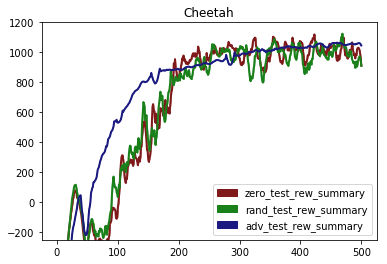

In [14]:
plot_tests = [const_test_rew_summary, rand_test_rew_summary, adv_test_rew_summary]
plot_names = ['zero_test_rew_summary', 'rand_test_rew_summary', 'adv_test_rew_summary']
plot_colors = [(0.5,0.1,0.1), (0.1,0.5,0.1), (0.1,0.1,0.5)]
all_patches = []
for i in range(len(plot_tests)):
    con_rew = np.array(plot_tests[i])
    mean_con = con_rew.mean(0)
    std_con = con_rew.std(0)
    if if_filtering==True:
        mean_window_size = 15
        mean_order = 3
        std_window_size = 45
        std_order = 2
        mean_con = scipy.signal.savgol_filter(mean_con, mean_window_size, mean_order)
        std_con = scipy.signal.savgol_filter(std_con, std_window_size, std_order)
    x = [i for i in range(len(mean_con))]
    plt.plot(x,mean_con,color=plot_colors[i], linewidth=2.0)
    plt.fill_between(x, mean_con-std_con, mean_con+std_con,color=plot_colors[i], alpha=0.5)
    all_patches.append(mpatches.Patch(color=plot_colors[i], label=plot_names[i]))

plt.legend(handles=all_patches)
axes = plt.gca()
axes.set_ylim([-250,1200])
plt.title("Cheetah")
plt.show()